In [ ]:
# Alpha RNN Regime Switching Example
# Author: 
# Version: 1.0 (12.2.2020)
# License: 
# Email: 
# Notes: tested on Mac OS X with Python 3.6 and TensorFlow 1.4

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random

from IPython import display
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
#from alphaRNN import *
from keras.layers import Layer
from keras import backend as K
from keras import layers
import keras.layers
from keras import *
from keras.legacy import interfaces
from sklearn.preprocessing import StandardScaler

from alphaRNN import *
from alphatRNN import *
	
from numpy.random import seed
from tensorflow import set_random_seed

%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-8, restore_best_weights=True)

# Data Generation

In [3]:
def generate_rs_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    step_length=100 
    
    for i in range(2*n_steps):

      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
    
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [4]:
p = 30 # the number of lags used for the DGP
np.random.seed(0)
data=generate_rs_sample(20000, 0.25, 150, 0.1, p, 1e-4, 0.13)[p:]
df = pd.DataFrame(data, columns=['y'])
target = 'y'
use_features = [target] 
n_steps = 20 # number of lags to include in the model
train_weight = 0.8  # train/test split
split = int(len(df)*train_weight)
df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

## Statistical diagnostics

## Augmented Dickey-Fuller test

In [5]:
adf, p, usedlag, nobs, cvs,aic=sm.tsa.stattools.adfuller(df[target][:2000])
print(adf,p, nobs, cvs)

-3.2810394829898897 0.01574757804048544 1999 {'1%': -3.4336254962865045, '5%': -2.862986937508278, '10%': -2.567540287745173}


Text(0.5,0,'lag (j)')

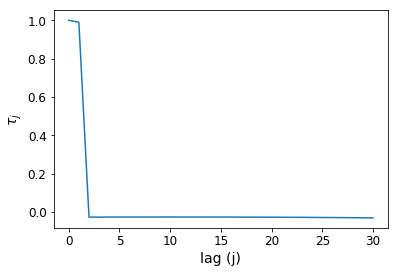

In [6]:
pacf=sm.tsa.stattools.pacf(data, nlags=30)
#n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(df_p)))==False)[0][0] -1
plt.plot(pacf)
plt.ylabel('$\\tau_j$')
plt.xlabel('lag (j)')

### Data structure manipulation for RNNs

In [7]:
def get_lagged_features(value, n_steps,n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [8]:
n_steps_ahead=10 # forecasting horizon

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps, n_steps_ahead).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps,n_steps_ahead).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [9]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(15947, 20, 1) (15947, 1, 1) (3965, 20, 1) (3965, 1, 1)


In [10]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [11]:
print(train_batch_size)

15947


In [20]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))


x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

### Keras Wrappers

In [21]:
def AlphatRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphatRNN(n_units, activation='tanh', recurrent_activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def AlphaRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True, stateful=False))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))  
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = Sequential()
  model.add(LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True)) 
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [22]:
max_epoches=2000
batch_size=1000

In [44]:
params = {'rnn': {'model':'', 'function':SimpleRNN_, 'l1_reg':0.001, 'H':20, 'color': 'blue', 'label':'RNN'}, 
          'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.001, 'H':20,'color': 'green', 'label': '$\\alpha$-RNN' }, 
          'alphatrnn': {'model':'', 'function':AlphatRNN_,'l1_reg':0.0, 'H':20, 'color': 'cyan', 'label': '$\\alpha_t$-RNN'},
          'gru': {'model':'', 'function':GRU_,'l1_reg':0.0, 'H':10, 'color': 'orange', 'label': 'GRU'},
          'lstm': {'model':'', 'function':LSTM_,'l1_reg':0.001, 'H':5, 'color':'red', 'label': 'LSTM'}
         }

# Cross-validation

In [45]:
cross_val=False # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 5)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

    params[key]['H'] = grid_result.best_params_['n_units']
    params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2000
 - 6s - loss: 5.5408
Epoch 2/2000
 - 0s - loss: 5.4404
Epoch 3/2000
 - 0s - loss: 5.3331
Epoch 4/2000
 - 0s - loss: 5.2281
Epoch 5/2000
 - 0s - loss: 5.1251
Epoch 6/2000
 - 0s - loss: 5.0249
Epoch 7/2000
 - 0s - loss: 4.9272
Epoch 8/2000
 - 0s - loss: 4.8329
Epoch 9/2000
 - 0s - loss: 4.7411
Epoch 10/2000
 - 0s - loss: 4.6522
Epoch 11/2000
 - 0s - loss: 4.5659
Epoch 12/2000
 - 0s - loss: 4.4826
Epoch 13/2000
 - 0s - loss: 4.4018
Epoch 14/2000
 - 0s - loss: 4.3232
Epoch 15/2000
 - 0s - loss: 4.2467
Epoch 16/2000
 - 0s - loss: 4.1723
Epoch 17/2000
 - 0s - loss: 4.1000
Epoch 18/2000
 - 0s - loss: 4.0298
Epoch 19/2000
 - 0s - loss: 3.9613
Epoch 20/2000
 - 0s - loss: 3.8946
Epoch 21/2000
 - 0s - loss: 3.8297
Epoch 22/2000
 - 0s - loss: 3.7664
Epoch 23/2000
 - 0s - loss: 3.7046
Epoch 24/2000
 - 0s - loss: 3.6443
Epoch 25/2000
 - 0s - loss: 3.5855
Epoch 26/2000
 - 0s - loss: 3.5284
Epoch 27/2000
 - 0s - loss: 3.4724
Epoch 28/2000
 - 0s - loss: 3.4178
Epoch 29/2000
 - 0s - loss: 3

Epoch 232/2000
 - 0s - loss: 0.0179
Epoch 233/2000
 - 0s - loss: 0.0179
Epoch 234/2000
 - 0s - loss: 0.0179
Epoch 235/2000
 - 0s - loss: 0.0179
Epoch 236/2000
 - 0s - loss: 0.0178
Epoch 237/2000
 - 0s - loss: 0.0178
Epoch 238/2000
 - 0s - loss: 0.0178
Epoch 239/2000
 - 0s - loss: 0.0178
Epoch 240/2000
 - 0s - loss: 0.0177
Epoch 241/2000
 - 0s - loss: 0.0177
Epoch 242/2000
 - 0s - loss: 0.0177
Epoch 243/2000
 - 0s - loss: 0.0177
Epoch 244/2000
 - 0s - loss: 0.0176
Epoch 245/2000
 - 0s - loss: 0.0176
Epoch 246/2000
 - 0s - loss: 0.0176
Epoch 247/2000
 - 0s - loss: 0.0176
Epoch 248/2000
 - 0s - loss: 0.0175
Epoch 249/2000
 - 0s - loss: 0.0175
Epoch 250/2000
 - 0s - loss: 0.0175
Epoch 251/2000
 - 0s - loss: 0.0175
Epoch 252/2000
 - 0s - loss: 0.0175
Epoch 253/2000
 - 0s - loss: 0.0174
Epoch 254/2000
 - 0s - loss: 0.0174
Epoch 255/2000
 - 0s - loss: 0.0174
Epoch 256/2000
 - 0s - loss: 0.0174
Epoch 257/2000
 - 0s - loss: 0.0173
Epoch 258/2000
 - 0s - loss: 0.0173
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0131
Epoch 461/2000
 - 0s - loss: 0.0131
Epoch 462/2000
 - 0s - loss: 0.0131
Epoch 463/2000
 - 0s - loss: 0.0130
Epoch 464/2000
 - 0s - loss: 0.0130
Epoch 465/2000
 - 0s - loss: 0.0130
Epoch 466/2000
 - 0s - loss: 0.0130
Epoch 467/2000
 - 0s - loss: 0.0130
Epoch 468/2000
 - 0s - loss: 0.0129
Epoch 469/2000
 - 0s - loss: 0.0129
Epoch 470/2000
 - 0s - loss: 0.0129
Epoch 471/2000
 - 0s - loss: 0.0129
Epoch 472/2000
 - 0s - loss: 0.0129
Epoch 473/2000
 - 0s - loss: 0.0129
Epoch 474/2000
 - 0s - loss: 0.0128
Epoch 475/2000
 - 0s - loss: 0.0128
Epoch 476/2000
 - 0s - loss: 0.0128
Epoch 477/2000
 - 0s - loss: 0.0128
Epoch 478/2000
 - 0s - loss: 0.0128
Epoch 479/2000
 - 0s - loss: 0.0127
Epoch 480/2000
 - 0s - loss: 0.0127
Epoch 481/2000
 - 0s - loss: 0.0127
Epoch 482/2000
 - 0s - loss: 0.0127
Epoch 483/2000
 - 0s - loss: 0.0127
Epoch 484/2000
 - 0s - loss: 0.0126
Epoch 485/2000
 - 0s - loss: 0.0126
Epoch 486/2000
 - 0s - loss: 0.0126
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0092
Epoch 689/2000
 - 0s - loss: 0.0092
Epoch 690/2000
 - 0s - loss: 0.0091
Epoch 691/2000
 - 0s - loss: 0.0091
Epoch 692/2000
 - 0s - loss: 0.0091
Epoch 693/2000
 - 0s - loss: 0.0091
Epoch 694/2000
 - 0s - loss: 0.0091
Epoch 695/2000
 - 0s - loss: 0.0091
Epoch 696/2000
 - 0s - loss: 0.0091
Epoch 697/2000
 - 0s - loss: 0.0090
Epoch 698/2000
 - 0s - loss: 0.0090
Epoch 699/2000
 - 0s - loss: 0.0090
Epoch 700/2000
 - 0s - loss: 0.0090
Epoch 701/2000
 - 0s - loss: 0.0090
Epoch 702/2000
 - 0s - loss: 0.0090
Epoch 703/2000
 - 0s - loss: 0.0089
Epoch 704/2000
 - 0s - loss: 0.0089
Epoch 705/2000
 - 0s - loss: 0.0089
Epoch 706/2000
 - 0s - loss: 0.0089
Epoch 707/2000
 - 0s - loss: 0.0089
Epoch 708/2000
 - 0s - loss: 0.0089
Epoch 709/2000
 - 0s - loss: 0.0089
Epoch 710/2000
 - 0s - loss: 0.0088
Epoch 711/2000
 - 0s - loss: 0.0088
Epoch 712/2000
 - 0s - loss: 0.0088
Epoch 713/2000
 - 0s - loss: 0.0088
Epoch 714/2000
 - 0s - loss: 0.0088
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0063
Epoch 917/2000
 - 0s - loss: 0.0063
Epoch 918/2000
 - 0s - loss: 0.0063
Epoch 919/2000
 - 0s - loss: 0.0063
Epoch 920/2000
 - 0s - loss: 0.0063
Epoch 921/2000
 - 0s - loss: 0.0063
Epoch 922/2000
 - 0s - loss: 0.0063
Epoch 923/2000
 - 0s - loss: 0.0063
Epoch 924/2000
 - 0s - loss: 0.0063
Epoch 925/2000
 - 0s - loss: 0.0063
Epoch 926/2000
 - 0s - loss: 0.0063
Epoch 927/2000
 - 0s - loss: 0.0063
Epoch 928/2000
 - 0s - loss: 0.0063
Epoch 929/2000
 - 0s - loss: 0.0063
Epoch 930/2000
 - 0s - loss: 0.0062
Epoch 931/2000
 - 0s - loss: 0.0062
Epoch 932/2000
 - 0s - loss: 0.0062
Epoch 933/2000
 - 0s - loss: 0.0062
Epoch 934/2000
 - 0s - loss: 0.0062
Epoch 935/2000
 - 0s - loss: 0.0062
Epoch 936/2000
 - 0s - loss: 0.0062
Epoch 937/2000
 - 0s - loss: 0.0062
Epoch 938/2000
 - 0s - loss: 0.0062
Epoch 939/2000
 - 0s - loss: 0.0062
Epoch 940/2000
 - 0s - loss: 0.0062
Epoch 941/2000
 - 0s - loss: 0.0062
Epoch 942/2000
 - 0s - loss: 0.0062
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0058
Epoch 1141/2000
 - 0s - loss: 0.0058
Epoch 1142/2000
 - 0s - loss: 0.0058
Epoch 1143/2000
 - 0s - loss: 0.0058
Epoch 1144/2000
 - 0s - loss: 0.0058
Epoch 1145/2000
 - 0s - loss: 0.0058
Epoch 1146/2000
 - 0s - loss: 0.0058
Epoch 1147/2000
 - 0s - loss: 0.0058
Epoch 1148/2000
 - 0s - loss: 0.0058
Epoch 1149/2000
 - 0s - loss: 0.0058
Epoch 1150/2000
 - 0s - loss: 0.0058
Epoch 1151/2000
 - 0s - loss: 0.0058
Epoch 1152/2000
 - 0s - loss: 0.0058
Epoch 1153/2000
 - 0s - loss: 0.0058
Epoch 1154/2000
 - 0s - loss: 0.0058
Epoch 1155/2000
 - 0s - loss: 0.0058
Epoch 1156/2000
 - 0s - loss: 0.0058
Epoch 1157/2000
 - 0s - loss: 0.0058
Epoch 1158/2000
 - 0s - loss: 0.0058
Epoch 1159/2000
 - 0s - loss: 0.0058
Epoch 1160/2000
 - 0s - loss: 0.0058
Epoch 1161/2000
 - 0s - loss: 0.0058
Epoch 1162/2000
 - 0s - loss: 0.0058
Epoch 1163/2000
 - 0s - loss: 0.0058
Epoch 1164/2000
 - 0s - loss: 0.0058
Epoch 1165/2000
 - 0s - loss: 0.0058
Epoch 1166/2000
 - 0s - loss: 0.0058
E

 - 0s - loss: 0.0057
Epoch 1362/2000
 - 0s - loss: 0.0057
Epoch 1363/2000
 - 0s - loss: 0.0057
Epoch 1364/2000
 - 0s - loss: 0.0057
Epoch 1365/2000
 - 0s - loss: 0.0057
Epoch 1366/2000
 - 0s - loss: 0.0057
Epoch 1367/2000
 - 0s - loss: 0.0057
Epoch 1368/2000
 - 0s - loss: 0.0057
Epoch 1369/2000
 - 0s - loss: 0.0057
Epoch 1370/2000
 - 0s - loss: 0.0057
Epoch 1371/2000
 - 0s - loss: 0.0057
Epoch 1372/2000
 - 0s - loss: 0.0057
Epoch 1373/2000
 - 0s - loss: 0.0057
Epoch 1374/2000
 - 0s - loss: 0.0057
Epoch 1375/2000
 - 0s - loss: 0.0057
Epoch 1376/2000
 - 0s - loss: 0.0057
Epoch 1377/2000
 - 0s - loss: 0.0057
Epoch 1378/2000
 - 0s - loss: 0.0057
Epoch 1379/2000
 - 0s - loss: 0.0057
Epoch 1380/2000
 - 0s - loss: 0.0057
Epoch 1381/2000
 - 0s - loss: 0.0057
Epoch 1382/2000
 - 0s - loss: 0.0057
Epoch 1383/2000
 - 0s - loss: 0.0057
Epoch 1384/2000
 - 0s - loss: 0.0057
Epoch 1385/2000
 - 0s - loss: 0.0057
Epoch 1386/2000
 - 0s - loss: 0.0057
Epoch 1387/2000
 - 0s - loss: 0.0057
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0057
Epoch 1584/2000
 - 0s - loss: 0.0057
Epoch 1585/2000
 - 0s - loss: 0.0057
Epoch 1586/2000
 - 0s - loss: 0.0057
Epoch 1587/2000
 - 0s - loss: 0.0057
Epoch 1588/2000
 - 0s - loss: 0.0057
Epoch 1589/2000
 - 0s - loss: 0.0057
Epoch 1590/2000
 - 0s - loss: 0.0057
Epoch 1591/2000
 - 0s - loss: 0.0057
Epoch 1592/2000
 - 0s - loss: 0.0057
Epoch 1593/2000
 - 0s - loss: 0.0057
Epoch 1594/2000
 - 0s - loss: 0.0057
Epoch 1595/2000
 - 0s - loss: 0.0057
Epoch 1596/2000
 - 0s - loss: 0.0057
Epoch 1597/2000
 - 0s - loss: 0.0057
Epoch 1598/2000
 - 0s - loss: 0.0057
Epoch 1599/2000
 - 0s - loss: 0.0057
Epoch 1600/2000
 - 0s - loss: 0.0057
Epoch 1601/2000
 - 0s - loss: 0.0057
Epoch 1602/2000
 - 0s - loss: 0.0057
Epoch 1603/2000
 - 0s - loss: 0.0057
Epoch 1604/2000
 - 0s - loss: 0.0057
Epoch 1605/2000
 - 0s - loss: 0.0057
Epoch 1606/2000
 - 0s - loss: 0.0057
Epoch 1607/2000
 - 0s - loss: 0.0057
Epoch 1608/2000
 - 0s - loss: 0.0057
Epoch 1609/2000
 - 0s - loss: 0.0057
E

 - 0s - loss: 0.0057
Epoch 1805/2000
 - 0s - loss: 0.0057
Epoch 1806/2000
 - 0s - loss: 0.0057
Epoch 1807/2000
 - 0s - loss: 0.0057
Epoch 1808/2000
 - 0s - loss: 0.0057
Epoch 1809/2000
 - 0s - loss: 0.0057
Epoch 1810/2000
 - 0s - loss: 0.0057
Epoch 1811/2000
 - 0s - loss: 0.0057
Epoch 1812/2000
 - 0s - loss: 0.0057
Epoch 1813/2000
 - 0s - loss: 0.0057
Epoch 1814/2000
 - 0s - loss: 0.0057
Epoch 1815/2000
 - 0s - loss: 0.0057
Epoch 1816/2000
 - 0s - loss: 0.0057
Epoch 1817/2000
 - 0s - loss: 0.0057
Epoch 1818/2000
 - 0s - loss: 0.0057
Epoch 1819/2000
 - 0s - loss: 0.0057
Epoch 1820/2000
 - 0s - loss: 0.0057
Epoch 1821/2000
 - 0s - loss: 0.0057
Epoch 1822/2000
 - 0s - loss: 0.0057
Epoch 1823/2000
 - 0s - loss: 0.0057
Epoch 1824/2000
 - 0s - loss: 0.0057
Epoch 1825/2000
 - 0s - loss: 0.0057
Epoch 1826/2000
 - 0s - loss: 0.0057
Epoch 1827/2000
 - 0s - loss: 0.0057
Epoch 1828/2000
 - 0s - loss: 0.0057
Epoch 1829/2000
 - 0s - loss: 0.0057
Epoch 1830/2000
 - 0s - loss: 0.0057
Epoch 1831/2000
 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.4s remaining:    0.0s


Epoch 1/2000
 - 6s - loss: 5.4878
Epoch 2/2000
 - 0s - loss: 5.2708
Epoch 3/2000
 - 0s - loss: 5.0656
Epoch 4/2000
 - 0s - loss: 4.8713
Epoch 5/2000
 - 0s - loss: 4.6879
Epoch 6/2000
 - 0s - loss: 4.5160
Epoch 7/2000
 - 0s - loss: 4.3541
Epoch 8/2000
 - 0s - loss: 4.2012
Epoch 9/2000
 - 0s - loss: 4.0566
Epoch 10/2000
 - 0s - loss: 3.9198
Epoch 11/2000
 - 0s - loss: 3.7901
Epoch 12/2000
 - 0s - loss: 3.6672
Epoch 13/2000
 - 0s - loss: 3.5501
Epoch 14/2000
 - 0s - loss: 3.4386
Epoch 15/2000
 - 0s - loss: 3.3324
Epoch 16/2000
 - 0s - loss: 3.2309
Epoch 17/2000
 - 0s - loss: 3.1337
Epoch 18/2000
 - 0s - loss: 3.0403
Epoch 19/2000
 - 0s - loss: 2.9503
Epoch 20/2000
 - 0s - loss: 2.8632
Epoch 21/2000
 - 0s - loss: 2.7782
Epoch 22/2000
 - 0s - loss: 2.6948
Epoch 23/2000
 - 0s - loss: 2.6125
Epoch 24/2000
 - 0s - loss: 2.5304
Epoch 25/2000
 - 0s - loss: 2.4481
Epoch 26/2000
 - 0s - loss: 2.3651
Epoch 27/2000
 - 0s - loss: 2.2812
Epoch 28/2000
 - 0s - loss: 2.1963
Epoch 29/2000
 - 0s - loss: 2

Epoch 232/2000
 - 0s - loss: 0.0129
Epoch 233/2000
 - 0s - loss: 0.0128
Epoch 234/2000
 - 0s - loss: 0.0128
Epoch 235/2000
 - 0s - loss: 0.0128
Epoch 236/2000
 - 0s - loss: 0.0127
Epoch 237/2000
 - 0s - loss: 0.0127
Epoch 238/2000
 - 0s - loss: 0.0127
Epoch 239/2000
 - 0s - loss: 0.0126
Epoch 240/2000
 - 0s - loss: 0.0126
Epoch 241/2000
 - 0s - loss: 0.0125
Epoch 242/2000
 - 0s - loss: 0.0125
Epoch 243/2000
 - 0s - loss: 0.0125
Epoch 244/2000
 - 0s - loss: 0.0124
Epoch 245/2000
 - 0s - loss: 0.0124
Epoch 246/2000
 - 0s - loss: 0.0123
Epoch 247/2000
 - 0s - loss: 0.0123
Epoch 248/2000
 - 0s - loss: 0.0123
Epoch 249/2000
 - 0s - loss: 0.0122
Epoch 250/2000
 - 0s - loss: 0.0122
Epoch 251/2000
 - 0s - loss: 0.0122
Epoch 252/2000
 - 0s - loss: 0.0121
Epoch 253/2000
 - 0s - loss: 0.0121
Epoch 254/2000
 - 0s - loss: 0.0121
Epoch 255/2000
 - 0s - loss: 0.0120
Epoch 256/2000
 - 0s - loss: 0.0120
Epoch 257/2000
 - 0s - loss: 0.0119
Epoch 258/2000
 - 0s - loss: 0.0119
Epoch 259/2000
 - 0s - loss:

Epoch 460/2000
 - 0s - loss: 0.0061
Epoch 461/2000
 - 0s - loss: 0.0061
Epoch 462/2000
 - 0s - loss: 0.0061
Epoch 463/2000
 - 0s - loss: 0.0061
Epoch 464/2000
 - 0s - loss: 0.0061
Epoch 465/2000
 - 0s - loss: 0.0061
Epoch 466/2000
 - 0s - loss: 0.0061
Epoch 467/2000
 - 0s - loss: 0.0060
Epoch 468/2000
 - 0s - loss: 0.0060
Epoch 469/2000
 - 0s - loss: 0.0060
Epoch 470/2000
 - 0s - loss: 0.0060
Epoch 471/2000
 - 0s - loss: 0.0060
Epoch 472/2000
 - 0s - loss: 0.0060
Epoch 473/2000
 - 0s - loss: 0.0060
Epoch 474/2000
 - 0s - loss: 0.0060
Epoch 475/2000
 - 0s - loss: 0.0060
Epoch 476/2000
 - 0s - loss: 0.0060
Epoch 477/2000
 - 0s - loss: 0.0059
Epoch 478/2000
 - 0s - loss: 0.0059
Epoch 479/2000
 - 0s - loss: 0.0059
Epoch 480/2000
 - 0s - loss: 0.0059
Epoch 481/2000
 - 0s - loss: 0.0059
Epoch 482/2000
 - 0s - loss: 0.0059
Epoch 483/2000
 - 0s - loss: 0.0059
Epoch 484/2000
 - 0s - loss: 0.0059
Epoch 485/2000
 - 0s - loss: 0.0059
Epoch 486/2000
 - 0s - loss: 0.0059
Epoch 487/2000
 - 0s - loss:

Epoch 688/2000
 - 0s - loss: 0.0056
Epoch 689/2000
 - 0s - loss: 0.0056
Epoch 690/2000
 - 0s - loss: 0.0056
Epoch 691/2000
 - 0s - loss: 0.0056
Epoch 692/2000
 - 0s - loss: 0.0056
Epoch 693/2000
 - 0s - loss: 0.0056
Epoch 694/2000
 - 0s - loss: 0.0056
Epoch 695/2000
 - 0s - loss: 0.0056
Epoch 696/2000
 - 0s - loss: 0.0056
Epoch 697/2000
 - 0s - loss: 0.0056
Epoch 698/2000
 - 0s - loss: 0.0056
Epoch 699/2000
 - 0s - loss: 0.0056
Epoch 700/2000
 - 0s - loss: 0.0056
Epoch 701/2000
 - 0s - loss: 0.0056
Epoch 702/2000
 - 0s - loss: 0.0056
Epoch 703/2000
 - 0s - loss: 0.0056
Epoch 704/2000
 - 0s - loss: 0.0056
Epoch 705/2000
 - 0s - loss: 0.0056
Epoch 706/2000
 - 0s - loss: 0.0056
Epoch 707/2000
 - 0s - loss: 0.0056
Epoch 708/2000
 - 0s - loss: 0.0056
Epoch 709/2000
 - 0s - loss: 0.0056
Epoch 710/2000
 - 0s - loss: 0.0056
Epoch 711/2000
 - 0s - loss: 0.0056
Epoch 712/2000
 - 0s - loss: 0.0056
Epoch 713/2000
 - 0s - loss: 0.0056
Epoch 714/2000
 - 0s - loss: 0.0056
Epoch 715/2000
 - 0s - loss:

Epoch 916/2000
 - 0s - loss: 0.0056
Epoch 917/2000
 - 0s - loss: 0.0056
Epoch 918/2000
 - 0s - loss: 0.0056
Epoch 919/2000
 - 0s - loss: 0.0056
Epoch 920/2000
 - 0s - loss: 0.0056
Epoch 921/2000
 - 0s - loss: 0.0056
Epoch 922/2000
 - 0s - loss: 0.0056
Epoch 923/2000
 - 0s - loss: 0.0056
Epoch 924/2000
 - 0s - loss: 0.0056
Epoch 925/2000
 - 0s - loss: 0.0056
Epoch 926/2000
 - 0s - loss: 0.0056
Epoch 927/2000
 - 0s - loss: 0.0056
Epoch 928/2000
 - 0s - loss: 0.0056
Epoch 929/2000
 - 0s - loss: 0.0056
Epoch 930/2000
 - 0s - loss: 0.0056
Epoch 931/2000
 - 0s - loss: 0.0056
Epoch 932/2000
 - 0s - loss: 0.0056
Epoch 933/2000
 - 0s - loss: 0.0056
Epoch 934/2000
 - 0s - loss: 0.0056
Epoch 935/2000
 - 0s - loss: 0.0056
Epoch 936/2000
 - 0s - loss: 0.0056
Epoch 937/2000
 - 0s - loss: 0.0056
Epoch 938/2000
 - 0s - loss: 0.0056
Epoch 939/2000
 - 0s - loss: 0.0056
Epoch 940/2000
 - 0s - loss: 0.0056
Epoch 941/2000
 - 0s - loss: 0.0056
Epoch 942/2000
 - 0s - loss: 0.0056
Epoch 943/2000
 - 0s - loss:

Epoch 1140/2000
 - 0s - loss: 0.0056
Epoch 1141/2000
 - 0s - loss: 0.0056
Epoch 1142/2000
 - 0s - loss: 0.0056
Epoch 1143/2000
 - 0s - loss: 0.0056
Epoch 1144/2000
 - 0s - loss: 0.0056
Epoch 1145/2000
 - 0s - loss: 0.0056
Epoch 1146/2000
 - 0s - loss: 0.0056
Epoch 1147/2000
 - 0s - loss: 0.0056
Epoch 1148/2000
 - 0s - loss: 0.0056
Epoch 1149/2000
 - 0s - loss: 0.0056
Epoch 1150/2000
 - 0s - loss: 0.0056
Epoch 1151/2000
 - 0s - loss: 0.0056
Epoch 1152/2000
 - 0s - loss: 0.0056
Epoch 1153/2000
 - 0s - loss: 0.0056
Epoch 1154/2000
 - 0s - loss: 0.0056
Epoch 1155/2000
 - 0s - loss: 0.0056
Epoch 1156/2000
 - 0s - loss: 0.0056
Epoch 1157/2000
 - 0s - loss: 0.0056
Epoch 1158/2000
 - 0s - loss: 0.0056
Epoch 1159/2000
 - 0s - loss: 0.0056
Epoch 1160/2000
 - 0s - loss: 0.0056
Epoch 1161/2000
 - 0s - loss: 0.0056
Epoch 1162/2000
 - 0s - loss: 0.0056
Epoch 1163/2000
 - 0s - loss: 0.0056
Epoch 1164/2000
 - 0s - loss: 0.0056
Epoch 1165/2000
 - 0s - loss: 0.0056
Epoch 1166/2000
 - 0s - loss: 0.0056
E

 - 0s - loss: 0.0055
Epoch 1362/2000
 - 0s - loss: 0.0055
Epoch 1363/2000
 - 0s - loss: 0.0055
Epoch 1364/2000
 - 0s - loss: 0.0055
Epoch 1365/2000
 - 0s - loss: 0.0055
Epoch 1366/2000
 - 0s - loss: 0.0055
Epoch 1367/2000
 - 0s - loss: 0.0055
Epoch 1368/2000
 - 0s - loss: 0.0055
Epoch 1369/2000
 - 0s - loss: 0.0055
Epoch 1370/2000
 - 0s - loss: 0.0055
Epoch 1371/2000
 - 0s - loss: 0.0055
Epoch 1372/2000
 - 0s - loss: 0.0055
Epoch 1373/2000
 - 0s - loss: 0.0055
Epoch 1374/2000
 - 0s - loss: 0.0055
Epoch 1375/2000
 - 0s - loss: 0.0055
Epoch 1376/2000
 - 0s - loss: 0.0055
Epoch 1377/2000
 - 0s - loss: 0.0055
Epoch 1378/2000
 - 0s - loss: 0.0055
Epoch 1379/2000
 - 0s - loss: 0.0055
Epoch 1380/2000
 - 0s - loss: 0.0055
Epoch 1381/2000
 - 0s - loss: 0.0055
Epoch 1382/2000
 - 0s - loss: 0.0055
Epoch 1383/2000
 - 0s - loss: 0.0055
Epoch 1384/2000
 - 0s - loss: 0.0055
Epoch 1385/2000
 - 0s - loss: 0.0055
Epoch 1386/2000
 - 0s - loss: 0.0055
Epoch 1387/2000
 - 0s - loss: 0.0055
Epoch 1388/2000
 

Epoch 1583/2000
 - 0s - loss: 0.0055
Epoch 1584/2000
 - 0s - loss: 0.0055
Epoch 1585/2000
 - 0s - loss: 0.0055
Epoch 1586/2000
 - 0s - loss: 0.0055
Epoch 1587/2000
 - 0s - loss: 0.0055
Epoch 1588/2000
 - 0s - loss: 0.0055
Epoch 1589/2000
 - 0s - loss: 0.0055
Epoch 1590/2000
 - 0s - loss: 0.0055
Epoch 1591/2000
 - 0s - loss: 0.0055
Epoch 1592/2000
 - 0s - loss: 0.0055
Epoch 1593/2000
 - 0s - loss: 0.0055
Epoch 1594/2000
 - 0s - loss: 0.0055
Epoch 1595/2000
 - 0s - loss: 0.0055
Epoch 1596/2000
 - 0s - loss: 0.0055
Epoch 1597/2000
 - 0s - loss: 0.0055
Epoch 1598/2000
 - 0s - loss: 0.0055
Epoch 1599/2000
 - 0s - loss: 0.0055
Epoch 1600/2000
 - 0s - loss: 0.0055
Epoch 1601/2000
 - 0s - loss: 0.0055
Epoch 1602/2000
 - 0s - loss: 0.0055
Epoch 1603/2000
 - 0s - loss: 0.0055
Epoch 1604/2000
 - 0s - loss: 0.0055
Epoch 1605/2000
 - 0s - loss: 0.0055
Epoch 1606/2000
 - 0s - loss: 0.0055
Epoch 1607/2000
 - 0s - loss: 0.0055
Epoch 1608/2000
 - 0s - loss: 0.0055
Epoch 1609/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0055
Epoch 1805/2000
 - 0s - loss: 0.0055
Epoch 1806/2000
 - 0s - loss: 0.0055
Epoch 1807/2000
 - 0s - loss: 0.0055
Epoch 1808/2000
 - 0s - loss: 0.0055
Epoch 1809/2000
 - 0s - loss: 0.0055
Epoch 1810/2000
 - 0s - loss: 0.0055
Epoch 1811/2000
 - 0s - loss: 0.0055
Epoch 1812/2000
 - 0s - loss: 0.0055
Epoch 1813/2000
 - 0s - loss: 0.0055
Epoch 1814/2000
 - 0s - loss: 0.0055
Epoch 1815/2000
 - 0s - loss: 0.0055
Epoch 1816/2000
 - 0s - loss: 0.0055
Epoch 1817/2000
 - 0s - loss: 0.0055
Epoch 1818/2000
 - 0s - loss: 0.0055
Epoch 1819/2000
 - 0s - loss: 0.0055
Epoch 1820/2000
 - 0s - loss: 0.0055
Epoch 1821/2000
 - 0s - loss: 0.0055
Epoch 1822/2000
 - 0s - loss: 0.0055
Epoch 1823/2000
 - 0s - loss: 0.0055
Epoch 1824/2000
 - 0s - loss: 0.0055
Epoch 1825/2000
 - 0s - loss: 0.0055
Epoch 1826/2000
 - 0s - loss: 0.0055
Epoch 1827/2000
 - 0s - loss: 0.0055
Epoch 1828/2000
 - 0s - loss: 0.0055
Epoch 1829/2000
 - 0s - loss: 0.0055
Epoch 1830/2000
 - 0s - loss: 0.0055
Epoch 1831/2000
 

Epoch 24/2000
 - 0s - loss: 1.8667
Epoch 25/2000
 - 0s - loss: 1.7543
Epoch 26/2000
 - 0s - loss: 1.6446
Epoch 27/2000
 - 0s - loss: 1.5387
Epoch 28/2000
 - 0s - loss: 1.4371
Epoch 29/2000
 - 0s - loss: 1.3404
Epoch 30/2000
 - 0s - loss: 1.2488
Epoch 31/2000
 - 0s - loss: 1.1623
Epoch 32/2000
 - 0s - loss: 1.0807
Epoch 33/2000
 - 0s - loss: 1.0040
Epoch 34/2000
 - 0s - loss: 0.9316
Epoch 35/2000
 - 0s - loss: 0.8635
Epoch 36/2000
 - 0s - loss: 0.7991
Epoch 37/2000
 - 0s - loss: 0.7384
Epoch 38/2000
 - 0s - loss: 0.6810
Epoch 39/2000
 - 0s - loss: 0.6268
Epoch 40/2000
 - 0s - loss: 0.5754
Epoch 41/2000
 - 0s - loss: 0.5267
Epoch 42/2000
 - 0s - loss: 0.4808
Epoch 43/2000
 - 0s - loss: 0.4373
Epoch 44/2000
 - 0s - loss: 0.3963
Epoch 45/2000
 - 0s - loss: 0.3578
Epoch 46/2000
 - 0s - loss: 0.3216
Epoch 47/2000
 - 0s - loss: 0.2879
Epoch 48/2000
 - 0s - loss: 0.2567
Epoch 49/2000
 - 0s - loss: 0.2278
Epoch 50/2000
 - 0s - loss: 0.2013
Epoch 51/2000
 - 0s - loss: 0.1772
Epoch 52/2000
 - 0s 

Epoch 254/2000
 - 0s - loss: 0.0091
Epoch 255/2000
 - 0s - loss: 0.0091
Epoch 256/2000
 - 0s - loss: 0.0091
Epoch 257/2000
 - 0s - loss: 0.0090
Epoch 258/2000
 - 0s - loss: 0.0090
Epoch 259/2000
 - 0s - loss: 0.0089
Epoch 260/2000
 - 0s - loss: 0.0089
Epoch 261/2000
 - 0s - loss: 0.0088
Epoch 262/2000
 - 0s - loss: 0.0088
Epoch 263/2000
 - 0s - loss: 0.0088
Epoch 264/2000
 - 0s - loss: 0.0087
Epoch 265/2000
 - 0s - loss: 0.0087
Epoch 266/2000
 - 0s - loss: 0.0086
Epoch 267/2000
 - 0s - loss: 0.0086
Epoch 268/2000
 - 0s - loss: 0.0086
Epoch 269/2000
 - 0s - loss: 0.0085
Epoch 270/2000
 - 0s - loss: 0.0085
Epoch 271/2000
 - 0s - loss: 0.0084
Epoch 272/2000
 - 0s - loss: 0.0084
Epoch 273/2000
 - 0s - loss: 0.0084
Epoch 274/2000
 - 0s - loss: 0.0083
Epoch 275/2000
 - 0s - loss: 0.0083
Epoch 276/2000
 - 0s - loss: 0.0082
Epoch 277/2000
 - 0s - loss: 0.0082
Epoch 278/2000
 - 0s - loss: 0.0082
Epoch 279/2000
 - 0s - loss: 0.0081
Epoch 280/2000
 - 0s - loss: 0.0081
Epoch 281/2000
 - 0s - loss:

Epoch 482/2000
 - 0s - loss: 0.0056
Epoch 483/2000
 - 0s - loss: 0.0056
Epoch 484/2000
 - 0s - loss: 0.0056
Epoch 485/2000
 - 0s - loss: 0.0056
Epoch 486/2000
 - 0s - loss: 0.0056
Epoch 487/2000
 - 0s - loss: 0.0056
Epoch 488/2000
 - 0s - loss: 0.0056
Epoch 489/2000
 - 0s - loss: 0.0056
Epoch 490/2000
 - 0s - loss: 0.0056
Epoch 491/2000
 - 0s - loss: 0.0056
Epoch 492/2000
 - 0s - loss: 0.0056
Epoch 493/2000
 - 0s - loss: 0.0056
Epoch 494/2000
 - 0s - loss: 0.0056
Epoch 495/2000
 - 0s - loss: 0.0056
Epoch 496/2000
 - 0s - loss: 0.0056
Epoch 497/2000
 - 0s - loss: 0.0056
Epoch 498/2000
 - 0s - loss: 0.0056
Epoch 499/2000
 - 0s - loss: 0.0056
Epoch 500/2000
 - 0s - loss: 0.0056
Epoch 501/2000
 - 0s - loss: 0.0056
Epoch 502/2000
 - 0s - loss: 0.0056
Epoch 503/2000
 - 0s - loss: 0.0056
Epoch 504/2000
 - 0s - loss: 0.0056
Epoch 505/2000
 - 0s - loss: 0.0056
Epoch 506/2000
 - 0s - loss: 0.0056
Epoch 507/2000
 - 0s - loss: 0.0056
Epoch 508/2000
 - 0s - loss: 0.0056
Epoch 509/2000
 - 0s - loss:

Epoch 710/2000
 - 0s - loss: 0.0056
Epoch 711/2000
 - 0s - loss: 0.0056
Epoch 712/2000
 - 0s - loss: 0.0056
Epoch 713/2000
 - 0s - loss: 0.0056
Epoch 714/2000
 - 0s - loss: 0.0056
Epoch 715/2000
 - 0s - loss: 0.0056
Epoch 716/2000
 - 0s - loss: 0.0056
Epoch 717/2000
 - 0s - loss: 0.0056
Epoch 718/2000
 - 0s - loss: 0.0056
Epoch 719/2000
 - 0s - loss: 0.0056
Epoch 720/2000
 - 0s - loss: 0.0056
Epoch 721/2000
 - 0s - loss: 0.0056
Epoch 722/2000
 - 0s - loss: 0.0056
Epoch 723/2000
 - 0s - loss: 0.0056
Epoch 724/2000
 - 0s - loss: 0.0056
Epoch 725/2000
 - 0s - loss: 0.0056
Epoch 726/2000
 - 0s - loss: 0.0056
Epoch 727/2000
 - 0s - loss: 0.0056
Epoch 728/2000
 - 0s - loss: 0.0056
Epoch 729/2000
 - 0s - loss: 0.0056
Epoch 730/2000
 - 0s - loss: 0.0056
Epoch 731/2000
 - 0s - loss: 0.0056
Epoch 732/2000
 - 0s - loss: 0.0056
Epoch 733/2000
 - 0s - loss: 0.0056
Epoch 734/2000
 - 0s - loss: 0.0056
Epoch 735/2000
 - 0s - loss: 0.0056
Epoch 736/2000
 - 0s - loss: 0.0056
Epoch 737/2000
 - 0s - loss:

Epoch 938/2000
 - 0s - loss: 0.0055
Epoch 939/2000
 - 0s - loss: 0.0055
Epoch 940/2000
 - 0s - loss: 0.0055
Epoch 941/2000
 - 0s - loss: 0.0055
Epoch 942/2000
 - 0s - loss: 0.0055
Epoch 943/2000
 - 0s - loss: 0.0055
Epoch 944/2000
 - 0s - loss: 0.0055
Epoch 945/2000
 - 0s - loss: 0.0055
Epoch 946/2000
 - 0s - loss: 0.0055
Epoch 947/2000
 - 0s - loss: 0.0055
Epoch 948/2000
 - 0s - loss: 0.0055
Epoch 949/2000
 - 0s - loss: 0.0055
Epoch 950/2000
 - 0s - loss: 0.0055
Epoch 951/2000
 - 0s - loss: 0.0055
Epoch 952/2000
 - 0s - loss: 0.0055
Epoch 953/2000
 - 0s - loss: 0.0055
Epoch 954/2000
 - 0s - loss: 0.0055
Epoch 955/2000
 - 0s - loss: 0.0055
Epoch 956/2000
 - 0s - loss: 0.0055
Epoch 957/2000
 - 0s - loss: 0.0055
Epoch 958/2000
 - 0s - loss: 0.0055
Epoch 959/2000
 - 0s - loss: 0.0055
Epoch 960/2000
 - 0s - loss: 0.0055
Epoch 961/2000
 - 0s - loss: 0.0055
Epoch 962/2000
 - 0s - loss: 0.0055
Epoch 963/2000
 - 0s - loss: 0.0055
Epoch 964/2000
 - 0s - loss: 0.0055
Epoch 965/2000
 - 0s - loss:

 - 0s - loss: 0.0055
Epoch 1162/2000
 - 0s - loss: 0.0055
Epoch 1163/2000
 - 0s - loss: 0.0055
Epoch 1164/2000
 - 0s - loss: 0.0055
Epoch 1165/2000
 - 0s - loss: 0.0055
Epoch 1166/2000
 - 0s - loss: 0.0055
Epoch 1167/2000
 - 0s - loss: 0.0055
Epoch 1168/2000
 - 0s - loss: 0.0055
Epoch 1169/2000
 - 0s - loss: 0.0055
Epoch 1170/2000
 - 0s - loss: 0.0055
Epoch 1171/2000
 - 0s - loss: 0.0055
Epoch 1172/2000
 - 0s - loss: 0.0055
Epoch 1173/2000
 - 0s - loss: 0.0055
Epoch 1174/2000
 - 0s - loss: 0.0055
Epoch 1175/2000
 - 0s - loss: 0.0055
Epoch 1176/2000
 - 0s - loss: 0.0055
Epoch 1177/2000
 - 0s - loss: 0.0055
Epoch 1178/2000
 - 0s - loss: 0.0055
Epoch 1179/2000
 - 0s - loss: 0.0055
Epoch 1180/2000
 - 0s - loss: 0.0055
Epoch 1181/2000
 - 0s - loss: 0.0055
Epoch 1182/2000
 - 0s - loss: 0.0055
Epoch 1183/2000
 - 0s - loss: 0.0055
Epoch 1184/2000
 - 0s - loss: 0.0055
Epoch 1185/2000
 - 0s - loss: 0.0055
Epoch 1186/2000
 - 0s - loss: 0.0055
Epoch 1187/2000
 - 0s - loss: 0.0055
Epoch 1188/2000
 

Epoch 1383/2000
 - 0s - loss: 0.0055
Epoch 1384/2000
 - 0s - loss: 0.0055
Epoch 1385/2000
 - 0s - loss: 0.0055
Epoch 1386/2000
 - 0s - loss: 0.0055
Epoch 1387/2000
 - 0s - loss: 0.0055
Epoch 1388/2000
 - 0s - loss: 0.0055
Epoch 1389/2000
 - 0s - loss: 0.0055
Epoch 1390/2000
 - 0s - loss: 0.0055
Epoch 1391/2000
 - 0s - loss: 0.0055
Epoch 1392/2000
 - 0s - loss: 0.0055
Epoch 1393/2000
 - 0s - loss: 0.0055
Epoch 1394/2000
 - 0s - loss: 0.0055
Epoch 1395/2000
 - 0s - loss: 0.0055
Epoch 1396/2000
 - 0s - loss: 0.0055
Epoch 1397/2000
 - 0s - loss: 0.0055
Epoch 1398/2000
 - 0s - loss: 0.0055
Epoch 1399/2000
 - 0s - loss: 0.0055
Epoch 1400/2000
 - 0s - loss: 0.0055
Epoch 1401/2000
 - 0s - loss: 0.0055
Epoch 1402/2000
 - 0s - loss: 0.0055
Epoch 1403/2000
 - 0s - loss: 0.0055
Epoch 1404/2000
 - 0s - loss: 0.0055
Epoch 1405/2000
 - 0s - loss: 0.0055
Epoch 1406/2000
 - 0s - loss: 0.0055
Epoch 1407/2000
 - 0s - loss: 0.0055
Epoch 1408/2000
 - 0s - loss: 0.0055
Epoch 1409/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0053
Epoch 1605/2000
 - 0s - loss: 0.0053
Epoch 1606/2000
 - 0s - loss: 0.0054
Epoch 1607/2000
 - 0s - loss: 0.0053
Epoch 1608/2000
 - 0s - loss: 0.0053
Epoch 1609/2000
 - 0s - loss: 0.0053
Epoch 1610/2000
 - 0s - loss: 0.0053
Epoch 1611/2000
 - 0s - loss: 0.0053
Epoch 1612/2000
 - 0s - loss: 0.0053
Epoch 1613/2000
 - 0s - loss: 0.0053
Epoch 1614/2000
 - 0s - loss: 0.0053
Epoch 1615/2000
 - 0s - loss: 0.0053
Epoch 1616/2000
 - 0s - loss: 0.0053
Epoch 1617/2000
 - 0s - loss: 0.0053
Epoch 1618/2000
 - 0s - loss: 0.0053
Epoch 1619/2000
 - 0s - loss: 0.0053
Epoch 1620/2000
 - 0s - loss: 0.0053
Epoch 1621/2000
 - 0s - loss: 0.0053
Epoch 1622/2000
 - 0s - loss: 0.0053
Epoch 1623/2000
 - 0s - loss: 0.0053
Epoch 1624/2000
 - 0s - loss: 0.0053
Epoch 1625/2000
 - 0s - loss: 0.0053
Epoch 1626/2000
 - 0s - loss: 0.0053
Epoch 1627/2000
 - 0s - loss: 0.0053
Epoch 1628/2000
 - 0s - loss: 0.0053
Epoch 1629/2000
 - 0s - loss: 0.0053
Epoch 1630/2000
 - 0s - loss: 0.0053
Epoch 1631/2000
 

Epoch 1826/2000
 - 0s - loss: 0.0051
Epoch 1827/2000
 - 0s - loss: 0.0051
Epoch 1828/2000
 - 0s - loss: 0.0051
Epoch 1829/2000
 - 0s - loss: 0.0051
Epoch 1830/2000
 - 0s - loss: 0.0051
Epoch 1831/2000
 - 0s - loss: 0.0051
Epoch 1832/2000
 - 0s - loss: 0.0051
Epoch 1833/2000
 - 0s - loss: 0.0051
Epoch 1834/2000
 - 0s - loss: 0.0051
Epoch 1835/2000
 - 0s - loss: 0.0051
Epoch 1836/2000
 - 0s - loss: 0.0051
Epoch 1837/2000
 - 0s - loss: 0.0051
Epoch 1838/2000
 - 0s - loss: 0.0051
Epoch 1839/2000
 - 0s - loss: 0.0050
Epoch 1840/2000
 - 0s - loss: 0.0050
Epoch 1841/2000
 - 0s - loss: 0.0050
Epoch 1842/2000
 - 0s - loss: 0.0050
Epoch 1843/2000
 - 0s - loss: 0.0050
Epoch 1844/2000
 - 0s - loss: 0.0050
Epoch 1845/2000
 - 0s - loss: 0.0050
Epoch 1846/2000
 - 0s - loss: 0.0050
Epoch 1847/2000
 - 0s - loss: 0.0050
Epoch 1848/2000
 - 0s - loss: 0.0050
Epoch 1849/2000
 - 0s - loss: 0.0050
Epoch 1850/2000
 - 0s - loss: 0.0050
Epoch 1851/2000
 - 0s - loss: 0.0049
Epoch 1852/2000
 - 0s - loss: 0.0049
E

 - 0s - loss: 0.0367
Epoch 47/2000
 - 0s - loss: 0.0321
Epoch 48/2000
 - 0s - loss: 0.0286
Epoch 49/2000
 - 0s - loss: 0.0259
Epoch 50/2000
 - 0s - loss: 0.0239
Epoch 51/2000
 - 0s - loss: 0.0224
Epoch 52/2000
 - 0s - loss: 0.0213
Epoch 53/2000
 - 0s - loss: 0.0205
Epoch 54/2000
 - 0s - loss: 0.0199
Epoch 55/2000
 - 0s - loss: 0.0194
Epoch 56/2000
 - 0s - loss: 0.0190
Epoch 57/2000
 - 0s - loss: 0.0188
Epoch 58/2000
 - 0s - loss: 0.0186
Epoch 59/2000
 - 0s - loss: 0.0184
Epoch 60/2000
 - 0s - loss: 0.0182
Epoch 61/2000
 - 0s - loss: 0.0181
Epoch 62/2000
 - 0s - loss: 0.0180
Epoch 63/2000
 - 0s - loss: 0.0179
Epoch 64/2000
 - 0s - loss: 0.0178
Epoch 65/2000
 - 0s - loss: 0.0177
Epoch 66/2000
 - 0s - loss: 0.0176
Epoch 67/2000
 - 0s - loss: 0.0175
Epoch 68/2000
 - 0s - loss: 0.0174
Epoch 69/2000
 - 0s - loss: 0.0174
Epoch 70/2000
 - 0s - loss: 0.0173
Epoch 71/2000
 - 0s - loss: 0.0172
Epoch 72/2000
 - 0s - loss: 0.0171
Epoch 73/2000
 - 0s - loss: 0.0170
Epoch 74/2000
 - 0s - loss: 0.0169

Epoch 276/2000
 - 0s - loss: 0.0057
Epoch 277/2000
 - 0s - loss: 0.0057
Epoch 278/2000
 - 0s - loss: 0.0057
Epoch 279/2000
 - 0s - loss: 0.0057
Epoch 280/2000
 - 0s - loss: 0.0057
Epoch 281/2000
 - 0s - loss: 0.0057
Epoch 282/2000
 - 0s - loss: 0.0057
Epoch 283/2000
 - 0s - loss: 0.0057
Epoch 284/2000
 - 0s - loss: 0.0057
Epoch 285/2000
 - 0s - loss: 0.0057
Epoch 286/2000
 - 0s - loss: 0.0057
Epoch 287/2000
 - 0s - loss: 0.0057
Epoch 288/2000
 - 0s - loss: 0.0057
Epoch 289/2000
 - 0s - loss: 0.0057
Epoch 290/2000
 - 0s - loss: 0.0057
Epoch 291/2000
 - 0s - loss: 0.0057
Epoch 292/2000
 - 0s - loss: 0.0056
Epoch 293/2000
 - 0s - loss: 0.0056
Epoch 294/2000
 - 0s - loss: 0.0056
Epoch 295/2000
 - 0s - loss: 0.0056
Epoch 296/2000
 - 0s - loss: 0.0056
Epoch 297/2000
 - 0s - loss: 0.0056
Epoch 298/2000
 - 0s - loss: 0.0056
Epoch 299/2000
 - 0s - loss: 0.0056
Epoch 300/2000
 - 0s - loss: 0.0056
Epoch 301/2000
 - 0s - loss: 0.0056
Epoch 302/2000
 - 0s - loss: 0.0056
Epoch 303/2000
 - 0s - loss:

Epoch 504/2000
 - 0s - loss: 0.0056
Epoch 505/2000
 - 0s - loss: 0.0056
Epoch 506/2000
 - 0s - loss: 0.0056
Epoch 507/2000
 - 0s - loss: 0.0056
Epoch 508/2000
 - 0s - loss: 0.0056
Epoch 509/2000
 - 0s - loss: 0.0056
Epoch 510/2000
 - 0s - loss: 0.0056
Epoch 511/2000
 - 0s - loss: 0.0056
Epoch 512/2000
 - 0s - loss: 0.0056
Epoch 513/2000
 - 0s - loss: 0.0056
Epoch 514/2000
 - 0s - loss: 0.0056
Epoch 515/2000
 - 0s - loss: 0.0056
Epoch 516/2000
 - 0s - loss: 0.0056
Epoch 517/2000
 - 0s - loss: 0.0056
Epoch 518/2000
 - 0s - loss: 0.0056
Epoch 519/2000
 - 0s - loss: 0.0056
Epoch 520/2000
 - 0s - loss: 0.0056
Epoch 521/2000
 - 0s - loss: 0.0056
Epoch 522/2000
 - 0s - loss: 0.0056
Epoch 523/2000
 - 0s - loss: 0.0056
Epoch 524/2000
 - 0s - loss: 0.0056
Epoch 525/2000
 - 0s - loss: 0.0056
Epoch 526/2000
 - 0s - loss: 0.0056
Epoch 527/2000
 - 0s - loss: 0.0056
Epoch 528/2000
 - 0s - loss: 0.0056
Epoch 529/2000
 - 0s - loss: 0.0056
Epoch 530/2000
 - 0s - loss: 0.0056
Epoch 531/2000
 - 0s - loss:

Epoch 732/2000
 - 0s - loss: 0.0055
Epoch 733/2000
 - 0s - loss: 0.0055
Epoch 734/2000
 - 0s - loss: 0.0055
Epoch 735/2000
 - 0s - loss: 0.0055
Epoch 736/2000
 - 0s - loss: 0.0055
Epoch 737/2000
 - 0s - loss: 0.0055
Epoch 738/2000
 - 0s - loss: 0.0055
Epoch 739/2000
 - 0s - loss: 0.0055
Epoch 740/2000
 - 0s - loss: 0.0055
Epoch 741/2000
 - 0s - loss: 0.0055
Epoch 742/2000
 - 0s - loss: 0.0055
Epoch 743/2000
 - 0s - loss: 0.0055
Epoch 744/2000
 - 0s - loss: 0.0055
Epoch 745/2000
 - 0s - loss: 0.0055
Epoch 746/2000
 - 0s - loss: 0.0055
Epoch 747/2000
 - 0s - loss: 0.0055
Epoch 748/2000
 - 0s - loss: 0.0055
Epoch 749/2000
 - 0s - loss: 0.0055
Epoch 750/2000
 - 0s - loss: 0.0055
Epoch 751/2000
 - 0s - loss: 0.0055
Epoch 752/2000
 - 0s - loss: 0.0055
Epoch 753/2000
 - 0s - loss: 0.0055
Epoch 754/2000
 - 0s - loss: 0.0055
Epoch 755/2000
 - 0s - loss: 0.0055
Epoch 756/2000
 - 0s - loss: 0.0055
Epoch 757/2000
 - 0s - loss: 0.0055
Epoch 758/2000
 - 0s - loss: 0.0055
Epoch 759/2000
 - 0s - loss:

Epoch 960/2000
 - 0s - loss: 0.0054
Epoch 961/2000
 - 0s - loss: 0.0054
Epoch 962/2000
 - 0s - loss: 0.0054
Epoch 963/2000
 - 0s - loss: 0.0054
Epoch 964/2000
 - 0s - loss: 0.0055
Epoch 965/2000
 - 0s - loss: 0.0054
Epoch 966/2000
 - 0s - loss: 0.0055
Epoch 967/2000
 - 0s - loss: 0.0054
Epoch 968/2000
 - 0s - loss: 0.0054
Epoch 969/2000
 - 0s - loss: 0.0054
Epoch 970/2000
 - 0s - loss: 0.0054
Epoch 971/2000
 - 0s - loss: 0.0054
Epoch 972/2000
 - 0s - loss: 0.0054
Epoch 973/2000
 - 0s - loss: 0.0054
Epoch 974/2000
 - 0s - loss: 0.0054
Epoch 975/2000
 - 0s - loss: 0.0054
Epoch 976/2000
 - 0s - loss: 0.0054
Epoch 977/2000
 - 0s - loss: 0.0054
Epoch 978/2000
 - 0s - loss: 0.0054
Epoch 979/2000
 - 0s - loss: 0.0054
Epoch 980/2000
 - 0s - loss: 0.0054
Epoch 981/2000
 - 0s - loss: 0.0054
Epoch 982/2000
 - 0s - loss: 0.0054
Epoch 983/2000
 - 0s - loss: 0.0054
Epoch 984/2000
 - 0s - loss: 0.0054
Epoch 985/2000
 - 0s - loss: 0.0054
Epoch 986/2000
 - 0s - loss: 0.0054
Epoch 987/2000
 - 0s - loss:

Epoch 1183/2000
 - 0s - loss: 0.0053
Epoch 1184/2000
 - 0s - loss: 0.0053
Epoch 1185/2000
 - 0s - loss: 0.0053
Epoch 1186/2000
 - 0s - loss: 0.0053
Epoch 1187/2000
 - 0s - loss: 0.0053
Epoch 1188/2000
 - 0s - loss: 0.0053
Epoch 1189/2000
 - 0s - loss: 0.0053
Epoch 1190/2000
 - 0s - loss: 0.0053
Epoch 1191/2000
 - 0s - loss: 0.0053
Epoch 1192/2000
 - 0s - loss: 0.0053
Epoch 1193/2000
 - 0s - loss: 0.0053
Epoch 1194/2000
 - 0s - loss: 0.0053
Epoch 1195/2000
 - 0s - loss: 0.0053
Epoch 1196/2000
 - 0s - loss: 0.0053
Epoch 1197/2000
 - 0s - loss: 0.0053
Epoch 1198/2000
 - 0s - loss: 0.0053
Epoch 1199/2000
 - 0s - loss: 0.0053
Epoch 1200/2000
 - 0s - loss: 0.0053
Epoch 1201/2000
 - 0s - loss: 0.0053
Epoch 1202/2000
 - 0s - loss: 0.0053
Epoch 1203/2000
 - 0s - loss: 0.0053
Epoch 1204/2000
 - 0s - loss: 0.0053
Epoch 1205/2000
 - 0s - loss: 0.0053
Epoch 1206/2000
 - 0s - loss: 0.0053
Epoch 1207/2000
 - 0s - loss: 0.0053
Epoch 1208/2000
 - 0s - loss: 0.0053
Epoch 1209/2000
 - 0s - loss: 0.0053
E

 - 0s - loss: 0.0045
Epoch 1405/2000
 - 0s - loss: 0.0045
Epoch 1406/2000
 - 0s - loss: 0.0046
Epoch 1407/2000
 - 0s - loss: 0.0045
Epoch 1408/2000
 - 0s - loss: 0.0045
Epoch 1409/2000
 - 0s - loss: 0.0045
Epoch 1410/2000
 - 0s - loss: 0.0045
Epoch 1411/2000
 - 0s - loss: 0.0045
Epoch 1412/2000
 - 0s - loss: 0.0045
Epoch 1413/2000
 - 0s - loss: 0.0045
Epoch 1414/2000
 - 0s - loss: 0.0045
Epoch 1415/2000
 - 0s - loss: 0.0045
Epoch 1416/2000
 - 0s - loss: 0.0045
Epoch 1417/2000
 - 0s - loss: 0.0045
Epoch 1418/2000
 - 0s - loss: 0.0045
Epoch 1419/2000
 - 0s - loss: 0.0045
Epoch 1420/2000
 - 0s - loss: 0.0045
Epoch 1421/2000
 - 0s - loss: 0.0045
Epoch 1422/2000
 - 0s - loss: 0.0045
Epoch 1423/2000
 - 0s - loss: 0.0045
Epoch 1424/2000
 - 0s - loss: 0.0045
Epoch 1425/2000
 - 0s - loss: 0.0045
Epoch 1426/2000
 - 0s - loss: 0.0045
Epoch 1427/2000
 - 0s - loss: 0.0045
Epoch 1428/2000
 - 0s - loss: 0.0045
Epoch 1429/2000
 - 0s - loss: 0.0045
Epoch 1430/2000
 - 0s - loss: 0.0045
Epoch 1431/2000
 

Epoch 1626/2000
 - 0s - loss: 0.0039
Epoch 1627/2000
 - 0s - loss: 0.0039
Epoch 1628/2000
 - 0s - loss: 0.0038
Epoch 1629/2000
 - 0s - loss: 0.0038
Epoch 1630/2000
 - 0s - loss: 0.0038
Epoch 1631/2000
 - 0s - loss: 0.0038
Epoch 1632/2000
 - 0s - loss: 0.0038
Epoch 1633/2000
 - 0s - loss: 0.0037
Epoch 1634/2000
 - 0s - loss: 0.0037
Epoch 1635/2000
 - 0s - loss: 0.0037
Epoch 1636/2000
 - 0s - loss: 0.0036
Epoch 1637/2000
 - 0s - loss: 0.0036
Epoch 1638/2000
 - 0s - loss: 0.0035
Epoch 1639/2000
 - 0s - loss: 0.0034
Epoch 1640/2000
 - 0s - loss: 0.0034
Epoch 1641/2000
 - 0s - loss: 0.0033
Epoch 1642/2000
 - 0s - loss: 0.0032
Epoch 1643/2000
 - 0s - loss: 0.0030
Epoch 1644/2000
 - 0s - loss: 0.0029
Epoch 1645/2000
 - 0s - loss: 0.0028
Epoch 1646/2000
 - 0s - loss: 0.0030
Epoch 1647/2000
 - 0s - loss: 0.0028
Epoch 1648/2000
 - 0s - loss: 0.0027
Epoch 1649/2000
 - 0s - loss: 0.0028
Epoch 1650/2000
 - 0s - loss: 0.0026
Epoch 1651/2000
 - 0s - loss: 0.0025
Epoch 1652/2000
 - 0s - loss: 0.0025
E

 - 0s - loss: 0.0018
Epoch 1848/2000
 - 0s - loss: 0.0017
Epoch 1849/2000
 - 0s - loss: 0.0017
Epoch 1850/2000
 - 0s - loss: 0.0018
Epoch 1851/2000
 - 0s - loss: 0.0017
Epoch 1852/2000
 - 0s - loss: 0.0017
Epoch 1853/2000
 - 0s - loss: 0.0017
Epoch 1854/2000
 - 0s - loss: 0.0017
Epoch 1855/2000
 - 0s - loss: 0.0017
Epoch 1856/2000
 - 0s - loss: 0.0017
Epoch 1857/2000
 - 0s - loss: 0.0018
Epoch 1858/2000
 - 0s - loss: 0.0017
Epoch 1859/2000
 - 0s - loss: 0.0017
Epoch 1860/2000
 - 0s - loss: 0.0017
Epoch 1861/2000
 - 0s - loss: 0.0017
Epoch 1862/2000
 - 0s - loss: 0.0017
Epoch 1863/2000
 - 0s - loss: 0.0018
Epoch 1864/2000
 - 0s - loss: 0.0018
Epoch 1865/2000
 - 0s - loss: 0.0018
Epoch 1866/2000
 - 0s - loss: 0.0018
Epoch 1867/2000
 - 0s - loss: 0.0017
Epoch 1868/2000
 - 0s - loss: 0.0017
Epoch 1869/2000
 - 0s - loss: 0.0017
Epoch 1870/2000
 - 0s - loss: 0.0017
Epoch 1871/2000
 - 0s - loss: 0.0017
Epoch 1872/2000
 - 0s - loss: 0.0017
Epoch 1873/2000
 - 0s - loss: 0.0017
Epoch 1874/2000
 

Epoch 69/2000
 - 0s - loss: 0.0158
Epoch 70/2000
 - 0s - loss: 0.0157
Epoch 71/2000
 - 0s - loss: 0.0156
Epoch 72/2000
 - 0s - loss: 0.0155
Epoch 73/2000
 - 0s - loss: 0.0154
Epoch 74/2000
 - 0s - loss: 0.0153
Epoch 75/2000
 - 0s - loss: 0.0152
Epoch 76/2000
 - 0s - loss: 0.0151
Epoch 77/2000
 - 0s - loss: 0.0150
Epoch 78/2000
 - 0s - loss: 0.0149
Epoch 79/2000
 - 0s - loss: 0.0148
Epoch 80/2000
 - 0s - loss: 0.0147
Epoch 81/2000
 - 0s - loss: 0.0146
Epoch 82/2000
 - 0s - loss: 0.0145
Epoch 83/2000
 - 0s - loss: 0.0144
Epoch 84/2000
 - 0s - loss: 0.0143
Epoch 85/2000
 - 0s - loss: 0.0142
Epoch 86/2000
 - 0s - loss: 0.0142
Epoch 87/2000
 - 0s - loss: 0.0141
Epoch 88/2000
 - 0s - loss: 0.0140
Epoch 89/2000
 - 0s - loss: 0.0139
Epoch 90/2000
 - 0s - loss: 0.0138
Epoch 91/2000
 - 0s - loss: 0.0137
Epoch 92/2000
 - 0s - loss: 0.0136
Epoch 93/2000
 - 0s - loss: 0.0135
Epoch 94/2000
 - 0s - loss: 0.0134
Epoch 95/2000
 - 0s - loss: 0.0133
Epoch 96/2000
 - 0s - loss: 0.0132
Epoch 97/2000
 - 0s 

Epoch 298/2000
 - 0s - loss: 0.0056
Epoch 299/2000
 - 0s - loss: 0.0056
Epoch 300/2000
 - 0s - loss: 0.0056
Epoch 301/2000
 - 0s - loss: 0.0056
Epoch 302/2000
 - 0s - loss: 0.0056
Epoch 303/2000
 - 0s - loss: 0.0056
Epoch 304/2000
 - 0s - loss: 0.0056
Epoch 305/2000
 - 0s - loss: 0.0056
Epoch 306/2000
 - 0s - loss: 0.0056
Epoch 307/2000
 - 0s - loss: 0.0056
Epoch 308/2000
 - 0s - loss: 0.0056
Epoch 309/2000
 - 0s - loss: 0.0056
Epoch 310/2000
 - 0s - loss: 0.0056
Epoch 311/2000
 - 0s - loss: 0.0056
Epoch 312/2000
 - 0s - loss: 0.0056
Epoch 313/2000
 - 0s - loss: 0.0056
Epoch 314/2000
 - 0s - loss: 0.0056
Epoch 315/2000
 - 0s - loss: 0.0056
Epoch 316/2000
 - 0s - loss: 0.0056
Epoch 317/2000
 - 0s - loss: 0.0056
Epoch 318/2000
 - 0s - loss: 0.0056
Epoch 319/2000
 - 0s - loss: 0.0056
Epoch 320/2000
 - 0s - loss: 0.0056
Epoch 321/2000
 - 0s - loss: 0.0056
Epoch 322/2000
 - 0s - loss: 0.0056
Epoch 323/2000
 - 0s - loss: 0.0056
Epoch 324/2000
 - 0s - loss: 0.0056
Epoch 325/2000
 - 0s - loss:

Epoch 526/2000
 - 0s - loss: 0.0056
Epoch 527/2000
 - 0s - loss: 0.0056
Epoch 528/2000
 - 0s - loss: 0.0056
Epoch 529/2000
 - 0s - loss: 0.0056
Epoch 530/2000
 - 0s - loss: 0.0056
Epoch 531/2000
 - 0s - loss: 0.0056
Epoch 532/2000
 - 0s - loss: 0.0056
Epoch 533/2000
 - 0s - loss: 0.0055
Epoch 534/2000
 - 0s - loss: 0.0055
Epoch 535/2000
 - 0s - loss: 0.0055
Epoch 536/2000
 - 0s - loss: 0.0055
Epoch 537/2000
 - 0s - loss: 0.0055
Epoch 538/2000
 - 0s - loss: 0.0055
Epoch 539/2000
 - 0s - loss: 0.0056
Epoch 540/2000
 - 0s - loss: 0.0056
Epoch 541/2000
 - 0s - loss: 0.0055
Epoch 542/2000
 - 0s - loss: 0.0055
Epoch 543/2000
 - 0s - loss: 0.0055
Epoch 544/2000
 - 0s - loss: 0.0055
Epoch 545/2000
 - 0s - loss: 0.0055
Epoch 546/2000
 - 0s - loss: 0.0056
Epoch 547/2000
 - 0s - loss: 0.0055
Epoch 548/2000
 - 0s - loss: 0.0055
Epoch 549/2000
 - 0s - loss: 0.0055
Epoch 550/2000
 - 0s - loss: 0.0055
Epoch 551/2000
 - 0s - loss: 0.0055
Epoch 552/2000
 - 0s - loss: 0.0055
Epoch 553/2000
 - 0s - loss:

Epoch 754/2000
 - 0s - loss: 0.0055
Epoch 755/2000
 - 0s - loss: 0.0055
Epoch 756/2000
 - 0s - loss: 0.0055
Epoch 757/2000
 - 0s - loss: 0.0055
Epoch 758/2000
 - 0s - loss: 0.0055
Epoch 759/2000
 - 0s - loss: 0.0055
Epoch 760/2000
 - 0s - loss: 0.0055
Epoch 761/2000
 - 0s - loss: 0.0055
Epoch 762/2000
 - 0s - loss: 0.0055
Epoch 763/2000
 - 0s - loss: 0.0055
Epoch 764/2000
 - 0s - loss: 0.0055
Epoch 765/2000
 - 0s - loss: 0.0055
Epoch 766/2000
 - 0s - loss: 0.0055
Epoch 767/2000
 - 0s - loss: 0.0055
Epoch 768/2000
 - 0s - loss: 0.0055
Epoch 769/2000
 - 0s - loss: 0.0055
Epoch 770/2000
 - 0s - loss: 0.0055
Epoch 771/2000
 - 0s - loss: 0.0055
Epoch 772/2000
 - 0s - loss: 0.0055
Epoch 773/2000
 - 0s - loss: 0.0055
Epoch 774/2000
 - 0s - loss: 0.0055
Epoch 775/2000
 - 0s - loss: 0.0055
Epoch 776/2000
 - 0s - loss: 0.0055
Epoch 777/2000
 - 0s - loss: 0.0055
Epoch 778/2000
 - 0s - loss: 0.0055
Epoch 779/2000
 - 0s - loss: 0.0055
Epoch 780/2000
 - 0s - loss: 0.0055
Epoch 781/2000
 - 0s - loss:

Epoch 982/2000
 - 0s - loss: 0.0053
Epoch 983/2000
 - 0s - loss: 0.0053
Epoch 984/2000
 - 0s - loss: 0.0053
Epoch 985/2000
 - 0s - loss: 0.0053
Epoch 986/2000
 - 0s - loss: 0.0053
Epoch 987/2000
 - 0s - loss: 0.0053
Epoch 988/2000
 - 0s - loss: 0.0053
Epoch 989/2000
 - 0s - loss: 0.0053
Epoch 990/2000
 - 0s - loss: 0.0052
Epoch 991/2000
 - 0s - loss: 0.0053
Epoch 992/2000
 - 0s - loss: 0.0052
Epoch 993/2000
 - 0s - loss: 0.0052
Epoch 994/2000
 - 0s - loss: 0.0053
Epoch 995/2000
 - 0s - loss: 0.0052
Epoch 996/2000
 - 0s - loss: 0.0052
Epoch 997/2000
 - 0s - loss: 0.0052
Epoch 998/2000
 - 0s - loss: 0.0052
Epoch 999/2000
 - 0s - loss: 0.0052
Epoch 1000/2000
 - 0s - loss: 0.0052
Epoch 1001/2000
 - 0s - loss: 0.0052
Epoch 1002/2000
 - 0s - loss: 0.0052
Epoch 1003/2000
 - 0s - loss: 0.0052
Epoch 1004/2000
 - 0s - loss: 0.0052
Epoch 1005/2000
 - 0s - loss: 0.0052
Epoch 1006/2000
 - 0s - loss: 0.0052
Epoch 1007/2000
 - 0s - loss: 0.0052
Epoch 1008/2000
 - 0s - loss: 0.0052
Epoch 1009/2000
 - 

Epoch 1204/2000
 - 0s - loss: 0.0042
Epoch 1205/2000
 - 0s - loss: 0.0042
Epoch 1206/2000
 - 0s - loss: 0.0042
Epoch 1207/2000
 - 0s - loss: 0.0042
Epoch 1208/2000
 - 0s - loss: 0.0042
Epoch 1209/2000
 - 0s - loss: 0.0042
Epoch 1210/2000
 - 0s - loss: 0.0042
Epoch 1211/2000
 - 0s - loss: 0.0042
Epoch 1212/2000
 - 0s - loss: 0.0042
Epoch 1213/2000
 - 0s - loss: 0.0042
Epoch 1214/2000
 - 0s - loss: 0.0042
Epoch 1215/2000
 - 0s - loss: 0.0042
Epoch 1216/2000
 - 0s - loss: 0.0042
Epoch 1217/2000
 - 0s - loss: 0.0042
Epoch 1218/2000
 - 0s - loss: 0.0042
Epoch 1219/2000
 - 0s - loss: 0.0042
Epoch 1220/2000
 - 0s - loss: 0.0042
Epoch 1221/2000
 - 0s - loss: 0.0041
Epoch 1222/2000
 - 0s - loss: 0.0041
Epoch 1223/2000
 - 0s - loss: 0.0041
Epoch 1224/2000
 - 0s - loss: 0.0042
Epoch 1225/2000
 - 0s - loss: 0.0041
Epoch 1226/2000
 - 0s - loss: 0.0041
Epoch 1227/2000
 - 0s - loss: 0.0041
Epoch 1228/2000
 - 0s - loss: 0.0041
Epoch 1229/2000
 - 0s - loss: 0.0041
Epoch 1230/2000
 - 0s - loss: 0.0041
E

 - 0s - loss: 0.0018
Epoch 1426/2000
 - 0s - loss: 0.0018
Epoch 1427/2000
 - 0s - loss: 0.0018
Epoch 1428/2000
 - 0s - loss: 0.0018
Epoch 1429/2000
 - 0s - loss: 0.0018
Epoch 1430/2000
 - 0s - loss: 0.0018
Epoch 1431/2000
 - 0s - loss: 0.0018
Epoch 1432/2000
 - 0s - loss: 0.0018
Epoch 1433/2000
 - 0s - loss: 0.0018
Epoch 1434/2000
 - 0s - loss: 0.0018
Epoch 1435/2000
 - 0s - loss: 0.0018
Epoch 1436/2000
 - 0s - loss: 0.0018
Epoch 1437/2000
 - 0s - loss: 0.0018
Epoch 1438/2000
 - 0s - loss: 0.0018
Epoch 1439/2000
 - 0s - loss: 0.0018
Epoch 1440/2000
 - 0s - loss: 0.0018
Epoch 1441/2000
 - 0s - loss: 0.0018
Epoch 1442/2000
 - 0s - loss: 0.0019
Epoch 1443/2000
 - 0s - loss: 0.0018
Epoch 1444/2000
 - 0s - loss: 0.0018
Epoch 1445/2000
 - 0s - loss: 0.0018
Epoch 1446/2000
 - 0s - loss: 0.0018
Epoch 1447/2000
 - 0s - loss: 0.0018
Epoch 1448/2000
 - 0s - loss: 0.0018
Epoch 1449/2000
 - 0s - loss: 0.0019
Epoch 1450/2000
 - 0s - loss: 0.0018
Epoch 1451/2000
 - 0s - loss: 0.0018
Epoch 1452/2000
 

Epoch 1647/2000
 - 0s - loss: 0.0017
Epoch 1648/2000
 - 0s - loss: 0.0015
Epoch 1649/2000
 - 0s - loss: 0.0015
Epoch 1650/2000
 - 0s - loss: 0.0015
Epoch 1651/2000
 - 0s - loss: 0.0015
Epoch 1652/2000
 - 0s - loss: 0.0015
Epoch 1653/2000
 - 0s - loss: 0.0015
Epoch 1654/2000
 - 0s - loss: 0.0015
Epoch 1655/2000
 - 0s - loss: 0.0015
Epoch 1656/2000
 - 0s - loss: 0.0015
Epoch 1657/2000
 - 0s - loss: 0.0015
Epoch 1658/2000
 - 0s - loss: 0.0015
Epoch 1659/2000
 - 0s - loss: 0.0015
Epoch 1660/2000
 - 0s - loss: 0.0015
Epoch 1661/2000
 - 0s - loss: 0.0015
Epoch 1662/2000
 - 0s - loss: 0.0015
Epoch 1663/2000
 - 0s - loss: 0.0015
Epoch 1664/2000
 - 0s - loss: 0.0015
Epoch 1665/2000
 - 0s - loss: 0.0015
Epoch 1666/2000
 - 0s - loss: 0.0015
Epoch 1667/2000
 - 0s - loss: 0.0015
Epoch 1668/2000
 - 0s - loss: 0.0015
Epoch 1669/2000
 - 0s - loss: 0.0015
Epoch 1670/2000
 - 0s - loss: 0.0016
Epoch 1671/2000
 - 0s - loss: 0.0015
Epoch 1672/2000
 - 0s - loss: 0.0015
Epoch 1673/2000
 - 0s - loss: 0.0015
E

 - 0s - loss: 0.0014
Epoch 1869/2000
 - 0s - loss: 0.0014
Epoch 1870/2000
 - 0s - loss: 0.0015
Epoch 1871/2000
 - 0s - loss: 0.0018
Epoch 1872/2000
 - 0s - loss: 0.0015
Epoch 1873/2000
 - 0s - loss: 0.0014
Epoch 1874/2000
 - 0s - loss: 0.0014
Epoch 1875/2000
 - 0s - loss: 0.0015
Epoch 1876/2000
 - 0s - loss: 0.0014
Epoch 1877/2000
 - 0s - loss: 0.0015
Epoch 1878/2000
 - 0s - loss: 0.0015
Epoch 1879/2000
 - 0s - loss: 0.0015
Epoch 1880/2000
 - 0s - loss: 0.0014
Epoch 1881/2000
 - 0s - loss: 0.0014
Epoch 1882/2000
 - 0s - loss: 0.0014
Epoch 1883/2000
 - 0s - loss: 0.0014
Epoch 1884/2000
 - 0s - loss: 0.0014
Epoch 1885/2000
 - 0s - loss: 0.0014
Epoch 1886/2000
 - 0s - loss: 0.0017
Epoch 1887/2000
 - 0s - loss: 0.0015
Epoch 1888/2000
 - 0s - loss: 0.0017
Restoring model weights from the end of the best epoch
Epoch 01888: early stopping
[CV] .............................. l1_reg=0, n_units=5, total= 2.1min
[CV] l1_reg=0, n_units=10 ............................................
Epoch 1/2000
 

 - 0s - loss: 0.0177
Epoch 205/2000
 - 0s - loss: 0.0177
Epoch 206/2000
 - 0s - loss: 0.0177
Epoch 207/2000
 - 0s - loss: 0.0176
Epoch 208/2000
 - 0s - loss: 0.0176
Epoch 209/2000
 - 0s - loss: 0.0176
Epoch 210/2000
 - 0s - loss: 0.0175
Epoch 211/2000
 - 0s - loss: 0.0175
Epoch 212/2000
 - 0s - loss: 0.0175
Epoch 213/2000
 - 0s - loss: 0.0174
Epoch 214/2000
 - 0s - loss: 0.0174
Epoch 215/2000
 - 0s - loss: 0.0174
Epoch 216/2000
 - 0s - loss: 0.0173
Epoch 217/2000
 - 0s - loss: 0.0173
Epoch 218/2000
 - 0s - loss: 0.0173
Epoch 219/2000
 - 0s - loss: 0.0172
Epoch 220/2000
 - 0s - loss: 0.0172
Epoch 221/2000
 - 0s - loss: 0.0172
Epoch 222/2000
 - 0s - loss: 0.0171
Epoch 223/2000
 - 0s - loss: 0.0171
Epoch 224/2000
 - 0s - loss: 0.0171
Epoch 225/2000
 - 0s - loss: 0.0171
Epoch 226/2000
 - 0s - loss: 0.0170
Epoch 227/2000
 - 0s - loss: 0.0170
Epoch 228/2000
 - 0s - loss: 0.0170
Epoch 229/2000
 - 0s - loss: 0.0169
Epoch 230/2000
 - 0s - loss: 0.0169
Epoch 231/2000
 - 0s - loss: 0.0169
Epoch 2

Epoch 432/2000
 - 0s - loss: 0.0118
Epoch 433/2000
 - 0s - loss: 0.0117
Epoch 434/2000
 - 0s - loss: 0.0117
Epoch 435/2000
 - 0s - loss: 0.0117
Epoch 436/2000
 - 0s - loss: 0.0117
Epoch 437/2000
 - 0s - loss: 0.0116
Epoch 438/2000
 - 0s - loss: 0.0116
Epoch 439/2000
 - 0s - loss: 0.0116
Epoch 440/2000
 - 0s - loss: 0.0115
Epoch 441/2000
 - 0s - loss: 0.0115
Epoch 442/2000
 - 0s - loss: 0.0115
Epoch 443/2000
 - 0s - loss: 0.0115
Epoch 444/2000
 - 0s - loss: 0.0114
Epoch 445/2000
 - 0s - loss: 0.0114
Epoch 446/2000
 - 0s - loss: 0.0114
Epoch 447/2000
 - 0s - loss: 0.0114
Epoch 448/2000
 - 0s - loss: 0.0113
Epoch 449/2000
 - 0s - loss: 0.0113
Epoch 450/2000
 - 0s - loss: 0.0113
Epoch 451/2000
 - 0s - loss: 0.0112
Epoch 452/2000
 - 0s - loss: 0.0112
Epoch 453/2000
 - 0s - loss: 0.0112
Epoch 454/2000
 - 0s - loss: 0.0112
Epoch 455/2000
 - 0s - loss: 0.0111
Epoch 456/2000
 - 0s - loss: 0.0111
Epoch 457/2000
 - 0s - loss: 0.0111
Epoch 458/2000
 - 0s - loss: 0.0110
Epoch 459/2000
 - 0s - loss:

Epoch 660/2000
 - 0s - loss: 0.0060
Epoch 661/2000
 - 0s - loss: 0.0060
Epoch 662/2000
 - 0s - loss: 0.0060
Epoch 663/2000
 - 0s - loss: 0.0060
Epoch 664/2000
 - 0s - loss: 0.0060
Epoch 665/2000
 - 0s - loss: 0.0060
Epoch 666/2000
 - 0s - loss: 0.0060
Epoch 667/2000
 - 0s - loss: 0.0060
Epoch 668/2000
 - 0s - loss: 0.0060
Epoch 669/2000
 - 0s - loss: 0.0060
Epoch 670/2000
 - 0s - loss: 0.0060
Epoch 671/2000
 - 0s - loss: 0.0060
Epoch 672/2000
 - 0s - loss: 0.0060
Epoch 673/2000
 - 0s - loss: 0.0060
Epoch 674/2000
 - 0s - loss: 0.0060
Epoch 675/2000
 - 0s - loss: 0.0060
Epoch 676/2000
 - 0s - loss: 0.0060
Epoch 677/2000
 - 0s - loss: 0.0060
Epoch 678/2000
 - 0s - loss: 0.0060
Epoch 679/2000
 - 0s - loss: 0.0060
Epoch 680/2000
 - 0s - loss: 0.0060
Epoch 681/2000
 - 0s - loss: 0.0060
Epoch 682/2000
 - 0s - loss: 0.0060
Epoch 683/2000
 - 0s - loss: 0.0060
Epoch 684/2000
 - 0s - loss: 0.0060
Epoch 685/2000
 - 0s - loss: 0.0060
Epoch 686/2000
 - 0s - loss: 0.0060
Epoch 687/2000
 - 0s - loss:

Epoch 888/2000
 - 0s - loss: 0.0060
Epoch 889/2000
 - 0s - loss: 0.0060
Epoch 890/2000
 - 0s - loss: 0.0060
Epoch 891/2000
 - 0s - loss: 0.0060
Epoch 892/2000
 - 0s - loss: 0.0060
Epoch 893/2000
 - 0s - loss: 0.0060
Epoch 894/2000
 - 0s - loss: 0.0060
Epoch 895/2000
 - 0s - loss: 0.0059
Epoch 896/2000
 - 0s - loss: 0.0059
Epoch 897/2000
 - 0s - loss: 0.0059
Epoch 898/2000
 - 0s - loss: 0.0059
Epoch 899/2000
 - 0s - loss: 0.0059
Epoch 900/2000
 - 0s - loss: 0.0059
Epoch 901/2000
 - 0s - loss: 0.0059
Epoch 902/2000
 - 0s - loss: 0.0059
Epoch 903/2000
 - 0s - loss: 0.0059
Epoch 904/2000
 - 0s - loss: 0.0059
Epoch 905/2000
 - 0s - loss: 0.0059
Epoch 906/2000
 - 0s - loss: 0.0059
Epoch 907/2000
 - 0s - loss: 0.0059
Epoch 908/2000
 - 0s - loss: 0.0059
Epoch 909/2000
 - 0s - loss: 0.0059
Epoch 910/2000
 - 0s - loss: 0.0059
Epoch 911/2000
 - 0s - loss: 0.0059
Epoch 912/2000
 - 0s - loss: 0.0059
Epoch 913/2000
 - 0s - loss: 0.0059
Epoch 914/2000
 - 0s - loss: 0.0059
Epoch 915/2000
 - 0s - loss:

Epoch 1113/2000
 - 0s - loss: 0.0059
Epoch 1114/2000
 - 0s - loss: 0.0059
Epoch 1115/2000
 - 0s - loss: 0.0059
Epoch 1116/2000
 - 0s - loss: 0.0059
Epoch 1117/2000
 - 0s - loss: 0.0059
Epoch 1118/2000
 - 0s - loss: 0.0059
Epoch 1119/2000
 - 0s - loss: 0.0059
Epoch 1120/2000
 - 0s - loss: 0.0059
Epoch 1121/2000
 - 0s - loss: 0.0059
Epoch 1122/2000
 - 0s - loss: 0.0059
Epoch 1123/2000
 - 0s - loss: 0.0059
Epoch 1124/2000
 - 0s - loss: 0.0059
Epoch 1125/2000
 - 0s - loss: 0.0059
Epoch 1126/2000
 - 0s - loss: 0.0059
Epoch 1127/2000
 - 0s - loss: 0.0059
Epoch 1128/2000
 - 0s - loss: 0.0059
Epoch 1129/2000
 - 0s - loss: 0.0059
Epoch 1130/2000
 - 0s - loss: 0.0059
Epoch 1131/2000
 - 0s - loss: 0.0059
Epoch 1132/2000
 - 0s - loss: 0.0059
Epoch 1133/2000
 - 0s - loss: 0.0059
Epoch 1134/2000
 - 0s - loss: 0.0059
Epoch 1135/2000
 - 0s - loss: 0.0059
Epoch 1136/2000
 - 0s - loss: 0.0059
Epoch 1137/2000
 - 0s - loss: 0.0059
Epoch 1138/2000
 - 0s - loss: 0.0059
Epoch 1139/2000
 - 0s - loss: 0.0059
E

 - 0s - loss: 0.0058
Epoch 1335/2000
 - 0s - loss: 0.0058
Epoch 1336/2000
 - 0s - loss: 0.0058
Epoch 1337/2000
 - 0s - loss: 0.0058
Epoch 1338/2000
 - 0s - loss: 0.0058
Epoch 1339/2000
 - 0s - loss: 0.0058
Epoch 1340/2000
 - 0s - loss: 0.0058
Epoch 1341/2000
 - 0s - loss: 0.0058
Epoch 1342/2000
 - 0s - loss: 0.0058
Epoch 1343/2000
 - 0s - loss: 0.0058
Epoch 1344/2000
 - 0s - loss: 0.0058
Epoch 1345/2000
 - 0s - loss: 0.0058
Epoch 1346/2000
 - 0s - loss: 0.0058
Epoch 1347/2000
 - 0s - loss: 0.0058
Epoch 1348/2000
 - 0s - loss: 0.0058
Epoch 1349/2000
 - 0s - loss: 0.0058
Epoch 1350/2000
 - 0s - loss: 0.0058
Epoch 1351/2000
 - 0s - loss: 0.0058
Epoch 1352/2000
 - 0s - loss: 0.0058
Epoch 1353/2000
 - 0s - loss: 0.0058
Epoch 1354/2000
 - 0s - loss: 0.0058
Epoch 1355/2000
 - 0s - loss: 0.0058
Epoch 1356/2000
 - 0s - loss: 0.0058
Epoch 1357/2000
 - 0s - loss: 0.0058
Epoch 1358/2000
 - 0s - loss: 0.0058
Epoch 1359/2000
 - 0s - loss: 0.0058
Epoch 1360/2000
 - 0s - loss: 0.0058
Epoch 1361/2000
 

Epoch 1556/2000
 - 0s - loss: 0.0057
Epoch 1557/2000
 - 0s - loss: 0.0057
Epoch 1558/2000
 - 0s - loss: 0.0057
Epoch 1559/2000
 - 0s - loss: 0.0057
Epoch 1560/2000
 - 0s - loss: 0.0057
Epoch 1561/2000
 - 0s - loss: 0.0057
Epoch 1562/2000
 - 0s - loss: 0.0057
Epoch 1563/2000
 - 0s - loss: 0.0057
Epoch 1564/2000
 - 0s - loss: 0.0057
Epoch 1565/2000
 - 0s - loss: 0.0057
Epoch 1566/2000
 - 0s - loss: 0.0057
Epoch 1567/2000
 - 0s - loss: 0.0057
Epoch 1568/2000
 - 0s - loss: 0.0057
Epoch 1569/2000
 - 0s - loss: 0.0057
Epoch 1570/2000
 - 0s - loss: 0.0057
Epoch 1571/2000
 - 0s - loss: 0.0057
Epoch 1572/2000
 - 0s - loss: 0.0057
Epoch 1573/2000
 - 0s - loss: 0.0057
Epoch 1574/2000
 - 0s - loss: 0.0057
Epoch 1575/2000
 - 0s - loss: 0.0057
Epoch 1576/2000
 - 0s - loss: 0.0057
Epoch 1577/2000
 - 0s - loss: 0.0057
Epoch 1578/2000
 - 0s - loss: 0.0057
Epoch 1579/2000
 - 0s - loss: 0.0057
Epoch 1580/2000
 - 0s - loss: 0.0057
Epoch 1581/2000
 - 0s - loss: 0.0057
Epoch 1582/2000
 - 0s - loss: 0.0057
E

 - 0s - loss: 0.0057
Epoch 1778/2000
 - 0s - loss: 0.0057
Epoch 1779/2000
 - 0s - loss: 0.0057
Epoch 1780/2000
 - 0s - loss: 0.0057
Epoch 1781/2000
 - 0s - loss: 0.0057
Epoch 1782/2000
 - 0s - loss: 0.0057
Epoch 1783/2000
 - 0s - loss: 0.0057
Epoch 1784/2000
 - 0s - loss: 0.0057
Epoch 1785/2000
 - 0s - loss: 0.0057
Epoch 1786/2000
 - 0s - loss: 0.0057
Epoch 1787/2000
 - 0s - loss: 0.0057
Epoch 1788/2000
 - 0s - loss: 0.0057
Epoch 1789/2000
 - 0s - loss: 0.0057
Epoch 1790/2000
 - 0s - loss: 0.0057
Epoch 1791/2000
 - 0s - loss: 0.0057
Epoch 1792/2000
 - 0s - loss: 0.0057
Epoch 1793/2000
 - 0s - loss: 0.0057
Epoch 1794/2000
 - 0s - loss: 0.0057
Epoch 1795/2000
 - 0s - loss: 0.0057
Epoch 1796/2000
 - 0s - loss: 0.0057
Epoch 1797/2000
 - 0s - loss: 0.0057
Epoch 1798/2000
 - 0s - loss: 0.0057
Epoch 1799/2000
 - 0s - loss: 0.0057
Epoch 1800/2000
 - 0s - loss: 0.0057
Epoch 1801/2000
 - 0s - loss: 0.0057
Epoch 1802/2000
 - 0s - loss: 0.0057
Epoch 1803/2000
 - 0s - loss: 0.0057
Epoch 1804/2000
 

Epoch 1999/2000
 - 0s - loss: 0.0056
Epoch 2000/2000
 - 0s - loss: 0.0056
[CV] ............................. l1_reg=0, n_units=10, total=  42.3s
[CV] l1_reg=0, n_units=10 ............................................
Epoch 1/2000
 - 6s - loss: 4.8870
Epoch 2/2000
 - 0s - loss: 4.5673
Epoch 3/2000
 - 0s - loss: 4.2819
Epoch 4/2000
 - 0s - loss: 4.0295
Epoch 5/2000
 - 0s - loss: 3.8064
Epoch 6/2000
 - 0s - loss: 3.6081
Epoch 7/2000
 - 0s - loss: 3.4300
Epoch 8/2000
 - 0s - loss: 3.2685
Epoch 9/2000
 - 0s - loss: 3.1220
Epoch 10/2000
 - 0s - loss: 2.9886
Epoch 11/2000
 - 0s - loss: 2.8663
Epoch 12/2000
 - 0s - loss: 2.7536
Epoch 13/2000
 - 0s - loss: 2.6493
Epoch 14/2000
 - 0s - loss: 2.5521
Epoch 15/2000
 - 0s - loss: 2.4613
Epoch 16/2000
 - 0s - loss: 2.3751
Epoch 17/2000
 - 0s - loss: 2.2925
Epoch 18/2000
 - 0s - loss: 2.2117
Epoch 19/2000
 - 0s - loss: 2.1317
Epoch 20/2000
 - 0s - loss: 2.0515
Epoch 21/2000
 - 0s - loss: 1.9706
Epoch 22/2000
 - 0s - loss: 1.8889
Epoch 23/2000
 - 0s - l

Epoch 226/2000
 - 0s - loss: 0.0087
Epoch 227/2000
 - 0s - loss: 0.0086
Epoch 228/2000
 - 0s - loss: 0.0085
Epoch 229/2000
 - 0s - loss: 0.0084
Epoch 230/2000
 - 0s - loss: 0.0083
Epoch 231/2000
 - 0s - loss: 0.0082
Epoch 232/2000
 - 0s - loss: 0.0081
Epoch 233/2000
 - 0s - loss: 0.0080
Epoch 234/2000
 - 0s - loss: 0.0080
Epoch 235/2000
 - 0s - loss: 0.0079
Epoch 236/2000
 - 0s - loss: 0.0078
Epoch 237/2000
 - 0s - loss: 0.0077
Epoch 238/2000
 - 0s - loss: 0.0076
Epoch 239/2000
 - 0s - loss: 0.0075
Epoch 240/2000
 - 0s - loss: 0.0074
Epoch 241/2000
 - 0s - loss: 0.0074
Epoch 242/2000
 - 0s - loss: 0.0073
Epoch 243/2000
 - 0s - loss: 0.0072
Epoch 244/2000
 - 0s - loss: 0.0071
Epoch 245/2000
 - 0s - loss: 0.0071
Epoch 246/2000
 - 0s - loss: 0.0070
Epoch 247/2000
 - 0s - loss: 0.0069
Epoch 248/2000
 - 0s - loss: 0.0069
Epoch 249/2000
 - 0s - loss: 0.0068
Epoch 250/2000
 - 0s - loss: 0.0067
Epoch 251/2000
 - 0s - loss: 0.0067
Epoch 252/2000
 - 0s - loss: 0.0066
Epoch 253/2000
 - 0s - loss:

Epoch 454/2000
 - 0s - loss: 0.0058
Epoch 455/2000
 - 0s - loss: 0.0058
Epoch 456/2000
 - 0s - loss: 0.0058
Epoch 457/2000
 - 0s - loss: 0.0058
Epoch 458/2000
 - 0s - loss: 0.0058
Epoch 459/2000
 - 0s - loss: 0.0058
Epoch 460/2000
 - 0s - loss: 0.0058
Epoch 461/2000
 - 0s - loss: 0.0058
Epoch 462/2000
 - 0s - loss: 0.0058
Epoch 463/2000
 - 0s - loss: 0.0058
Epoch 464/2000
 - 0s - loss: 0.0058
Epoch 465/2000
 - 0s - loss: 0.0058
Epoch 466/2000
 - 0s - loss: 0.0058
Epoch 467/2000
 - 0s - loss: 0.0058
Epoch 468/2000
 - 0s - loss: 0.0058
Epoch 469/2000
 - 0s - loss: 0.0058
Epoch 470/2000
 - 0s - loss: 0.0058
Epoch 471/2000
 - 0s - loss: 0.0058
Epoch 472/2000
 - 0s - loss: 0.0058
Epoch 473/2000
 - 0s - loss: 0.0058
Epoch 474/2000
 - 0s - loss: 0.0058
Epoch 475/2000
 - 0s - loss: 0.0058
Epoch 476/2000
 - 0s - loss: 0.0058
Epoch 477/2000
 - 0s - loss: 0.0058
Epoch 478/2000
 - 0s - loss: 0.0058
Epoch 479/2000
 - 0s - loss: 0.0058
Epoch 480/2000
 - 0s - loss: 0.0058
Epoch 481/2000
 - 0s - loss:

Epoch 682/2000
 - 0s - loss: 0.0057
Epoch 683/2000
 - 0s - loss: 0.0057
Epoch 684/2000
 - 0s - loss: 0.0057
Epoch 685/2000
 - 0s - loss: 0.0057
Epoch 686/2000
 - 0s - loss: 0.0057
Epoch 687/2000
 - 0s - loss: 0.0057
Epoch 688/2000
 - 0s - loss: 0.0057
Epoch 689/2000
 - 0s - loss: 0.0057
Epoch 690/2000
 - 0s - loss: 0.0057
Epoch 691/2000
 - 0s - loss: 0.0057
Epoch 692/2000
 - 0s - loss: 0.0057
Epoch 693/2000
 - 0s - loss: 0.0057
Epoch 694/2000
 - 0s - loss: 0.0057
Epoch 695/2000
 - 0s - loss: 0.0057
Epoch 696/2000
 - 0s - loss: 0.0057
Epoch 697/2000
 - 0s - loss: 0.0057
Epoch 698/2000
 - 0s - loss: 0.0057
Epoch 699/2000
 - 0s - loss: 0.0057
Epoch 700/2000
 - 0s - loss: 0.0057
Epoch 701/2000
 - 0s - loss: 0.0056
Epoch 702/2000
 - 0s - loss: 0.0057
Epoch 703/2000
 - 0s - loss: 0.0056
Epoch 704/2000
 - 0s - loss: 0.0056
Epoch 705/2000
 - 0s - loss: 0.0056
Epoch 706/2000
 - 0s - loss: 0.0056
Epoch 707/2000
 - 0s - loss: 0.0056
Epoch 708/2000
 - 0s - loss: 0.0056
Epoch 709/2000
 - 0s - loss:

Epoch 910/2000
 - 0s - loss: 0.0056
Epoch 911/2000
 - 0s - loss: 0.0055
Epoch 912/2000
 - 0s - loss: 0.0055
Epoch 913/2000
 - 0s - loss: 0.0055
Epoch 914/2000
 - 0s - loss: 0.0055
Epoch 915/2000
 - 0s - loss: 0.0055
Epoch 916/2000
 - 0s - loss: 0.0055
Epoch 917/2000
 - 0s - loss: 0.0055
Epoch 918/2000
 - 0s - loss: 0.0055
Epoch 919/2000
 - 0s - loss: 0.0055
Epoch 920/2000
 - 0s - loss: 0.0055
Epoch 921/2000
 - 0s - loss: 0.0055
Epoch 922/2000
 - 0s - loss: 0.0056
Epoch 923/2000
 - 0s - loss: 0.0055
Epoch 924/2000
 - 0s - loss: 0.0055
Epoch 925/2000
 - 0s - loss: 0.0055
Epoch 926/2000
 - 0s - loss: 0.0055
Epoch 927/2000
 - 0s - loss: 0.0055
Epoch 928/2000
 - 0s - loss: 0.0055
Epoch 929/2000
 - 0s - loss: 0.0055
Epoch 930/2000
 - 0s - loss: 0.0055
Epoch 931/2000
 - 0s - loss: 0.0055
Epoch 932/2000
 - 0s - loss: 0.0055
Epoch 933/2000
 - 0s - loss: 0.0055
Epoch 934/2000
 - 0s - loss: 0.0055
Epoch 935/2000
 - 0s - loss: 0.0055
Epoch 936/2000
 - 0s - loss: 0.0055
Epoch 937/2000
 - 0s - loss:

Epoch 1134/2000
 - 0s - loss: 0.0055
Epoch 1135/2000
 - 0s - loss: 0.0055
Epoch 1136/2000
 - 0s - loss: 0.0055
Epoch 1137/2000
 - 0s - loss: 0.0055
Epoch 1138/2000
 - 0s - loss: 0.0055
Epoch 1139/2000
 - 0s - loss: 0.0055
Epoch 1140/2000
 - 0s - loss: 0.0055
Epoch 1141/2000
 - 0s - loss: 0.0055
Epoch 1142/2000
 - 0s - loss: 0.0055
Epoch 1143/2000
 - 0s - loss: 0.0055
Epoch 1144/2000
 - 0s - loss: 0.0055
Epoch 1145/2000
 - 0s - loss: 0.0055
Epoch 1146/2000
 - 0s - loss: 0.0055
Epoch 1147/2000
 - 0s - loss: 0.0055
Epoch 1148/2000
 - 0s - loss: 0.0055
Epoch 1149/2000
 - 0s - loss: 0.0055
Epoch 1150/2000
 - 0s - loss: 0.0055
Epoch 1151/2000
 - 0s - loss: 0.0055
Epoch 1152/2000
 - 0s - loss: 0.0055
Epoch 1153/2000
 - 0s - loss: 0.0055
Epoch 1154/2000
 - 0s - loss: 0.0055
Epoch 1155/2000
 - 0s - loss: 0.0055
Epoch 1156/2000
 - 0s - loss: 0.0055
Epoch 1157/2000
 - 0s - loss: 0.0055
Epoch 1158/2000
 - 0s - loss: 0.0055
Epoch 1159/2000
 - 0s - loss: 0.0055
Epoch 1160/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0055
Epoch 1356/2000
 - 0s - loss: 0.0055
Epoch 1357/2000
 - 0s - loss: 0.0055
Epoch 1358/2000
 - 0s - loss: 0.0055
Epoch 1359/2000
 - 0s - loss: 0.0055
Epoch 1360/2000
 - 0s - loss: 0.0055
Epoch 1361/2000
 - 0s - loss: 0.0055
Epoch 1362/2000
 - 0s - loss: 0.0055
Epoch 1363/2000
 - 0s - loss: 0.0055
Epoch 1364/2000
 - 0s - loss: 0.0055
Epoch 1365/2000
 - 0s - loss: 0.0055
Epoch 1366/2000
 - 0s - loss: 0.0055
Epoch 1367/2000
 - 0s - loss: 0.0055
Epoch 1368/2000
 - 0s - loss: 0.0055
Epoch 1369/2000
 - 0s - loss: 0.0055
Epoch 1370/2000
 - 0s - loss: 0.0055
Epoch 1371/2000
 - 0s - loss: 0.0055
Epoch 1372/2000
 - 0s - loss: 0.0055
Epoch 1373/2000
 - 0s - loss: 0.0055
Epoch 1374/2000
 - 0s - loss: 0.0055
Epoch 1375/2000
 - 0s - loss: 0.0055
Epoch 1376/2000
 - 0s - loss: 0.0055
Epoch 1377/2000
 - 0s - loss: 0.0055
Epoch 1378/2000
 - 0s - loss: 0.0055
Epoch 1379/2000
 - 0s - loss: 0.0055
Epoch 1380/2000
 - 0s - loss: 0.0055
Epoch 1381/2000
 - 0s - loss: 0.0055
Epoch 1382/2000
 

Epoch 1577/2000
 - 0s - loss: 0.0055
Epoch 1578/2000
 - 0s - loss: 0.0055
Epoch 1579/2000
 - 0s - loss: 0.0055
Epoch 1580/2000
 - 0s - loss: 0.0055
Epoch 1581/2000
 - 0s - loss: 0.0055
Epoch 1582/2000
 - 0s - loss: 0.0055
Epoch 1583/2000
 - 0s - loss: 0.0055
Epoch 1584/2000
 - 0s - loss: 0.0055
Epoch 1585/2000
 - 0s - loss: 0.0055
Epoch 1586/2000
 - 0s - loss: 0.0055
Epoch 1587/2000
 - 0s - loss: 0.0055
Epoch 1588/2000
 - 0s - loss: 0.0055
Epoch 1589/2000
 - 0s - loss: 0.0055
Epoch 1590/2000
 - 0s - loss: 0.0055
Epoch 1591/2000
 - 0s - loss: 0.0055
Epoch 1592/2000
 - 0s - loss: 0.0055
Epoch 1593/2000
 - 0s - loss: 0.0055
Epoch 1594/2000
 - 0s - loss: 0.0055
Epoch 1595/2000
 - 0s - loss: 0.0055
Epoch 1596/2000
 - 0s - loss: 0.0055
Epoch 1597/2000
 - 0s - loss: 0.0055
Epoch 1598/2000
 - 0s - loss: 0.0055
Epoch 1599/2000
 - 0s - loss: 0.0055
Epoch 1600/2000
 - 0s - loss: 0.0055
Epoch 1601/2000
 - 0s - loss: 0.0055
Epoch 1602/2000
 - 0s - loss: 0.0055
Epoch 1603/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0054
Epoch 1799/2000
 - 0s - loss: 0.0054
Epoch 1800/2000
 - 0s - loss: 0.0054
Epoch 1801/2000
 - 0s - loss: 0.0054
Epoch 1802/2000
 - 0s - loss: 0.0054
Epoch 1803/2000
 - 0s - loss: 0.0054
Epoch 1804/2000
 - 0s - loss: 0.0054
Epoch 1805/2000
 - 0s - loss: 0.0054
Epoch 1806/2000
 - 0s - loss: 0.0054
Epoch 1807/2000
 - 0s - loss: 0.0054
Epoch 1808/2000
 - 0s - loss: 0.0054
Epoch 1809/2000
 - 0s - loss: 0.0054
Epoch 1810/2000
 - 0s - loss: 0.0054
Epoch 1811/2000
 - 0s - loss: 0.0054
Epoch 1812/2000
 - 0s - loss: 0.0054
Epoch 1813/2000
 - 0s - loss: 0.0054
Epoch 1814/2000
 - 0s - loss: 0.0054
Epoch 1815/2000
 - 0s - loss: 0.0055
Epoch 1816/2000
 - 0s - loss: 0.0054
Epoch 1817/2000
 - 0s - loss: 0.0054
Epoch 1818/2000
 - 0s - loss: 0.0054
Epoch 1819/2000
 - 0s - loss: 0.0054
Epoch 1820/2000
 - 0s - loss: 0.0054
Epoch 1821/2000
 - 0s - loss: 0.0054
Epoch 1822/2000
 - 0s - loss: 0.0054
Epoch 1823/2000
 - 0s - loss: 0.0054
Epoch 1824/2000
 - 0s - loss: 0.0054
Epoch 1825/2000
 

 - 0s - loss: 1.8482
Epoch 18/2000
 - 0s - loss: 1.7389
Epoch 19/2000
 - 0s - loss: 1.6292
Epoch 20/2000
 - 0s - loss: 1.5193
Epoch 21/2000
 - 0s - loss: 1.4089
Epoch 22/2000
 - 0s - loss: 1.2971
Epoch 23/2000
 - 0s - loss: 1.1831
Epoch 24/2000
 - 0s - loss: 1.0657
Epoch 25/2000
 - 0s - loss: 0.9446
Epoch 26/2000
 - 0s - loss: 0.8193
Epoch 27/2000
 - 0s - loss: 0.6907
Epoch 28/2000
 - 0s - loss: 0.5622
Epoch 29/2000
 - 0s - loss: 0.4385
Epoch 30/2000
 - 0s - loss: 0.3264
Epoch 31/2000
 - 0s - loss: 0.2309
Epoch 32/2000
 - 0s - loss: 0.1559
Epoch 33/2000
 - 0s - loss: 0.1014
Epoch 34/2000
 - 0s - loss: 0.0653
Epoch 35/2000
 - 0s - loss: 0.0436
Epoch 36/2000
 - 0s - loss: 0.0318
Epoch 37/2000
 - 0s - loss: 0.0259
Epoch 38/2000
 - 0s - loss: 0.0233
Epoch 39/2000
 - 0s - loss: 0.0223
Epoch 40/2000
 - 0s - loss: 0.0219
Epoch 41/2000
 - 0s - loss: 0.0217
Epoch 42/2000
 - 0s - loss: 0.0215
Epoch 43/2000
 - 0s - loss: 0.0214
Epoch 44/2000
 - 0s - loss: 0.0213
Epoch 45/2000
 - 0s - loss: 0.0211

 - 0s - loss: 0.0059
Epoch 248/2000
 - 0s - loss: 0.0059
Epoch 249/2000
 - 0s - loss: 0.0059
Epoch 250/2000
 - 0s - loss: 0.0059
Epoch 251/2000
 - 0s - loss: 0.0059
Epoch 252/2000
 - 0s - loss: 0.0059
Epoch 253/2000
 - 0s - loss: 0.0059
Epoch 254/2000
 - 0s - loss: 0.0059
Epoch 255/2000
 - 0s - loss: 0.0059
Epoch 256/2000
 - 0s - loss: 0.0059
Epoch 257/2000
 - 0s - loss: 0.0059
Epoch 258/2000
 - 0s - loss: 0.0059
Epoch 259/2000
 - 0s - loss: 0.0059
Epoch 260/2000
 - 0s - loss: 0.0059
Epoch 261/2000
 - 0s - loss: 0.0059
Epoch 262/2000
 - 0s - loss: 0.0059
Epoch 263/2000
 - 0s - loss: 0.0059
Epoch 264/2000
 - 0s - loss: 0.0059
Epoch 265/2000
 - 0s - loss: 0.0059
Epoch 266/2000
 - 0s - loss: 0.0059
Epoch 267/2000
 - 0s - loss: 0.0059
Epoch 268/2000
 - 0s - loss: 0.0059
Epoch 269/2000
 - 0s - loss: 0.0059
Epoch 270/2000
 - 0s - loss: 0.0059
Epoch 271/2000
 - 0s - loss: 0.0059
Epoch 272/2000
 - 0s - loss: 0.0059
Epoch 273/2000
 - 0s - loss: 0.0059
Epoch 274/2000
 - 0s - loss: 0.0059
Epoch 2

Epoch 475/2000
 - 0s - loss: 0.0057
Epoch 476/2000
 - 0s - loss: 0.0057
Epoch 477/2000
 - 0s - loss: 0.0057
Epoch 478/2000
 - 0s - loss: 0.0057
Epoch 479/2000
 - 0s - loss: 0.0057
Epoch 480/2000
 - 0s - loss: 0.0057
Epoch 481/2000
 - 0s - loss: 0.0057
Epoch 482/2000
 - 0s - loss: 0.0057
Epoch 483/2000
 - 0s - loss: 0.0057
Epoch 484/2000
 - 0s - loss: 0.0057
Epoch 485/2000
 - 0s - loss: 0.0057
Epoch 486/2000
 - 0s - loss: 0.0057
Epoch 487/2000
 - 0s - loss: 0.0057
Epoch 488/2000
 - 0s - loss: 0.0057
Epoch 489/2000
 - 0s - loss: 0.0057
Epoch 490/2000
 - 0s - loss: 0.0057
Epoch 491/2000
 - 0s - loss: 0.0057
Epoch 492/2000
 - 0s - loss: 0.0057
Epoch 493/2000
 - 0s - loss: 0.0057
Epoch 494/2000
 - 0s - loss: 0.0057
Epoch 495/2000
 - 0s - loss: 0.0057
Epoch 496/2000
 - 0s - loss: 0.0057
Epoch 497/2000
 - 0s - loss: 0.0057
Epoch 498/2000
 - 0s - loss: 0.0057
Epoch 499/2000
 - 0s - loss: 0.0057
Epoch 500/2000
 - 0s - loss: 0.0057
Epoch 501/2000
 - 0s - loss: 0.0057
Epoch 502/2000
 - 0s - loss:

Epoch 703/2000
 - 0s - loss: 0.0055
Epoch 704/2000
 - 0s - loss: 0.0055
Epoch 705/2000
 - 0s - loss: 0.0055
Epoch 706/2000
 - 0s - loss: 0.0055
Epoch 707/2000
 - 0s - loss: 0.0055
Epoch 708/2000
 - 0s - loss: 0.0055
Epoch 709/2000
 - 0s - loss: 0.0055
Epoch 710/2000
 - 0s - loss: 0.0055
Epoch 711/2000
 - 0s - loss: 0.0055
Epoch 712/2000
 - 0s - loss: 0.0055
Epoch 713/2000
 - 0s - loss: 0.0055
Epoch 714/2000
 - 0s - loss: 0.0055
Epoch 715/2000
 - 0s - loss: 0.0055
Epoch 716/2000
 - 0s - loss: 0.0055
Epoch 717/2000
 - 0s - loss: 0.0055
Epoch 718/2000
 - 0s - loss: 0.0055
Epoch 719/2000
 - 0s - loss: 0.0055
Epoch 720/2000
 - 0s - loss: 0.0055
Epoch 721/2000
 - 0s - loss: 0.0055
Epoch 722/2000
 - 0s - loss: 0.0055
Epoch 723/2000
 - 0s - loss: 0.0055
Epoch 724/2000
 - 0s - loss: 0.0055
Epoch 725/2000
 - 0s - loss: 0.0055
Epoch 726/2000
 - 0s - loss: 0.0055
Epoch 727/2000
 - 0s - loss: 0.0055
Epoch 728/2000
 - 0s - loss: 0.0055
Epoch 729/2000
 - 0s - loss: 0.0055
Epoch 730/2000
 - 0s - loss:

Epoch 931/2000
 - 0s - loss: 0.0055
Epoch 932/2000
 - 0s - loss: 0.0055
Epoch 933/2000
 - 0s - loss: 0.0055
Epoch 934/2000
 - 0s - loss: 0.0055
Epoch 935/2000
 - 0s - loss: 0.0055
Epoch 936/2000
 - 0s - loss: 0.0055
Epoch 937/2000
 - 0s - loss: 0.0055
Epoch 938/2000
 - 0s - loss: 0.0055
Epoch 939/2000
 - 0s - loss: 0.0055
Epoch 940/2000
 - 0s - loss: 0.0055
Epoch 941/2000
 - 0s - loss: 0.0055
Epoch 942/2000
 - 0s - loss: 0.0055
Epoch 943/2000
 - 0s - loss: 0.0055
Epoch 944/2000
 - 0s - loss: 0.0055
Epoch 945/2000
 - 0s - loss: 0.0055
Epoch 946/2000
 - 0s - loss: 0.0055
Epoch 947/2000
 - 0s - loss: 0.0055
Epoch 948/2000
 - 0s - loss: 0.0055
Epoch 949/2000
 - 0s - loss: 0.0055
Epoch 950/2000
 - 0s - loss: 0.0055
Epoch 951/2000
 - 0s - loss: 0.0055
Epoch 952/2000
 - 0s - loss: 0.0055
Epoch 953/2000
 - 0s - loss: 0.0055
Epoch 954/2000
 - 0s - loss: 0.0055
Epoch 955/2000
 - 0s - loss: 0.0055
Epoch 956/2000
 - 0s - loss: 0.0055
Epoch 957/2000
 - 0s - loss: 0.0055
Epoch 958/2000
 - 0s - loss:

Epoch 11/2000
 - 0s - loss: 2.0696
Epoch 12/2000
 - 0s - loss: 1.9217
Epoch 13/2000
 - 0s - loss: 1.7715
Epoch 14/2000
 - 0s - loss: 1.6207
Epoch 15/2000
 - 0s - loss: 1.4697
Epoch 16/2000
 - 0s - loss: 1.3170
Epoch 17/2000
 - 0s - loss: 1.1604
Epoch 18/2000
 - 0s - loss: 0.9974
Epoch 19/2000
 - 0s - loss: 0.8266
Epoch 20/2000
 - 0s - loss: 0.6500
Epoch 21/2000
 - 0s - loss: 0.4763
Epoch 22/2000
 - 0s - loss: 0.3203
Epoch 23/2000
 - 0s - loss: 0.1960
Epoch 24/2000
 - 0s - loss: 0.1108
Epoch 25/2000
 - 0s - loss: 0.0608
Epoch 26/2000
 - 0s - loss: 0.0363
Epoch 27/2000
 - 0s - loss: 0.0264
Epoch 28/2000
 - 0s - loss: 0.0230
Epoch 29/2000
 - 0s - loss: 0.0220
Epoch 30/2000
 - 0s - loss: 0.0217
Epoch 31/2000
 - 0s - loss: 0.0215
Epoch 32/2000
 - 0s - loss: 0.0213
Epoch 33/2000
 - 0s - loss: 0.0212
Epoch 34/2000
 - 0s - loss: 0.0210
Epoch 35/2000
 - 0s - loss: 0.0208
Epoch 36/2000
 - 0s - loss: 0.0206
Epoch 37/2000
 - 0s - loss: 0.0204
Epoch 38/2000
 - 0s - loss: 0.0202
Epoch 39/2000
 - 0s 

 - 0s - loss: 0.0058
Epoch 242/2000
 - 0s - loss: 0.0058
Epoch 243/2000
 - 0s - loss: 0.0058
Epoch 244/2000
 - 0s - loss: 0.0058
Epoch 245/2000
 - 0s - loss: 0.0058
Epoch 246/2000
 - 0s - loss: 0.0058
Epoch 247/2000
 - 0s - loss: 0.0058
Epoch 248/2000
 - 0s - loss: 0.0058
Epoch 249/2000
 - 0s - loss: 0.0058
Epoch 250/2000
 - 0s - loss: 0.0058
Epoch 251/2000
 - 0s - loss: 0.0058
Epoch 252/2000
 - 0s - loss: 0.0058
Epoch 253/2000
 - 0s - loss: 0.0058
Epoch 254/2000
 - 0s - loss: 0.0058
Epoch 255/2000
 - 0s - loss: 0.0058
Epoch 256/2000
 - 0s - loss: 0.0058
Epoch 257/2000
 - 0s - loss: 0.0058
Epoch 258/2000
 - 0s - loss: 0.0058
Epoch 259/2000
 - 0s - loss: 0.0058
Epoch 260/2000
 - 0s - loss: 0.0058
Epoch 261/2000
 - 0s - loss: 0.0058
Epoch 262/2000
 - 0s - loss: 0.0058
Epoch 263/2000
 - 0s - loss: 0.0058
Epoch 264/2000
 - 0s - loss: 0.0058
Epoch 265/2000
 - 0s - loss: 0.0058
Epoch 266/2000
 - 0s - loss: 0.0058
Epoch 267/2000
 - 0s - loss: 0.0058
Epoch 268/2000
 - 0s - loss: 0.0058
Epoch 2

Epoch 469/2000
 - 0s - loss: 0.0055
Epoch 470/2000
 - 0s - loss: 0.0055
Epoch 471/2000
 - 0s - loss: 0.0055
Epoch 472/2000
 - 0s - loss: 0.0055
Epoch 473/2000
 - 0s - loss: 0.0055
Epoch 474/2000
 - 0s - loss: 0.0055
Epoch 475/2000
 - 0s - loss: 0.0055
Epoch 476/2000
 - 0s - loss: 0.0055
Epoch 477/2000
 - 0s - loss: 0.0055
Epoch 478/2000
 - 0s - loss: 0.0055
Epoch 479/2000
 - 0s - loss: 0.0055
Epoch 480/2000
 - 0s - loss: 0.0055
Epoch 481/2000
 - 0s - loss: 0.0055
Epoch 482/2000
 - 0s - loss: 0.0055
Epoch 483/2000
 - 0s - loss: 0.0055
Epoch 484/2000
 - 0s - loss: 0.0055
Epoch 485/2000
 - 0s - loss: 0.0055
Epoch 486/2000
 - 0s - loss: 0.0055
Epoch 487/2000
 - 0s - loss: 0.0055
Epoch 488/2000
 - 0s - loss: 0.0055
Epoch 489/2000
 - 0s - loss: 0.0055
Epoch 490/2000
 - 0s - loss: 0.0055
Epoch 491/2000
 - 0s - loss: 0.0055
Epoch 492/2000
 - 0s - loss: 0.0055
Epoch 493/2000
 - 0s - loss: 0.0055
Epoch 494/2000
 - 0s - loss: 0.0055
Epoch 495/2000
 - 0s - loss: 0.0055
Epoch 496/2000
 - 0s - loss:

Epoch 697/2000
 - 0s - loss: 0.0055
Epoch 698/2000
 - 0s - loss: 0.0055
Epoch 699/2000
 - 0s - loss: 0.0055
Epoch 700/2000
 - 0s - loss: 0.0055
Epoch 701/2000
 - 0s - loss: 0.0055
Epoch 702/2000
 - 0s - loss: 0.0055
Epoch 703/2000
 - 0s - loss: 0.0055
Epoch 704/2000
 - 0s - loss: 0.0055
Epoch 705/2000
 - 0s - loss: 0.0055
Epoch 706/2000
 - 0s - loss: 0.0055
Epoch 707/2000
 - 0s - loss: 0.0055
Epoch 708/2000
 - 0s - loss: 0.0055
Epoch 709/2000
 - 0s - loss: 0.0055
Epoch 710/2000
 - 0s - loss: 0.0055
Epoch 711/2000
 - 0s - loss: 0.0055
Epoch 712/2000
 - 0s - loss: 0.0055
Epoch 713/2000
 - 0s - loss: 0.0055
Epoch 714/2000
 - 0s - loss: 0.0055
Epoch 715/2000
 - 0s - loss: 0.0055
Epoch 716/2000
 - 0s - loss: 0.0055
Epoch 717/2000
 - 0s - loss: 0.0055
Epoch 718/2000
 - 0s - loss: 0.0055
Epoch 719/2000
 - 0s - loss: 0.0055
Epoch 720/2000
 - 0s - loss: 0.0055
Epoch 721/2000
 - 0s - loss: 0.0055
Epoch 722/2000
 - 0s - loss: 0.0055
Epoch 723/2000
 - 0s - loss: 0.0055
Epoch 724/2000
 - 0s - loss:

Epoch 925/2000
 - 0s - loss: 0.0054
Epoch 926/2000
 - 0s - loss: 0.0054
Epoch 927/2000
 - 0s - loss: 0.0054
Epoch 928/2000
 - 0s - loss: 0.0054
Epoch 929/2000
 - 0s - loss: 0.0054
Epoch 930/2000
 - 0s - loss: 0.0054
Epoch 931/2000
 - 0s - loss: 0.0054
Epoch 932/2000
 - 0s - loss: 0.0054
Epoch 933/2000
 - 0s - loss: 0.0054
Epoch 934/2000
 - 0s - loss: 0.0054
Epoch 935/2000
 - 0s - loss: 0.0054
Epoch 936/2000
 - 0s - loss: 0.0054
Epoch 937/2000
 - 0s - loss: 0.0054
Epoch 938/2000
 - 0s - loss: 0.0055
Epoch 939/2000
 - 0s - loss: 0.0054
Epoch 940/2000
 - 0s - loss: 0.0054
Epoch 941/2000
 - 0s - loss: 0.0054
Epoch 942/2000
 - 0s - loss: 0.0054
Epoch 943/2000
 - 0s - loss: 0.0054
Epoch 944/2000
 - 0s - loss: 0.0054
Epoch 945/2000
 - 0s - loss: 0.0054
Epoch 946/2000
 - 0s - loss: 0.0054
Epoch 947/2000
 - 0s - loss: 0.0054
Epoch 948/2000
 - 0s - loss: 0.0054
Epoch 949/2000
 - 0s - loss: 0.0054
Epoch 950/2000
 - 0s - loss: 0.0054
Epoch 951/2000
 - 0s - loss: 0.0054
Epoch 952/2000
 - 0s - loss:

Epoch 1149/2000
 - 0s - loss: 0.0034
Epoch 1150/2000
 - 0s - loss: 0.0034
Epoch 1151/2000
 - 0s - loss: 0.0034
Epoch 1152/2000
 - 0s - loss: 0.0034
Epoch 1153/2000
 - 0s - loss: 0.0034
Epoch 1154/2000
 - 0s - loss: 0.0033
Epoch 1155/2000
 - 0s - loss: 0.0033
Epoch 1156/2000
 - 0s - loss: 0.0034
Epoch 1157/2000
 - 0s - loss: 0.0033
Epoch 1158/2000
 - 0s - loss: 0.0033
Epoch 1159/2000
 - 0s - loss: 0.0033
Epoch 1160/2000
 - 0s - loss: 0.0034
Epoch 1161/2000
 - 0s - loss: 0.0033
Epoch 1162/2000
 - 0s - loss: 0.0033
Epoch 1163/2000
 - 0s - loss: 0.0033
Epoch 1164/2000
 - 0s - loss: 0.0034
Epoch 1165/2000
 - 0s - loss: 0.0034
Epoch 1166/2000
 - 0s - loss: 0.0034
Epoch 1167/2000
 - 0s - loss: 0.0033
Epoch 1168/2000
 - 0s - loss: 0.0036
Epoch 1169/2000
 - 0s - loss: 0.0035
Epoch 1170/2000
 - 0s - loss: 0.0034
Epoch 1171/2000
 - 0s - loss: 0.0034
Epoch 1172/2000
 - 0s - loss: 0.0033
Epoch 1173/2000
 - 0s - loss: 0.0034
Epoch 1174/2000
 - 0s - loss: 0.0034
Epoch 1175/2000
 - 0s - loss: 0.0034
E

 - 0s - loss: 0.0029
Epoch 1371/2000
 - 0s - loss: 0.0029
Epoch 1372/2000
 - 0s - loss: 0.0031
Epoch 1373/2000
 - 0s - loss: 0.0029
Epoch 1374/2000
 - 0s - loss: 0.0028
Epoch 1375/2000
 - 0s - loss: 0.0030
Epoch 1376/2000
 - 0s - loss: 0.0035
Epoch 1377/2000
 - 0s - loss: 0.0031
Epoch 1378/2000
 - 0s - loss: 0.0030
Epoch 1379/2000
 - 0s - loss: 0.0030
Epoch 1380/2000
 - 0s - loss: 0.0029
Epoch 1381/2000
 - 0s - loss: 0.0028
Epoch 1382/2000
 - 0s - loss: 0.0029
Epoch 1383/2000
 - 0s - loss: 0.0029
Epoch 1384/2000
 - 0s - loss: 0.0028
Epoch 1385/2000
 - 0s - loss: 0.0028
Epoch 1386/2000
 - 0s - loss: 0.0029
Epoch 1387/2000
 - 0s - loss: 0.0028
Epoch 1388/2000
 - 0s - loss: 0.0028
Epoch 1389/2000
 - 0s - loss: 0.0028
Epoch 1390/2000
 - 0s - loss: 0.0028
Epoch 1391/2000
 - 0s - loss: 0.0028
Epoch 1392/2000
 - 0s - loss: 0.0028
Epoch 1393/2000
 - 0s - loss: 0.0028
Epoch 1394/2000
 - 0s - loss: 0.0028
Epoch 1395/2000
 - 0s - loss: 0.0028
Epoch 1396/2000
 - 0s - loss: 0.0028
Epoch 1397/2000
 

Epoch 1592/2000
 - 0s - loss: 0.0026
Epoch 1593/2000
 - 0s - loss: 0.0026
Epoch 1594/2000
 - 0s - loss: 0.0026
Epoch 1595/2000
 - 0s - loss: 0.0025
Epoch 1596/2000
 - 0s - loss: 0.0025
Epoch 1597/2000
 - 0s - loss: 0.0025
Epoch 1598/2000
 - 0s - loss: 0.0025
Epoch 1599/2000
 - 0s - loss: 0.0025
Epoch 1600/2000
 - 0s - loss: 0.0025
Epoch 1601/2000
 - 0s - loss: 0.0027
Epoch 1602/2000
 - 0s - loss: 0.0027
Epoch 1603/2000
 - 0s - loss: 0.0027
Epoch 1604/2000
 - 0s - loss: 0.0028
Epoch 1605/2000
 - 0s - loss: 0.0028
Epoch 1606/2000
 - 0s - loss: 0.0026
Epoch 1607/2000
 - 0s - loss: 0.0027
Epoch 1608/2000
 - 0s - loss: 0.0026
Epoch 1609/2000
 - 0s - loss: 0.0025
Epoch 1610/2000
 - 0s - loss: 0.0025
Epoch 1611/2000
 - 0s - loss: 0.0025
Epoch 1612/2000
 - 0s - loss: 0.0024
Epoch 1613/2000
 - 0s - loss: 0.0025
Epoch 1614/2000
 - 0s - loss: 0.0025
Epoch 1615/2000
 - 0s - loss: 0.0025
Epoch 1616/2000
 - 0s - loss: 0.0025
Epoch 1617/2000
 - 0s - loss: 0.0026
Epoch 1618/2000
 - 0s - loss: 0.0026
E

 - 0s - loss: 0.0025
Epoch 1814/2000
 - 0s - loss: 0.0025
Epoch 1815/2000
 - 0s - loss: 0.0025
Epoch 1816/2000
 - 0s - loss: 0.0025
Epoch 1817/2000
 - 0s - loss: 0.0023
Epoch 1818/2000
 - 0s - loss: 0.0024
Epoch 1819/2000
 - 0s - loss: 0.0023
Epoch 1820/2000
 - 0s - loss: 0.0028
Epoch 1821/2000
 - 0s - loss: 0.0030
Epoch 1822/2000
 - 0s - loss: 0.0027
Epoch 1823/2000
 - 0s - loss: 0.0026
Epoch 1824/2000
 - 0s - loss: 0.0023
Epoch 1825/2000
 - 0s - loss: 0.0023
Epoch 1826/2000
 - 0s - loss: 0.0023
Epoch 1827/2000
 - 0s - loss: 0.0022
Epoch 1828/2000
 - 0s - loss: 0.0022
Epoch 1829/2000
 - 0s - loss: 0.0023
Epoch 1830/2000
 - 0s - loss: 0.0022
Epoch 1831/2000
 - 0s - loss: 0.0022
Epoch 1832/2000
 - 0s - loss: 0.0023
Epoch 1833/2000
 - 0s - loss: 0.0026
Epoch 1834/2000
 - 0s - loss: 0.0028
Epoch 1835/2000
 - 0s - loss: 0.0024
Epoch 1836/2000
 - 0s - loss: 0.0026
Epoch 1837/2000
 - 0s - loss: 0.0022
Epoch 1838/2000
 - 0s - loss: 0.0022
Epoch 1839/2000
 - 0s - loss: 0.0023
Epoch 1840/2000
 

Epoch 33/2000
 - 0s - loss: 0.0196
Epoch 34/2000
 - 0s - loss: 0.0194
Epoch 35/2000
 - 0s - loss: 0.0192
Epoch 36/2000
 - 0s - loss: 0.0190
Epoch 37/2000
 - 0s - loss: 0.0188
Epoch 38/2000
 - 0s - loss: 0.0186
Epoch 39/2000
 - 0s - loss: 0.0185
Epoch 40/2000
 - 0s - loss: 0.0183
Epoch 41/2000
 - 0s - loss: 0.0181
Epoch 42/2000
 - 0s - loss: 0.0180
Epoch 43/2000
 - 0s - loss: 0.0178
Epoch 44/2000
 - 0s - loss: 0.0176
Epoch 45/2000
 - 0s - loss: 0.0175
Epoch 46/2000
 - 0s - loss: 0.0173
Epoch 47/2000
 - 0s - loss: 0.0172
Epoch 48/2000
 - 0s - loss: 0.0170
Epoch 49/2000
 - 0s - loss: 0.0169
Epoch 50/2000
 - 0s - loss: 0.0168
Epoch 51/2000
 - 0s - loss: 0.0166
Epoch 52/2000
 - 0s - loss: 0.0165
Epoch 53/2000
 - 0s - loss: 0.0163
Epoch 54/2000
 - 0s - loss: 0.0162
Epoch 55/2000
 - 0s - loss: 0.0161
Epoch 56/2000
 - 0s - loss: 0.0160
Epoch 57/2000
 - 0s - loss: 0.0158
Epoch 58/2000
 - 0s - loss: 0.0157
Epoch 59/2000
 - 0s - loss: 0.0156
Epoch 60/2000
 - 0s - loss: 0.0154
Epoch 61/2000
 - 0s 

Epoch 263/2000
 - 0s - loss: 0.0057
Epoch 264/2000
 - 0s - loss: 0.0057
Epoch 265/2000
 - 0s - loss: 0.0057
Epoch 266/2000
 - 0s - loss: 0.0057
Epoch 267/2000
 - 0s - loss: 0.0057
Epoch 268/2000
 - 0s - loss: 0.0057
Epoch 269/2000
 - 0s - loss: 0.0057
Epoch 270/2000
 - 0s - loss: 0.0057
Epoch 271/2000
 - 0s - loss: 0.0057
Epoch 272/2000
 - 0s - loss: 0.0057
Epoch 273/2000
 - 0s - loss: 0.0057
Epoch 274/2000
 - 0s - loss: 0.0057
Epoch 275/2000
 - 0s - loss: 0.0057
Epoch 276/2000
 - 0s - loss: 0.0057
Epoch 277/2000
 - 0s - loss: 0.0057
Epoch 278/2000
 - 0s - loss: 0.0057
Epoch 279/2000
 - 0s - loss: 0.0057
Epoch 280/2000
 - 0s - loss: 0.0057
Epoch 281/2000
 - 0s - loss: 0.0057
Epoch 282/2000
 - 0s - loss: 0.0057
Epoch 283/2000
 - 0s - loss: 0.0057
Epoch 284/2000
 - 0s - loss: 0.0057
Epoch 285/2000
 - 0s - loss: 0.0057
Epoch 286/2000
 - 0s - loss: 0.0057
Epoch 287/2000
 - 0s - loss: 0.0057
Epoch 288/2000
 - 0s - loss: 0.0057
Epoch 289/2000
 - 0s - loss: 0.0057
Epoch 290/2000
 - 0s - loss:

Epoch 491/2000
 - 0s - loss: 0.0055
Epoch 492/2000
 - 0s - loss: 0.0055
Epoch 493/2000
 - 0s - loss: 0.0055
Epoch 494/2000
 - 0s - loss: 0.0055
Epoch 495/2000
 - 0s - loss: 0.0055
Epoch 496/2000
 - 0s - loss: 0.0055
Epoch 497/2000
 - 0s - loss: 0.0055
Epoch 498/2000
 - 0s - loss: 0.0055
Epoch 499/2000
 - 0s - loss: 0.0055
Epoch 500/2000
 - 0s - loss: 0.0055
Epoch 501/2000
 - 0s - loss: 0.0055
Epoch 502/2000
 - 0s - loss: 0.0055
Epoch 503/2000
 - 0s - loss: 0.0055
Epoch 504/2000
 - 0s - loss: 0.0055
Epoch 505/2000
 - 0s - loss: 0.0055
Epoch 506/2000
 - 0s - loss: 0.0055
Epoch 507/2000
 - 0s - loss: 0.0055
Epoch 508/2000
 - 0s - loss: 0.0055
Epoch 509/2000
 - 0s - loss: 0.0055
Epoch 510/2000
 - 0s - loss: 0.0055
Epoch 511/2000
 - 0s - loss: 0.0055
Epoch 512/2000
 - 0s - loss: 0.0055
Epoch 513/2000
 - 0s - loss: 0.0055
Epoch 514/2000
 - 0s - loss: 0.0055
Epoch 515/2000
 - 0s - loss: 0.0055
Epoch 516/2000
 - 0s - loss: 0.0055
Epoch 517/2000
 - 0s - loss: 0.0055
Epoch 518/2000
 - 0s - loss:

Epoch 719/2000
 - 0s - loss: 0.0055
Epoch 720/2000
 - 0s - loss: 0.0055
Epoch 721/2000
 - 0s - loss: 0.0055
Epoch 722/2000
 - 0s - loss: 0.0055
Epoch 723/2000
 - 0s - loss: 0.0054
Epoch 724/2000
 - 0s - loss: 0.0054
Epoch 725/2000
 - 0s - loss: 0.0055
Epoch 726/2000
 - 0s - loss: 0.0055
Epoch 727/2000
 - 0s - loss: 0.0055
Epoch 728/2000
 - 0s - loss: 0.0055
Epoch 729/2000
 - 0s - loss: 0.0054
Epoch 730/2000
 - 0s - loss: 0.0055
Epoch 731/2000
 - 0s - loss: 0.0054
Epoch 732/2000
 - 0s - loss: 0.0054
Epoch 733/2000
 - 0s - loss: 0.0054
Epoch 734/2000
 - 0s - loss: 0.0054
Epoch 735/2000
 - 0s - loss: 0.0054
Epoch 736/2000
 - 0s - loss: 0.0054
Epoch 737/2000
 - 0s - loss: 0.0054
Epoch 738/2000
 - 0s - loss: 0.0055
Epoch 739/2000
 - 0s - loss: 0.0054
Epoch 740/2000
 - 0s - loss: 0.0055
Epoch 741/2000
 - 0s - loss: 0.0054
Epoch 742/2000
 - 0s - loss: 0.0055
Epoch 743/2000
 - 0s - loss: 0.0055
Epoch 744/2000
 - 0s - loss: 0.0055
Epoch 745/2000
 - 0s - loss: 0.0054
Epoch 746/2000
 - 0s - loss:

Epoch 947/2000
 - 0s - loss: 0.0028
Epoch 948/2000
 - 0s - loss: 0.0029
Epoch 949/2000
 - 0s - loss: 0.0027
Epoch 950/2000
 - 0s - loss: 0.0027
Epoch 951/2000
 - 0s - loss: 0.0032
Epoch 952/2000
 - 0s - loss: 0.0033
Epoch 953/2000
 - 0s - loss: 0.0029
Epoch 954/2000
 - 0s - loss: 0.0029
Epoch 955/2000
 - 0s - loss: 0.0026
Epoch 956/2000
 - 0s - loss: 0.0027
Epoch 957/2000
 - 0s - loss: 0.0034
Epoch 958/2000
 - 0s - loss: 0.0032
Epoch 959/2000
 - 0s - loss: 0.0032
Epoch 960/2000
 - 0s - loss: 0.0025
Epoch 961/2000
 - 0s - loss: 0.0026
Epoch 962/2000
 - 0s - loss: 0.0025
Epoch 963/2000
 - 0s - loss: 0.0025
Epoch 964/2000
 - 0s - loss: 0.0026
Epoch 965/2000
 - 0s - loss: 0.0029
Epoch 966/2000
 - 0s - loss: 0.0026
Epoch 967/2000
 - 0s - loss: 0.0029
Epoch 968/2000
 - 0s - loss: 0.0025
Epoch 969/2000
 - 0s - loss: 0.0025
Epoch 970/2000
 - 0s - loss: 0.0026
Epoch 971/2000
 - 0s - loss: 0.0026
Epoch 972/2000
 - 0s - loss: 0.0028
Epoch 973/2000
 - 0s - loss: 0.0030
Epoch 974/2000
 - 0s - loss:

Epoch 13/2000
 - 0s - loss: 5.5188
Epoch 14/2000
 - 0s - loss: 5.3295
Epoch 15/2000
 - 0s - loss: 5.1541
Epoch 16/2000
 - 0s - loss: 4.9899
Epoch 17/2000
 - 0s - loss: 4.8361
Epoch 18/2000
 - 0s - loss: 4.6898
Epoch 19/2000
 - 0s - loss: 4.5505
Epoch 20/2000
 - 0s - loss: 4.4172
Epoch 21/2000
 - 0s - loss: 4.2889
Epoch 22/2000
 - 0s - loss: 4.1638
Epoch 23/2000
 - 0s - loss: 4.0415
Epoch 24/2000
 - 0s - loss: 3.9220
Epoch 25/2000
 - 0s - loss: 3.8035
Epoch 26/2000
 - 0s - loss: 3.6863
Epoch 27/2000
 - 0s - loss: 3.5699
Epoch 28/2000
 - 0s - loss: 3.4540
Epoch 29/2000
 - 0s - loss: 3.3377
Epoch 30/2000
 - 0s - loss: 3.2208
Epoch 31/2000
 - 0s - loss: 3.1033
Epoch 32/2000
 - 0s - loss: 2.9849
Epoch 33/2000
 - 0s - loss: 2.8656
Epoch 34/2000
 - 0s - loss: 2.7444
Epoch 35/2000
 - 0s - loss: 2.6213
Epoch 36/2000
 - 0s - loss: 2.4961
Epoch 37/2000
 - 0s - loss: 2.3687
Epoch 38/2000
 - 0s - loss: 2.2382
Epoch 39/2000
 - 0s - loss: 2.1043
Epoch 40/2000
 - 0s - loss: 1.9669
Epoch 41/2000
 - 0s 

Epoch 243/2000
 - 0s - loss: 0.0073
Epoch 244/2000
 - 0s - loss: 0.0072
Epoch 245/2000
 - 0s - loss: 0.0072
Epoch 246/2000
 - 0s - loss: 0.0072
Epoch 247/2000
 - 0s - loss: 0.0072
Epoch 248/2000
 - 0s - loss: 0.0072
Epoch 249/2000
 - 0s - loss: 0.0072
Epoch 250/2000
 - 0s - loss: 0.0072
Epoch 251/2000
 - 0s - loss: 0.0072
Epoch 252/2000
 - 0s - loss: 0.0072
Epoch 253/2000
 - 0s - loss: 0.0072
Epoch 254/2000
 - 0s - loss: 0.0072
Epoch 255/2000
 - 0s - loss: 0.0072
Epoch 256/2000
 - 0s - loss: 0.0072
Epoch 257/2000
 - 0s - loss: 0.0072
Epoch 258/2000
 - 0s - loss: 0.0072
Epoch 259/2000
 - 0s - loss: 0.0072
Epoch 260/2000
 - 0s - loss: 0.0072
Epoch 261/2000
 - 0s - loss: 0.0072
Epoch 262/2000
 - 0s - loss: 0.0072
Epoch 263/2000
 - 0s - loss: 0.0071
Epoch 264/2000
 - 0s - loss: 0.0072
Epoch 265/2000
 - 0s - loss: 0.0071
Epoch 266/2000
 - 0s - loss: 0.0071
Epoch 267/2000
 - 0s - loss: 0.0071
Epoch 268/2000
 - 0s - loss: 0.0071
Epoch 269/2000
 - 0s - loss: 0.0071
Epoch 270/2000
 - 0s - loss:

Epoch 471/2000
 - 0s - loss: 0.0068
Epoch 472/2000
 - 0s - loss: 0.0068
Epoch 473/2000
 - 0s - loss: 0.0068
Epoch 474/2000
 - 0s - loss: 0.0068
Epoch 475/2000
 - 0s - loss: 0.0068
Epoch 476/2000
 - 0s - loss: 0.0068
Epoch 477/2000
 - 0s - loss: 0.0068
Epoch 478/2000
 - 0s - loss: 0.0068
Epoch 479/2000
 - 0s - loss: 0.0068
Epoch 480/2000
 - 0s - loss: 0.0068
Epoch 481/2000
 - 0s - loss: 0.0068
Epoch 482/2000
 - 0s - loss: 0.0068
Epoch 483/2000
 - 0s - loss: 0.0068
Epoch 484/2000
 - 0s - loss: 0.0068
Epoch 485/2000
 - 0s - loss: 0.0068
Epoch 486/2000
 - 0s - loss: 0.0068
Epoch 487/2000
 - 0s - loss: 0.0068
Epoch 488/2000
 - 0s - loss: 0.0068
Epoch 489/2000
 - 0s - loss: 0.0068
Epoch 490/2000
 - 0s - loss: 0.0069
Epoch 491/2000
 - 0s - loss: 0.0069
Epoch 492/2000
 - 0s - loss: 0.0068
Epoch 493/2000
 - 0s - loss: 0.0068
Epoch 494/2000
 - 0s - loss: 0.0068
Epoch 495/2000
 - 0s - loss: 0.0068
Epoch 496/2000
 - 0s - loss: 0.0068
Epoch 497/2000
 - 0s - loss: 0.0068
Epoch 498/2000
 - 0s - loss:

Epoch 699/2000
 - 0s - loss: 0.0065
Epoch 700/2000
 - 0s - loss: 0.0065
Epoch 701/2000
 - 0s - loss: 0.0065
Epoch 702/2000
 - 0s - loss: 0.0065
Epoch 703/2000
 - 0s - loss: 0.0065
Epoch 704/2000
 - 0s - loss: 0.0065
Epoch 705/2000
 - 0s - loss: 0.0065
Epoch 706/2000
 - 0s - loss: 0.0065
Epoch 707/2000
 - 0s - loss: 0.0065
Epoch 708/2000
 - 0s - loss: 0.0065
Epoch 709/2000
 - 0s - loss: 0.0065
Epoch 710/2000
 - 0s - loss: 0.0065
Epoch 711/2000
 - 0s - loss: 0.0065
Epoch 712/2000
 - 0s - loss: 0.0065
Epoch 713/2000
 - 0s - loss: 0.0065
Epoch 714/2000
 - 0s - loss: 0.0065
Epoch 715/2000
 - 0s - loss: 0.0065
Epoch 716/2000
 - 0s - loss: 0.0065
Epoch 717/2000
 - 0s - loss: 0.0065
Epoch 718/2000
 - 0s - loss: 0.0065
Epoch 719/2000
 - 0s - loss: 0.0065
Epoch 720/2000
 - 0s - loss: 0.0065
Epoch 721/2000
 - 0s - loss: 0.0065
Epoch 722/2000
 - 0s - loss: 0.0065
Epoch 723/2000
 - 0s - loss: 0.0065
Epoch 724/2000
 - 0s - loss: 0.0065
Epoch 725/2000
 - 0s - loss: 0.0065
Epoch 726/2000
 - 0s - loss:

Epoch 927/2000
 - 0s - loss: 0.0062
Epoch 928/2000
 - 0s - loss: 0.0062
Epoch 929/2000
 - 0s - loss: 0.0062
Epoch 930/2000
 - 0s - loss: 0.0062
Epoch 931/2000
 - 0s - loss: 0.0062
Epoch 932/2000
 - 0s - loss: 0.0062
Epoch 933/2000
 - 0s - loss: 0.0062
Epoch 934/2000
 - 0s - loss: 0.0062
Epoch 935/2000
 - 0s - loss: 0.0062
Epoch 936/2000
 - 0s - loss: 0.0062
Epoch 937/2000
 - 0s - loss: 0.0062
Epoch 938/2000
 - 0s - loss: 0.0062
Epoch 939/2000
 - 0s - loss: 0.0062
Epoch 940/2000
 - 0s - loss: 0.0062
Epoch 941/2000
 - 0s - loss: 0.0062
Epoch 942/2000
 - 0s - loss: 0.0062
Epoch 943/2000
 - 0s - loss: 0.0062
Epoch 944/2000
 - 0s - loss: 0.0062
Epoch 945/2000
 - 0s - loss: 0.0062
Epoch 946/2000
 - 0s - loss: 0.0062
Epoch 947/2000
 - 0s - loss: 0.0062
Epoch 948/2000
 - 0s - loss: 0.0062
Epoch 949/2000
 - 0s - loss: 0.0062
Epoch 950/2000
 - 0s - loss: 0.0062
Epoch 951/2000
 - 0s - loss: 0.0062
Epoch 952/2000
 - 0s - loss: 0.0062
Epoch 953/2000
 - 0s - loss: 0.0062
Epoch 954/2000
 - 0s - loss:

 - 0s - loss: 0.0059
Epoch 1151/2000
 - 0s - loss: 0.0059
Epoch 1152/2000
 - 0s - loss: 0.0059
Epoch 1153/2000
 - 0s - loss: 0.0059
Epoch 1154/2000
 - 0s - loss: 0.0059
Epoch 1155/2000
 - 0s - loss: 0.0059
Epoch 1156/2000
 - 0s - loss: 0.0059
Epoch 1157/2000
 - 0s - loss: 0.0059
Epoch 1158/2000
 - 0s - loss: 0.0059
Epoch 1159/2000
 - 0s - loss: 0.0059
Epoch 1160/2000
 - 0s - loss: 0.0059
Epoch 1161/2000
 - 0s - loss: 0.0059
Epoch 1162/2000
 - 0s - loss: 0.0060
Epoch 1163/2000
 - 0s - loss: 0.0059
Epoch 1164/2000
 - 0s - loss: 0.0059
Epoch 1165/2000
 - 0s - loss: 0.0059
Epoch 1166/2000
 - 0s - loss: 0.0059
Epoch 1167/2000
 - 0s - loss: 0.0060
Epoch 1168/2000
 - 0s - loss: 0.0059
Epoch 1169/2000
 - 0s - loss: 0.0059
Epoch 1170/2000
 - 0s - loss: 0.0059
Epoch 1171/2000
 - 0s - loss: 0.0059
Epoch 1172/2000
 - 0s - loss: 0.0059
Epoch 1173/2000
 - 0s - loss: 0.0059
Epoch 1174/2000
 - 0s - loss: 0.0059
Epoch 1175/2000
 - 0s - loss: 0.0059
Epoch 1176/2000
 - 0s - loss: 0.0059
Epoch 1177/2000
 

Epoch 1372/2000
 - 0s - loss: 0.0057
Epoch 1373/2000
 - 0s - loss: 0.0058
Epoch 1374/2000
 - 0s - loss: 0.0058
Epoch 1375/2000
 - 0s - loss: 0.0058
Epoch 1376/2000
 - 0s - loss: 0.0058
Epoch 1377/2000
 - 0s - loss: 0.0058
Epoch 1378/2000
 - 0s - loss: 0.0058
Epoch 1379/2000
 - 0s - loss: 0.0057
Epoch 1380/2000
 - 0s - loss: 0.0058
Epoch 1381/2000
 - 0s - loss: 0.0058
Epoch 1382/2000
 - 0s - loss: 0.0057
Epoch 1383/2000
 - 0s - loss: 0.0057
Epoch 1384/2000
 - 0s - loss: 0.0057
Epoch 1385/2000
 - 0s - loss: 0.0057
Epoch 1386/2000
 - 0s - loss: 0.0058
Epoch 1387/2000
 - 0s - loss: 0.0057
Epoch 1388/2000
 - 0s - loss: 0.0058
Epoch 1389/2000
 - 0s - loss: 0.0057
Epoch 1390/2000
 - 0s - loss: 0.0058
Epoch 1391/2000
 - 0s - loss: 0.0058
Epoch 1392/2000
 - 0s - loss: 0.0057
Epoch 1393/2000
 - 0s - loss: 0.0058
Epoch 1394/2000
 - 0s - loss: 0.0057
Epoch 1395/2000
 - 0s - loss: 0.0057
Epoch 1396/2000
 - 0s - loss: 0.0057
Epoch 1397/2000
 - 0s - loss: 0.0057
Epoch 1398/2000
 - 0s - loss: 0.0057
E

 - 0s - loss: 0.0056
Epoch 1594/2000
 - 0s - loss: 0.0055
Epoch 1595/2000
 - 0s - loss: 0.0056
Epoch 1596/2000
 - 0s - loss: 0.0057
Epoch 1597/2000
 - 0s - loss: 0.0056
Epoch 1598/2000
 - 0s - loss: 0.0056
Epoch 1599/2000
 - 0s - loss: 0.0056
Epoch 1600/2000
 - 0s - loss: 0.0056
Epoch 1601/2000
 - 0s - loss: 0.0056
Epoch 1602/2000
 - 0s - loss: 0.0056
Epoch 1603/2000
 - 0s - loss: 0.0057
Epoch 1604/2000
 - 0s - loss: 0.0056
Epoch 1605/2000
 - 0s - loss: 0.0057
Epoch 1606/2000
 - 0s - loss: 0.0056
Epoch 1607/2000
 - 0s - loss: 0.0056
Epoch 1608/2000
 - 0s - loss: 0.0056
Epoch 1609/2000
 - 0s - loss: 0.0056
Epoch 1610/2000
 - 0s - loss: 0.0055
Epoch 1611/2000
 - 0s - loss: 0.0056
Epoch 1612/2000
 - 0s - loss: 0.0056
Epoch 1613/2000
 - 0s - loss: 0.0055
Epoch 1614/2000
 - 0s - loss: 0.0055
Epoch 1615/2000
 - 0s - loss: 0.0055
Epoch 1616/2000
 - 0s - loss: 0.0055
Epoch 1617/2000
 - 0s - loss: 0.0055
Epoch 1618/2000
 - 0s - loss: 0.0055
Epoch 1619/2000
 - 0s - loss: 0.0055
Epoch 1620/2000
 

Epoch 1815/2000
 - 0s - loss: 0.0054
Epoch 1816/2000
 - 0s - loss: 0.0054
Epoch 1817/2000
 - 0s - loss: 0.0054
Epoch 1818/2000
 - 0s - loss: 0.0054
Epoch 1819/2000
 - 0s - loss: 0.0054
Epoch 1820/2000
 - 0s - loss: 0.0054
Epoch 1821/2000
 - 0s - loss: 0.0055
Epoch 1822/2000
 - 0s - loss: 0.0055
Epoch 1823/2000
 - 0s - loss: 0.0054
Epoch 1824/2000
 - 0s - loss: 0.0054
Epoch 1825/2000
 - 0s - loss: 0.0055
Epoch 1826/2000
 - 0s - loss: 0.0055
Epoch 1827/2000
 - 0s - loss: 0.0055
Epoch 1828/2000
 - 0s - loss: 0.0054
Epoch 1829/2000
 - 0s - loss: 0.0054
Epoch 1830/2000
 - 0s - loss: 0.0054
Epoch 1831/2000
 - 0s - loss: 0.0055
Epoch 1832/2000
 - 0s - loss: 0.0056
Epoch 1833/2000
 - 0s - loss: 0.0055
Epoch 1834/2000
 - 0s - loss: 0.0054
Epoch 1835/2000
 - 0s - loss: 0.0055
Epoch 1836/2000
 - 0s - loss: 0.0054
Epoch 1837/2000
 - 0s - loss: 0.0055
Epoch 1838/2000
 - 0s - loss: 0.0055
Epoch 1839/2000
 - 0s - loss: 0.0055
Epoch 1840/2000
 - 0s - loss: 0.0055
Epoch 1841/2000
 - 0s - loss: 0.0054
E

Epoch 35/2000
 - 0s - loss: 0.0179
Epoch 36/2000
 - 0s - loss: 0.0176
Epoch 37/2000
 - 0s - loss: 0.0172
Epoch 38/2000
 - 0s - loss: 0.0168
Epoch 39/2000
 - 0s - loss: 0.0165
Epoch 40/2000
 - 0s - loss: 0.0162
Epoch 41/2000
 - 0s - loss: 0.0160
Epoch 42/2000
 - 0s - loss: 0.0157
Epoch 43/2000
 - 0s - loss: 0.0154
Epoch 44/2000
 - 0s - loss: 0.0151
Epoch 45/2000
 - 0s - loss: 0.0149
Epoch 46/2000
 - 0s - loss: 0.0146
Epoch 47/2000
 - 0s - loss: 0.0144
Epoch 48/2000
 - 0s - loss: 0.0142
Epoch 49/2000
 - 0s - loss: 0.0139
Epoch 50/2000
 - 0s - loss: 0.0137
Epoch 51/2000
 - 0s - loss: 0.0135
Epoch 52/2000
 - 0s - loss: 0.0133
Epoch 53/2000
 - 0s - loss: 0.0131
Epoch 54/2000
 - 0s - loss: 0.0128
Epoch 55/2000
 - 0s - loss: 0.0126
Epoch 56/2000
 - 0s - loss: 0.0124
Epoch 57/2000
 - 0s - loss: 0.0122
Epoch 58/2000
 - 0s - loss: 0.0120
Epoch 59/2000
 - 0s - loss: 0.0119
Epoch 60/2000
 - 0s - loss: 0.0117
Epoch 61/2000
 - 0s - loss: 0.0115
Epoch 62/2000
 - 0s - loss: 0.0114
Epoch 63/2000
 - 0s 

 - 0s - loss: 0.0067
Epoch 265/2000
 - 0s - loss: 0.0067
Epoch 266/2000
 - 0s - loss: 0.0067
Epoch 267/2000
 - 0s - loss: 0.0067
Epoch 268/2000
 - 0s - loss: 0.0067
Epoch 269/2000
 - 0s - loss: 0.0067
Epoch 270/2000
 - 0s - loss: 0.0067
Epoch 271/2000
 - 0s - loss: 0.0068
Epoch 272/2000
 - 0s - loss: 0.0067
Epoch 273/2000
 - 0s - loss: 0.0067
Epoch 274/2000
 - 0s - loss: 0.0067
Epoch 275/2000
 - 0s - loss: 0.0068
Epoch 276/2000
 - 0s - loss: 0.0068
Epoch 277/2000
 - 0s - loss: 0.0068
Epoch 278/2000
 - 0s - loss: 0.0067
Epoch 279/2000
 - 0s - loss: 0.0067
Epoch 280/2000
 - 0s - loss: 0.0067
Epoch 281/2000
 - 0s - loss: 0.0068
Epoch 282/2000
 - 0s - loss: 0.0067
Epoch 283/2000
 - 0s - loss: 0.0067
Epoch 284/2000
 - 0s - loss: 0.0067
Epoch 285/2000
 - 0s - loss: 0.0067
Epoch 286/2000
 - 0s - loss: 0.0066
Epoch 287/2000
 - 0s - loss: 0.0067
Epoch 288/2000
 - 0s - loss: 0.0067
Epoch 289/2000
 - 0s - loss: 0.0066
Epoch 290/2000
 - 0s - loss: 0.0066
Epoch 291/2000
 - 0s - loss: 0.0066
Epoch 2

Epoch 492/2000
 - 0s - loss: 0.0060
Epoch 493/2000
 - 0s - loss: 0.0060
Epoch 494/2000
 - 0s - loss: 0.0060
Epoch 495/2000
 - 0s - loss: 0.0060
Epoch 496/2000
 - 0s - loss: 0.0060
Epoch 497/2000
 - 0s - loss: 0.0061
Epoch 498/2000
 - 0s - loss: 0.0060
Epoch 499/2000
 - 0s - loss: 0.0060
Epoch 500/2000
 - 0s - loss: 0.0061
Epoch 501/2000
 - 0s - loss: 0.0060
Epoch 502/2000
 - 0s - loss: 0.0061
Epoch 503/2000
 - 0s - loss: 0.0060
Epoch 504/2000
 - 0s - loss: 0.0060
Epoch 505/2000
 - 0s - loss: 0.0060
Epoch 506/2000
 - 0s - loss: 0.0060
Epoch 507/2000
 - 0s - loss: 0.0060
Epoch 508/2000
 - 0s - loss: 0.0060
Epoch 509/2000
 - 0s - loss: 0.0060
Epoch 510/2000
 - 0s - loss: 0.0060
Epoch 511/2000
 - 0s - loss: 0.0060
Epoch 512/2000
 - 0s - loss: 0.0060
Epoch 513/2000
 - 0s - loss: 0.0061
Epoch 514/2000
 - 0s - loss: 0.0060
Epoch 515/2000
 - 0s - loss: 0.0060
Epoch 516/2000
 - 0s - loss: 0.0061
Epoch 517/2000
 - 0s - loss: 0.0060
Epoch 518/2000
 - 0s - loss: 0.0060
Epoch 519/2000
 - 0s - loss:

Epoch 720/2000
 - 0s - loss: 0.0056
Epoch 721/2000
 - 0s - loss: 0.0056
Epoch 722/2000
 - 0s - loss: 0.0056
Epoch 723/2000
 - 0s - loss: 0.0056
Epoch 724/2000
 - 0s - loss: 0.0055
Epoch 725/2000
 - 0s - loss: 0.0056
Epoch 726/2000
 - 0s - loss: 0.0056
Epoch 727/2000
 - 0s - loss: 0.0056
Epoch 728/2000
 - 0s - loss: 0.0055
Epoch 729/2000
 - 0s - loss: 0.0056
Epoch 730/2000
 - 0s - loss: 0.0056
Epoch 731/2000
 - 0s - loss: 0.0055
Epoch 732/2000
 - 0s - loss: 0.0056
Epoch 733/2000
 - 0s - loss: 0.0056
Epoch 734/2000
 - 0s - loss: 0.0056
Epoch 735/2000
 - 0s - loss: 0.0056
Epoch 736/2000
 - 0s - loss: 0.0055
Epoch 737/2000
 - 0s - loss: 0.0056
Epoch 738/2000
 - 0s - loss: 0.0056
Epoch 739/2000
 - 0s - loss: 0.0056
Epoch 740/2000
 - 0s - loss: 0.0056
Epoch 741/2000
 - 0s - loss: 0.0056
Epoch 742/2000
 - 0s - loss: 0.0055
Epoch 743/2000
 - 0s - loss: 0.0055
Epoch 744/2000
 - 0s - loss: 0.0056
Epoch 745/2000
 - 0s - loss: 0.0056
Epoch 746/2000
 - 0s - loss: 0.0055
Epoch 747/2000
 - 0s - loss:

Epoch 948/2000
 - 0s - loss: 0.0053
Epoch 949/2000
 - 0s - loss: 0.0053
Epoch 950/2000
 - 0s - loss: 0.0053
Epoch 951/2000
 - 0s - loss: 0.0053
Epoch 952/2000
 - 0s - loss: 0.0053
Epoch 953/2000
 - 0s - loss: 0.0052
Epoch 954/2000
 - 0s - loss: 0.0054
Epoch 955/2000
 - 0s - loss: 0.0053
Epoch 956/2000
 - 0s - loss: 0.0053
Epoch 957/2000
 - 0s - loss: 0.0053
Epoch 958/2000
 - 0s - loss: 0.0053
Epoch 959/2000
 - 0s - loss: 0.0053
Epoch 960/2000
 - 0s - loss: 0.0052
Epoch 961/2000
 - 0s - loss: 0.0053
Epoch 962/2000
 - 0s - loss: 0.0053
Epoch 963/2000
 - 0s - loss: 0.0053
Epoch 964/2000
 - 0s - loss: 0.0053
Epoch 965/2000
 - 0s - loss: 0.0053
Epoch 966/2000
 - 0s - loss: 0.0053
Epoch 967/2000
 - 0s - loss: 0.0053
Epoch 968/2000
 - 0s - loss: 0.0053
Epoch 969/2000
 - 0s - loss: 0.0054
Epoch 970/2000
 - 0s - loss: 0.0054
Epoch 971/2000
 - 0s - loss: 0.0053
Epoch 972/2000
 - 0s - loss: 0.0053
Epoch 973/2000
 - 0s - loss: 0.0052
Epoch 974/2000
 - 0s - loss: 0.0052
Epoch 975/2000
 - 0s - loss:

Epoch 1171/2000
 - 0s - loss: 0.0051
Epoch 1172/2000
 - 0s - loss: 0.0052
Epoch 1173/2000
 - 0s - loss: 0.0054
Epoch 1174/2000
 - 0s - loss: 0.0052
Epoch 1175/2000
 - 0s - loss: 0.0053
Epoch 1176/2000
 - 0s - loss: 0.0053
Epoch 1177/2000
 - 0s - loss: 0.0053
Epoch 1178/2000
 - 0s - loss: 0.0052
Epoch 1179/2000
 - 0s - loss: 0.0052
Epoch 1180/2000
 - 0s - loss: 0.0051
Epoch 1181/2000
 - 0s - loss: 0.0051
Epoch 1182/2000
 - 0s - loss: 0.0052
Epoch 1183/2000
 - 0s - loss: 0.0051
Epoch 1184/2000
 - 0s - loss: 0.0051
Epoch 1185/2000
 - 0s - loss: 0.0051
Epoch 1186/2000
 - 0s - loss: 0.0052
Epoch 1187/2000
 - 0s - loss: 0.0052
Epoch 1188/2000
 - 0s - loss: 0.0051
Epoch 1189/2000
 - 0s - loss: 0.0051
Epoch 1190/2000
 - 0s - loss: 0.0052
Epoch 1191/2000
 - 0s - loss: 0.0052
Epoch 1192/2000
 - 0s - loss: 0.0054
Epoch 1193/2000
 - 0s - loss: 0.0053
Epoch 1194/2000
 - 0s - loss: 0.0052
Epoch 1195/2000
 - 0s - loss: 0.0051
Epoch 1196/2000
 - 0s - loss: 0.0051
Epoch 1197/2000
 - 0s - loss: 0.0051
E

 - 0s - loss: 0.0050
Epoch 1393/2000
 - 0s - loss: 0.0050
Epoch 1394/2000
 - 0s - loss: 0.0050
Epoch 1395/2000
 - 0s - loss: 0.0050
Epoch 1396/2000
 - 0s - loss: 0.0049
Epoch 1397/2000
 - 0s - loss: 0.0049
Epoch 1398/2000
 - 0s - loss: 0.0049
Epoch 1399/2000
 - 0s - loss: 0.0049
Epoch 1400/2000
 - 0s - loss: 0.0049
Epoch 1401/2000
 - 0s - loss: 0.0050
Epoch 1402/2000
 - 0s - loss: 0.0049
Epoch 1403/2000
 - 0s - loss: 0.0050
Epoch 1404/2000
 - 0s - loss: 0.0050
Epoch 1405/2000
 - 0s - loss: 0.0049
Epoch 1406/2000
 - 0s - loss: 0.0050
Epoch 1407/2000
 - 0s - loss: 0.0050
Epoch 1408/2000
 - 0s - loss: 0.0049
Epoch 1409/2000
 - 0s - loss: 0.0049
Epoch 1410/2000
 - 0s - loss: 0.0049
Epoch 1411/2000
 - 0s - loss: 0.0049
Epoch 1412/2000
 - 0s - loss: 0.0049
Epoch 1413/2000
 - 0s - loss: 0.0049
Epoch 1414/2000
 - 0s - loss: 0.0048
Epoch 1415/2000
 - 0s - loss: 0.0049
Epoch 1416/2000
 - 0s - loss: 0.0048
Epoch 1417/2000
 - 0s - loss: 0.0049
Epoch 1418/2000
 - 0s - loss: 0.0049
Epoch 1419/2000
 

Epoch 1614/2000
 - 0s - loss: 0.0038
Epoch 1615/2000
 - 0s - loss: 0.0038
Epoch 1616/2000
 - 0s - loss: 0.0040
Epoch 1617/2000
 - 0s - loss: 0.0038
Epoch 1618/2000
 - 0s - loss: 0.0037
Epoch 1619/2000
 - 0s - loss: 0.0036
Epoch 1620/2000
 - 0s - loss: 0.0035
Epoch 1621/2000
 - 0s - loss: 0.0035
Epoch 1622/2000
 - 0s - loss: 0.0035
Epoch 1623/2000
 - 0s - loss: 0.0035
Epoch 1624/2000
 - 0s - loss: 0.0035
Epoch 1625/2000
 - 0s - loss: 0.0036
Epoch 1626/2000
 - 0s - loss: 0.0040
Epoch 1627/2000
 - 0s - loss: 0.0035
Epoch 1628/2000
 - 0s - loss: 0.0034
Epoch 1629/2000
 - 0s - loss: 0.0035
Epoch 1630/2000
 - 0s - loss: 0.0035
Epoch 1631/2000
 - 0s - loss: 0.0036
Epoch 1632/2000
 - 0s - loss: 0.0035
Epoch 1633/2000
 - 0s - loss: 0.0035
Epoch 1634/2000
 - 0s - loss: 0.0038
Epoch 1635/2000
 - 0s - loss: 0.0038
Epoch 1636/2000
 - 0s - loss: 0.0034
Epoch 1637/2000
 - 0s - loss: 0.0036
Epoch 1638/2000
 - 0s - loss: 0.0037
Epoch 1639/2000
 - 0s - loss: 0.0035
Epoch 1640/2000
 - 0s - loss: 0.0036
E

 - 0s - loss: 0.0035
Epoch 1836/2000
 - 0s - loss: 0.0029
Epoch 1837/2000
 - 0s - loss: 0.0028
Epoch 1838/2000
 - 0s - loss: 0.0032
Epoch 1839/2000
 - 0s - loss: 0.0031
Epoch 1840/2000
 - 0s - loss: 0.0028
Epoch 1841/2000
 - 0s - loss: 0.0029
Epoch 1842/2000
 - 0s - loss: 0.0029
Epoch 1843/2000
 - 0s - loss: 0.0029
Epoch 1844/2000
 - 0s - loss: 0.0030
Epoch 1845/2000
 - 0s - loss: 0.0031
Epoch 1846/2000
 - 0s - loss: 0.0031
Epoch 1847/2000
 - 0s - loss: 0.0030
Epoch 1848/2000
 - 0s - loss: 0.0031
Epoch 1849/2000
 - 0s - loss: 0.0033
Epoch 1850/2000
 - 0s - loss: 0.0028
Epoch 1851/2000
 - 0s - loss: 0.0028
Epoch 1852/2000
 - 0s - loss: 0.0028
Epoch 1853/2000
 - 0s - loss: 0.0028
Epoch 1854/2000
 - 0s - loss: 0.0028
Epoch 1855/2000
 - 0s - loss: 0.0029
Epoch 1856/2000
 - 0s - loss: 0.0030
Epoch 1857/2000
 - 0s - loss: 0.0028
Epoch 1858/2000
 - 0s - loss: 0.0028
Epoch 1859/2000
 - 0s - loss: 0.0028
Epoch 1860/2000
 - 0s - loss: 0.0028
Epoch 1861/2000
 - 0s - loss: 0.0028
Epoch 1862/2000
 

 - 0s - loss: 0.0094
Epoch 57/2000
 - 0s - loss: 0.0093
Epoch 58/2000
 - 0s - loss: 0.0092
Epoch 59/2000
 - 0s - loss: 0.0091
Epoch 60/2000
 - 0s - loss: 0.0089
Epoch 61/2000
 - 0s - loss: 0.0088
Epoch 62/2000
 - 0s - loss: 0.0087
Epoch 63/2000
 - 0s - loss: 0.0086
Epoch 64/2000
 - 0s - loss: 0.0085
Epoch 65/2000
 - 0s - loss: 0.0084
Epoch 66/2000
 - 0s - loss: 0.0083
Epoch 67/2000
 - 0s - loss: 0.0082
Epoch 68/2000
 - 0s - loss: 0.0081
Epoch 69/2000
 - 0s - loss: 0.0081
Epoch 70/2000
 - 0s - loss: 0.0080
Epoch 71/2000
 - 0s - loss: 0.0079
Epoch 72/2000
 - 0s - loss: 0.0079
Epoch 73/2000
 - 0s - loss: 0.0078
Epoch 74/2000
 - 0s - loss: 0.0077
Epoch 75/2000
 - 0s - loss: 0.0077
Epoch 76/2000
 - 0s - loss: 0.0076
Epoch 77/2000
 - 0s - loss: 0.0076
Epoch 78/2000
 - 0s - loss: 0.0075
Epoch 79/2000
 - 0s - loss: 0.0075
Epoch 80/2000
 - 0s - loss: 0.0074
Epoch 81/2000
 - 0s - loss: 0.0074
Epoch 82/2000
 - 0s - loss: 0.0073
Epoch 83/2000
 - 0s - loss: 0.0073
Epoch 84/2000
 - 0s - loss: 0.0073

 - 0s - loss: 0.0063
Epoch 286/2000
 - 0s - loss: 0.0063
Epoch 287/2000
 - 0s - loss: 0.0063
Epoch 288/2000
 - 0s - loss: 0.0063
Epoch 289/2000
 - 0s - loss: 0.0064
Epoch 290/2000
 - 0s - loss: 0.0063
Epoch 291/2000
 - 0s - loss: 0.0063
Epoch 292/2000
 - 0s - loss: 0.0063
Epoch 293/2000
 - 0s - loss: 0.0063
Epoch 294/2000
 - 0s - loss: 0.0063
Epoch 295/2000
 - 0s - loss: 0.0063
Epoch 296/2000
 - 0s - loss: 0.0063
Epoch 297/2000
 - 0s - loss: 0.0062
Epoch 298/2000
 - 0s - loss: 0.0063
Epoch 299/2000
 - 0s - loss: 0.0063
Epoch 300/2000
 - 0s - loss: 0.0062
Epoch 301/2000
 - 0s - loss: 0.0062
Epoch 302/2000
 - 0s - loss: 0.0063
Epoch 303/2000
 - 0s - loss: 0.0063
Epoch 304/2000
 - 0s - loss: 0.0063
Epoch 305/2000
 - 0s - loss: 0.0062
Epoch 306/2000
 - 0s - loss: 0.0062
Epoch 307/2000
 - 0s - loss: 0.0062
Epoch 308/2000
 - 0s - loss: 0.0062
Epoch 309/2000
 - 0s - loss: 0.0062
Epoch 310/2000
 - 0s - loss: 0.0062
Epoch 311/2000
 - 0s - loss: 0.0062
Epoch 312/2000
 - 0s - loss: 0.0062
Epoch 3

Epoch 513/2000
 - 0s - loss: 0.0056
Epoch 514/2000
 - 0s - loss: 0.0056
Epoch 515/2000
 - 0s - loss: 0.0056
Epoch 516/2000
 - 0s - loss: 0.0057
Epoch 517/2000
 - 0s - loss: 0.0057
Epoch 518/2000
 - 0s - loss: 0.0057
Epoch 519/2000
 - 0s - loss: 0.0056
Epoch 520/2000
 - 0s - loss: 0.0057
Epoch 521/2000
 - 0s - loss: 0.0057
Epoch 522/2000
 - 0s - loss: 0.0057
Epoch 523/2000
 - 0s - loss: 0.0057
Epoch 524/2000
 - 0s - loss: 0.0056
Epoch 525/2000
 - 0s - loss: 0.0056
Epoch 526/2000
 - 0s - loss: 0.0056
Epoch 527/2000
 - 0s - loss: 0.0056
Epoch 528/2000
 - 0s - loss: 0.0056
Epoch 529/2000
 - 0s - loss: 0.0056
Epoch 530/2000
 - 0s - loss: 0.0056
Epoch 531/2000
 - 0s - loss: 0.0056
Epoch 532/2000
 - 0s - loss: 0.0056
Epoch 533/2000
 - 0s - loss: 0.0056
Epoch 534/2000
 - 0s - loss: 0.0056
Epoch 535/2000
 - 0s - loss: 0.0056
Epoch 536/2000
 - 0s - loss: 0.0056
Epoch 537/2000
 - 0s - loss: 0.0056
Epoch 538/2000
 - 0s - loss: 0.0056
Epoch 539/2000
 - 0s - loss: 0.0056
Epoch 540/2000
 - 0s - loss:

Epoch 741/2000
 - 0s - loss: 0.0053
Epoch 742/2000
 - 0s - loss: 0.0052
Epoch 743/2000
 - 0s - loss: 0.0052
Epoch 744/2000
 - 0s - loss: 0.0052
Epoch 745/2000
 - 0s - loss: 0.0053
Epoch 746/2000
 - 0s - loss: 0.0053
Epoch 747/2000
 - 0s - loss: 0.0052
Epoch 748/2000
 - 0s - loss: 0.0052
Epoch 749/2000
 - 0s - loss: 0.0052
Epoch 750/2000
 - 0s - loss: 0.0052
Epoch 751/2000
 - 0s - loss: 0.0052
Epoch 752/2000
 - 0s - loss: 0.0052
Epoch 753/2000
 - 0s - loss: 0.0052
Epoch 754/2000
 - 0s - loss: 0.0053
Epoch 755/2000
 - 0s - loss: 0.0052
Epoch 756/2000
 - 0s - loss: 0.0052
Epoch 757/2000
 - 0s - loss: 0.0052
Epoch 758/2000
 - 0s - loss: 0.0053
Epoch 759/2000
 - 0s - loss: 0.0053
Epoch 760/2000
 - 0s - loss: 0.0053
Epoch 761/2000
 - 0s - loss: 0.0052
Epoch 762/2000
 - 0s - loss: 0.0052
Epoch 763/2000
 - 0s - loss: 0.0052
Epoch 764/2000
 - 0s - loss: 0.0052
Epoch 765/2000
 - 0s - loss: 0.0052
Epoch 766/2000
 - 0s - loss: 0.0053
Epoch 767/2000
 - 0s - loss: 0.0053
Epoch 768/2000
 - 0s - loss:

Epoch 969/2000
 - 0s - loss: 0.0051
Epoch 970/2000
 - 0s - loss: 0.0051
Epoch 971/2000
 - 0s - loss: 0.0051
Epoch 972/2000
 - 0s - loss: 0.0051
Epoch 973/2000
 - 0s - loss: 0.0051
Epoch 974/2000
 - 0s - loss: 0.0051
Epoch 975/2000
 - 0s - loss: 0.0051
Epoch 976/2000
 - 0s - loss: 0.0051
Epoch 977/2000
 - 0s - loss: 0.0051
Epoch 978/2000
 - 0s - loss: 0.0053
Epoch 979/2000
 - 0s - loss: 0.0052
Epoch 980/2000
 - 0s - loss: 0.0051
Epoch 981/2000
 - 0s - loss: 0.0051
Epoch 982/2000
 - 0s - loss: 0.0051
Epoch 983/2000
 - 0s - loss: 0.0050
Epoch 984/2000
 - 0s - loss: 0.0051
Epoch 985/2000
 - 0s - loss: 0.0051
Epoch 986/2000
 - 0s - loss: 0.0051
Epoch 987/2000
 - 0s - loss: 0.0051
Epoch 988/2000
 - 0s - loss: 0.0051
Epoch 989/2000
 - 0s - loss: 0.0051
Epoch 990/2000
 - 0s - loss: 0.0052
Epoch 991/2000
 - 0s - loss: 0.0051
Epoch 992/2000
 - 0s - loss: 0.0051
Epoch 993/2000
 - 0s - loss: 0.0051
Epoch 994/2000
 - 0s - loss: 0.0051
Epoch 995/2000
 - 0s - loss: 0.0050
Epoch 996/2000
 - 0s - loss:

 - 0s - loss: 0.0042
Epoch 1192/2000
 - 0s - loss: 0.0041
Epoch 1193/2000
 - 0s - loss: 0.0041
Epoch 1194/2000
 - 0s - loss: 0.0037
Epoch 1195/2000
 - 0s - loss: 0.0037
Epoch 1196/2000
 - 0s - loss: 0.0039
Epoch 1197/2000
 - 0s - loss: 0.0040
Epoch 1198/2000
 - 0s - loss: 0.0036
Epoch 1199/2000
 - 0s - loss: 0.0036
Epoch 1200/2000
 - 0s - loss: 0.0038
Epoch 1201/2000
 - 0s - loss: 0.0037
Epoch 1202/2000
 - 0s - loss: 0.0036
Epoch 1203/2000
 - 0s - loss: 0.0037
Epoch 1204/2000
 - 0s - loss: 0.0035
Epoch 1205/2000
 - 0s - loss: 0.0035
Epoch 1206/2000
 - 0s - loss: 0.0036
Epoch 1207/2000
 - 0s - loss: 0.0037
Epoch 1208/2000
 - 0s - loss: 0.0036
Epoch 1209/2000
 - 0s - loss: 0.0036
Epoch 1210/2000
 - 0s - loss: 0.0036
Epoch 1211/2000
 - 0s - loss: 0.0036
Epoch 1212/2000
 - 0s - loss: 0.0035
Epoch 1213/2000
 - 0s - loss: 0.0034
Epoch 1214/2000
 - 0s - loss: 0.0035
Epoch 1215/2000
 - 0s - loss: 0.0036
Epoch 1216/2000
 - 0s - loss: 0.0040
Epoch 1217/2000
 - 0s - loss: 0.0039
Epoch 1218/2000
 

Epoch 1413/2000
 - 0s - loss: 0.0028
Epoch 1414/2000
 - 0s - loss: 0.0028
Epoch 1415/2000
 - 0s - loss: 0.0029
Epoch 1416/2000
 - 0s - loss: 0.0031
Epoch 1417/2000
 - 0s - loss: 0.0029
Epoch 1418/2000
 - 0s - loss: 0.0027
Epoch 1419/2000
 - 0s - loss: 0.0027
Epoch 1420/2000
 - 0s - loss: 0.0026
Epoch 1421/2000
 - 0s - loss: 0.0027
Epoch 1422/2000
 - 0s - loss: 0.0028
Epoch 1423/2000
 - 0s - loss: 0.0029
Epoch 1424/2000
 - 0s - loss: 0.0028
Epoch 1425/2000
 - 0s - loss: 0.0027
Epoch 1426/2000
 - 0s - loss: 0.0028
Epoch 1427/2000
 - 0s - loss: 0.0027
Epoch 1428/2000
 - 0s - loss: 0.0027
Epoch 1429/2000
 - 0s - loss: 0.0029
Epoch 1430/2000
 - 0s - loss: 0.0028
Epoch 1431/2000
 - 0s - loss: 0.0033
Epoch 1432/2000
 - 0s - loss: 0.0034
Epoch 1433/2000
 - 0s - loss: 0.0032
Epoch 1434/2000
 - 0s - loss: 0.0031
Epoch 1435/2000
 - 0s - loss: 0.0030
Epoch 1436/2000
 - 0s - loss: 0.0029
Epoch 1437/2000
 - 0s - loss: 0.0031
Epoch 1438/2000
 - 0s - loss: 0.0028
Epoch 1439/2000
 - 0s - loss: 0.0026
E

Epoch 1635/2000
 - 0s - loss: 0.0024
Epoch 1636/2000
 - 0s - loss: 0.0026
Epoch 1637/2000
 - 0s - loss: 0.0026
Epoch 1638/2000
 - 0s - loss: 0.0025
Epoch 1639/2000
 - 0s - loss: 0.0024
Epoch 1640/2000
 - 0s - loss: 0.0023
Epoch 1641/2000
 - 0s - loss: 0.0024
Epoch 1642/2000
 - 0s - loss: 0.0024
Epoch 1643/2000
 - 0s - loss: 0.0024
Epoch 1644/2000
 - 0s - loss: 0.0024
Epoch 1645/2000
 - 0s - loss: 0.0024
Epoch 1646/2000
 - 0s - loss: 0.0027
Epoch 1647/2000
 - 0s - loss: 0.0027
Epoch 1648/2000
 - 0s - loss: 0.0025
Epoch 1649/2000
 - 0s - loss: 0.0025
Epoch 1650/2000
 - 0s - loss: 0.0026
Epoch 1651/2000
 - 0s - loss: 0.0024
Epoch 1652/2000
 - 0s - loss: 0.0024
Epoch 1653/2000
 - 0s - loss: 0.0026
Epoch 1654/2000
 - 0s - loss: 0.0027
Epoch 1655/2000
 - 0s - loss: 0.0025
Epoch 1656/2000
 - 0s - loss: 0.0024
Epoch 1657/2000
 - 0s - loss: 0.0024
Epoch 1658/2000
 - 0s - loss: 0.0025
Epoch 1659/2000
 - 0s - loss: 0.0024
Epoch 1660/2000
 - 0s - loss: 0.0025
Epoch 1661/2000
 - 0s - loss: 0.0026
E

Epoch 1857/2000
 - 0s - loss: 0.0022
Epoch 1858/2000
 - 0s - loss: 0.0023
Epoch 1859/2000
 - 0s - loss: 0.0023
Epoch 1860/2000
 - 0s - loss: 0.0022
Epoch 1861/2000
 - 0s - loss: 0.0025
Epoch 1862/2000
 - 0s - loss: 0.0026
Epoch 1863/2000
 - 0s - loss: 0.0025
Epoch 1864/2000
 - 0s - loss: 0.0024
Epoch 1865/2000
 - 0s - loss: 0.0022
Epoch 1866/2000
 - 0s - loss: 0.0022
Epoch 1867/2000
 - 0s - loss: 0.0022
Epoch 1868/2000
 - 0s - loss: 0.0022
Epoch 1869/2000
 - 0s - loss: 0.0021
Epoch 1870/2000
 - 0s - loss: 0.0023
Epoch 1871/2000
 - 0s - loss: 0.0023
Epoch 1872/2000
 - 0s - loss: 0.0024
Epoch 1873/2000
 - 0s - loss: 0.0024
Epoch 1874/2000
 - 0s - loss: 0.0023
Epoch 1875/2000
 - 0s - loss: 0.0022
Epoch 1876/2000
 - 0s - loss: 0.0022
Epoch 1877/2000
 - 0s - loss: 0.0021
Epoch 1878/2000
 - 0s - loss: 0.0022
Epoch 1879/2000
 - 0s - loss: 0.0021
Epoch 1880/2000
 - 0s - loss: 0.0023
Epoch 1881/2000
 - 0s - loss: 0.0021
Epoch 1882/2000
 - 0s - loss: 0.0022
Epoch 1883/2000
 - 0s - loss: 0.0023
E

Epoch 131/2000
 - 0s - loss: 0.0065
Epoch 132/2000
 - 0s - loss: 0.0065
Epoch 133/2000
 - 0s - loss: 0.0065
Epoch 134/2000
 - 0s - loss: 0.0065
Epoch 135/2000
 - 0s - loss: 0.0065
Epoch 136/2000
 - 0s - loss: 0.0065
Epoch 137/2000
 - 0s - loss: 0.0065
Epoch 138/2000
 - 0s - loss: 0.0065
Epoch 139/2000
 - 0s - loss: 0.0065
Epoch 140/2000
 - 0s - loss: 0.0065
Epoch 141/2000
 - 0s - loss: 0.0065
Epoch 142/2000
 - 0s - loss: 0.0065
Epoch 143/2000
 - 0s - loss: 0.0065
Epoch 144/2000
 - 0s - loss: 0.0065
Epoch 145/2000
 - 0s - loss: 0.0065
Epoch 146/2000
 - 0s - loss: 0.0065
Epoch 147/2000
 - 0s - loss: 0.0065
Epoch 148/2000
 - 0s - loss: 0.0065
Epoch 149/2000
 - 0s - loss: 0.0065
Epoch 150/2000
 - 0s - loss: 0.0064
Epoch 151/2000
 - 0s - loss: 0.0064
Epoch 152/2000
 - 0s - loss: 0.0064
Epoch 153/2000
 - 0s - loss: 0.0064
Epoch 154/2000
 - 0s - loss: 0.0065
Epoch 155/2000
 - 0s - loss: 0.0065
Epoch 156/2000
 - 0s - loss: 0.0064
Epoch 157/2000
 - 0s - loss: 0.0064
Epoch 158/2000
 - 0s - loss:

Epoch 359/2000
 - 0s - loss: 0.0057
Epoch 360/2000
 - 0s - loss: 0.0057
Epoch 361/2000
 - 0s - loss: 0.0057
Epoch 362/2000
 - 0s - loss: 0.0057
Epoch 363/2000
 - 0s - loss: 0.0057
Epoch 364/2000
 - 0s - loss: 0.0058
Epoch 365/2000
 - 0s - loss: 0.0059
Epoch 366/2000
 - 0s - loss: 0.0057
Epoch 367/2000
 - 0s - loss: 0.0057
Epoch 368/2000
 - 0s - loss: 0.0057
Epoch 369/2000
 - 0s - loss: 0.0057
Epoch 370/2000
 - 0s - loss: 0.0057
Epoch 371/2000
 - 0s - loss: 0.0057
Epoch 372/2000
 - 0s - loss: 0.0057
Epoch 373/2000
 - 0s - loss: 0.0057
Epoch 374/2000
 - 0s - loss: 0.0057
Epoch 375/2000
 - 0s - loss: 0.0056
Epoch 376/2000
 - 0s - loss: 0.0057
Epoch 377/2000
 - 0s - loss: 0.0056
Epoch 378/2000
 - 0s - loss: 0.0057
Epoch 379/2000
 - 0s - loss: 0.0057
Epoch 380/2000
 - 0s - loss: 0.0057
Epoch 381/2000
 - 0s - loss: 0.0057
Epoch 382/2000
 - 0s - loss: 0.0057
Epoch 383/2000
 - 0s - loss: 0.0057
Epoch 384/2000
 - 0s - loss: 0.0057
Epoch 385/2000
 - 0s - loss: 0.0057
Epoch 386/2000
 - 0s - loss:

Epoch 587/2000
 - 0s - loss: 0.0052
Epoch 588/2000
 - 0s - loss: 0.0053
Epoch 589/2000
 - 0s - loss: 0.0053
Epoch 590/2000
 - 0s - loss: 0.0052
Epoch 591/2000
 - 0s - loss: 0.0052
Epoch 592/2000
 - 0s - loss: 0.0052
Epoch 593/2000
 - 0s - loss: 0.0052
Epoch 594/2000
 - 0s - loss: 0.0052
Epoch 595/2000
 - 0s - loss: 0.0052
Epoch 596/2000
 - 0s - loss: 0.0052
Epoch 597/2000
 - 0s - loss: 0.0053
Epoch 598/2000
 - 0s - loss: 0.0052
Epoch 599/2000
 - 0s - loss: 0.0052
Epoch 600/2000
 - 0s - loss: 0.0052
Epoch 601/2000
 - 0s - loss: 0.0052
Epoch 602/2000
 - 0s - loss: 0.0052
Epoch 603/2000
 - 0s - loss: 0.0052
Epoch 604/2000
 - 0s - loss: 0.0052
Epoch 605/2000
 - 0s - loss: 0.0052
Epoch 606/2000
 - 0s - loss: 0.0052
Epoch 607/2000
 - 0s - loss: 0.0052
Epoch 608/2000
 - 0s - loss: 0.0052
Epoch 609/2000
 - 0s - loss: 0.0052
Epoch 610/2000
 - 0s - loss: 0.0052
Epoch 611/2000
 - 0s - loss: 0.0053
Epoch 612/2000
 - 0s - loss: 0.0052
Epoch 613/2000
 - 0s - loss: 0.0052
Epoch 614/2000
 - 0s - loss:

Epoch 815/2000
 - 0s - loss: 0.0042
Epoch 816/2000
 - 0s - loss: 0.0043
Epoch 817/2000
 - 0s - loss: 0.0042
Epoch 818/2000
 - 0s - loss: 0.0043
Epoch 819/2000
 - 0s - loss: 0.0042
Epoch 820/2000
 - 0s - loss: 0.0042
Epoch 821/2000
 - 0s - loss: 0.0042
Epoch 822/2000
 - 0s - loss: 0.0041
Epoch 823/2000
 - 0s - loss: 0.0041
Epoch 824/2000
 - 0s - loss: 0.0043
Epoch 825/2000
 - 0s - loss: 0.0041
Epoch 826/2000
 - 0s - loss: 0.0042
Epoch 827/2000
 - 0s - loss: 0.0040
Epoch 828/2000
 - 0s - loss: 0.0041
Epoch 829/2000
 - 0s - loss: 0.0041
Epoch 830/2000
 - 0s - loss: 0.0047
Epoch 831/2000
 - 0s - loss: 0.0041
Epoch 832/2000
 - 0s - loss: 0.0040
Epoch 833/2000
 - 0s - loss: 0.0040
Epoch 834/2000
 - 0s - loss: 0.0040
Epoch 835/2000
 - 0s - loss: 0.0042
Epoch 836/2000
 - 0s - loss: 0.0041
Epoch 837/2000
 - 0s - loss: 0.0044
Epoch 838/2000
 - 0s - loss: 0.0041
Epoch 839/2000
 - 0s - loss: 0.0039
Epoch 840/2000
 - 0s - loss: 0.0040
Epoch 841/2000
 - 0s - loss: 0.0041
Epoch 842/2000
 - 0s - loss:

 - 0s - loss: 0.0030
Epoch 1042/2000
 - 0s - loss: 0.0029
Epoch 1043/2000
 - 0s - loss: 0.0030
Epoch 1044/2000
 - 0s - loss: 0.0037
Epoch 1045/2000
 - 0s - loss: 0.0033
Epoch 1046/2000
 - 0s - loss: 0.0035
Epoch 1047/2000
 - 0s - loss: 0.0031
Epoch 1048/2000
 - 0s - loss: 0.0028
Epoch 1049/2000
 - 0s - loss: 0.0027
Epoch 1050/2000
 - 0s - loss: 0.0028
Epoch 1051/2000
 - 0s - loss: 0.0026
Epoch 1052/2000
 - 0s - loss: 0.0026
Epoch 1053/2000
 - 0s - loss: 0.0026
Epoch 1054/2000
 - 0s - loss: 0.0025
Epoch 1055/2000
 - 0s - loss: 0.0025
Epoch 1056/2000
 - 0s - loss: 0.0025
Epoch 1057/2000
 - 0s - loss: 0.0030
Epoch 1058/2000
 - 0s - loss: 0.0027
Epoch 1059/2000
 - 0s - loss: 0.0030
Epoch 1060/2000
 - 0s - loss: 0.0032
Epoch 1061/2000
 - 0s - loss: 0.0031
Epoch 1062/2000
 - 0s - loss: 0.0031
Epoch 1063/2000
 - 0s - loss: 0.0026
Epoch 1064/2000
 - 0s - loss: 0.0029
Epoch 1065/2000
 - 0s - loss: 0.0028
Epoch 1066/2000
 - 0s - loss: 0.0028
Epoch 1067/2000
 - 0s - loss: 0.0028
Epoch 1068/2000
 

Epoch 1263/2000
 - 0s - loss: 0.0027
Epoch 1264/2000
 - 0s - loss: 0.0025
Epoch 1265/2000
 - 0s - loss: 0.0024
Epoch 1266/2000
 - 0s - loss: 0.0024
Epoch 1267/2000
 - 0s - loss: 0.0023
Epoch 1268/2000
 - 0s - loss: 0.0024
Epoch 1269/2000
 - 0s - loss: 0.0024
Epoch 1270/2000
 - 0s - loss: 0.0023
Epoch 1271/2000
 - 0s - loss: 0.0024
Epoch 1272/2000
 - 0s - loss: 0.0023
Epoch 1273/2000
 - 0s - loss: 0.0022
Epoch 1274/2000
 - 0s - loss: 0.0023
Epoch 1275/2000
 - 0s - loss: 0.0023
Epoch 1276/2000
 - 0s - loss: 0.0022
Epoch 1277/2000
 - 0s - loss: 0.0022
Epoch 1278/2000
 - 0s - loss: 0.0022
Epoch 1279/2000
 - 0s - loss: 0.0022
Epoch 1280/2000
 - 0s - loss: 0.0024
Epoch 1281/2000
 - 0s - loss: 0.0024
Epoch 1282/2000
 - 0s - loss: 0.0022
Epoch 1283/2000
 - 0s - loss: 0.0022
Epoch 1284/2000
 - 0s - loss: 0.0022
Epoch 1285/2000
 - 0s - loss: 0.0023
Epoch 1286/2000
 - 0s - loss: 0.0022
Epoch 1287/2000
 - 0s - loss: 0.0023
Epoch 1288/2000
 - 0s - loss: 0.0022
Epoch 1289/2000
 - 0s - loss: 0.0025
E

 - 0s - loss: 0.0019
Epoch 1485/2000
 - 0s - loss: 0.0019
Epoch 1486/2000
 - 0s - loss: 0.0019
Epoch 1487/2000
 - 0s - loss: 0.0019
Epoch 1488/2000
 - 0s - loss: 0.0023
Epoch 1489/2000
 - 0s - loss: 0.0018
Epoch 1490/2000
 - 0s - loss: 0.0018
Epoch 1491/2000
 - 0s - loss: 0.0018
Epoch 1492/2000
 - 0s - loss: 0.0018
Epoch 1493/2000
 - 0s - loss: 0.0021
Epoch 1494/2000
 - 0s - loss: 0.0030
Epoch 1495/2000
 - 0s - loss: 0.0023
Epoch 1496/2000
 - 0s - loss: 0.0024
Epoch 1497/2000
 - 0s - loss: 0.0020
Epoch 1498/2000
 - 0s - loss: 0.0019
Epoch 1499/2000
 - 0s - loss: 0.0020
Epoch 1500/2000
 - 0s - loss: 0.0020
Epoch 1501/2000
 - 0s - loss: 0.0019
Epoch 1502/2000
 - 0s - loss: 0.0018
Epoch 1503/2000
 - 0s - loss: 0.0019
Epoch 1504/2000
 - 0s - loss: 0.0017
Epoch 1505/2000
 - 0s - loss: 0.0021
Epoch 1506/2000
 - 0s - loss: 0.0021
Epoch 1507/2000
 - 0s - loss: 0.0021
Epoch 1508/2000
 - 0s - loss: 0.0024
Epoch 1509/2000
 - 0s - loss: 0.0026
Epoch 1510/2000
 - 0s - loss: 0.0033
Epoch 1511/2000
 

Epoch 153/2000
 - 0s - loss: 0.0065
Epoch 154/2000
 - 0s - loss: 0.0065
Epoch 155/2000
 - 0s - loss: 0.0065
Epoch 156/2000
 - 0s - loss: 0.0065
Epoch 157/2000
 - 0s - loss: 0.0065
Epoch 158/2000
 - 0s - loss: 0.0065
Epoch 159/2000
 - 0s - loss: 0.0065
Epoch 160/2000
 - 0s - loss: 0.0064
Epoch 161/2000
 - 0s - loss: 0.0064
Epoch 162/2000
 - 0s - loss: 0.0064
Epoch 163/2000
 - 0s - loss: 0.0064
Epoch 164/2000
 - 0s - loss: 0.0065
Epoch 165/2000
 - 0s - loss: 0.0064
Epoch 166/2000
 - 0s - loss: 0.0064
Epoch 167/2000
 - 0s - loss: 0.0064
Epoch 168/2000
 - 0s - loss: 0.0064
Epoch 169/2000
 - 0s - loss: 0.0064
Epoch 170/2000
 - 0s - loss: 0.0064
Epoch 171/2000
 - 0s - loss: 0.0064
Epoch 172/2000
 - 0s - loss: 0.0064
Epoch 173/2000
 - 0s - loss: 0.0064
Epoch 174/2000
 - 0s - loss: 0.0064
Epoch 175/2000
 - 0s - loss: 0.0064
Epoch 176/2000
 - 0s - loss: 0.0064
Epoch 177/2000
 - 0s - loss: 0.0063
Epoch 178/2000
 - 0s - loss: 0.0063
Epoch 179/2000
 - 0s - loss: 0.0063
Epoch 180/2000
 - 0s - loss:

Epoch 381/2000
 - 0s - loss: 0.0053
Epoch 382/2000
 - 0s - loss: 0.0053
Epoch 383/2000
 - 0s - loss: 0.0053
Epoch 384/2000
 - 0s - loss: 0.0053
Epoch 385/2000
 - 0s - loss: 0.0053
Epoch 386/2000
 - 0s - loss: 0.0053
Epoch 387/2000
 - 0s - loss: 0.0053
Epoch 388/2000
 - 0s - loss: 0.0054
Epoch 389/2000
 - 0s - loss: 0.0053
Epoch 390/2000
 - 0s - loss: 0.0053
Epoch 391/2000
 - 0s - loss: 0.0054
Epoch 392/2000
 - 0s - loss: 0.0053
Epoch 393/2000
 - 0s - loss: 0.0054
Epoch 394/2000
 - 0s - loss: 0.0053
Epoch 395/2000
 - 0s - loss: 0.0053
Epoch 396/2000
 - 0s - loss: 0.0053
Epoch 397/2000
 - 0s - loss: 0.0053
Epoch 398/2000
 - 0s - loss: 0.0052
Epoch 399/2000
 - 0s - loss: 0.0053
Epoch 400/2000
 - 0s - loss: 0.0052
Epoch 401/2000
 - 0s - loss: 0.0053
Epoch 402/2000
 - 0s - loss: 0.0053
Epoch 403/2000
 - 0s - loss: 0.0053
Epoch 404/2000
 - 0s - loss: 0.0053
Epoch 405/2000
 - 0s - loss: 0.0054
Epoch 406/2000
 - 0s - loss: 0.0053
Epoch 407/2000
 - 0s - loss: 0.0053
Epoch 408/2000
 - 0s - loss:

Epoch 609/2000
 - 0s - loss: 0.0046
Epoch 610/2000
 - 0s - loss: 0.0046
Epoch 611/2000
 - 0s - loss: 0.0046
Epoch 612/2000
 - 0s - loss: 0.0046
Epoch 613/2000
 - 0s - loss: 0.0046
Epoch 614/2000
 - 0s - loss: 0.0045
Epoch 615/2000
 - 0s - loss: 0.0045
Epoch 616/2000
 - 0s - loss: 0.0045
Epoch 617/2000
 - 0s - loss: 0.0044
Epoch 618/2000
 - 0s - loss: 0.0045
Epoch 619/2000
 - 0s - loss: 0.0043
Epoch 620/2000
 - 0s - loss: 0.0043
Epoch 621/2000
 - 0s - loss: 0.0043
Epoch 622/2000
 - 0s - loss: 0.0043
Epoch 623/2000
 - 0s - loss: 0.0044
Epoch 624/2000
 - 0s - loss: 0.0044
Epoch 625/2000
 - 0s - loss: 0.0042
Epoch 626/2000
 - 0s - loss: 0.0043
Epoch 627/2000
 - 0s - loss: 0.0044
Epoch 628/2000
 - 0s - loss: 0.0043
Epoch 629/2000
 - 0s - loss: 0.0043
Epoch 630/2000
 - 0s - loss: 0.0045
Epoch 631/2000
 - 0s - loss: 0.0044
Epoch 632/2000
 - 0s - loss: 0.0041
Epoch 633/2000
 - 0s - loss: 0.0041
Epoch 634/2000
 - 0s - loss: 0.0041
Epoch 635/2000
 - 0s - loss: 0.0041
Epoch 636/2000
 - 0s - loss:

Epoch 837/2000
 - 0s - loss: 0.0028
Epoch 838/2000
 - 0s - loss: 0.0025
Epoch 839/2000
 - 0s - loss: 0.0028
Epoch 840/2000
 - 0s - loss: 0.0027
Epoch 841/2000
 - 0s - loss: 0.0026
Epoch 842/2000
 - 0s - loss: 0.0026
Epoch 843/2000
 - 0s - loss: 0.0026
Epoch 844/2000
 - 0s - loss: 0.0027
Epoch 845/2000
 - 0s - loss: 0.0028
Epoch 846/2000
 - 0s - loss: 0.0025
Epoch 847/2000
 - 0s - loss: 0.0026
Epoch 848/2000
 - 0s - loss: 0.0026
Epoch 849/2000
 - 0s - loss: 0.0026
Epoch 850/2000
 - 0s - loss: 0.0025
Epoch 851/2000
 - 0s - loss: 0.0025
Epoch 852/2000
 - 0s - loss: 0.0025
Epoch 853/2000
 - 0s - loss: 0.0025
Epoch 854/2000
 - 0s - loss: 0.0031
Epoch 855/2000
 - 0s - loss: 0.0026
Epoch 856/2000
 - 0s - loss: 0.0025
Epoch 857/2000
 - 0s - loss: 0.0031
Epoch 858/2000
 - 0s - loss: 0.0029
Epoch 859/2000
 - 0s - loss: 0.0031
Epoch 860/2000
 - 0s - loss: 0.0032
Epoch 861/2000
 - 0s - loss: 0.0028
Epoch 862/2000
 - 0s - loss: 0.0025
Epoch 863/2000
 - 0s - loss: 0.0025
Epoch 864/2000
 - 0s - loss:

Epoch 1063/2000
 - 0s - loss: 0.0021
Epoch 1064/2000
 - 0s - loss: 0.0021
Epoch 1065/2000
 - 0s - loss: 0.0020
Epoch 1066/2000
 - 0s - loss: 0.0021
Epoch 1067/2000
 - 0s - loss: 0.0020
Epoch 1068/2000
 - 0s - loss: 0.0021
Epoch 1069/2000
 - 0s - loss: 0.0022
Epoch 1070/2000
 - 0s - loss: 0.0022
Epoch 1071/2000
 - 0s - loss: 0.0022
Epoch 1072/2000
 - 0s - loss: 0.0022
Epoch 1073/2000
 - 0s - loss: 0.0021
Epoch 1074/2000
 - 0s - loss: 0.0020
Epoch 1075/2000
 - 0s - loss: 0.0021
Epoch 1076/2000
 - 0s - loss: 0.0023
Epoch 1077/2000
 - 0s - loss: 0.0021
Epoch 1078/2000
 - 0s - loss: 0.0020
Epoch 1079/2000
 - 0s - loss: 0.0020
Epoch 1080/2000
 - 0s - loss: 0.0022
Epoch 1081/2000
 - 0s - loss: 0.0022
Epoch 1082/2000
 - 0s - loss: 0.0021
Epoch 1083/2000
 - 0s - loss: 0.0022
Epoch 1084/2000
 - 0s - loss: 0.0020
Epoch 1085/2000
 - 0s - loss: 0.0021
Epoch 1086/2000
 - 0s - loss: 0.0019
Epoch 1087/2000
 - 0s - loss: 0.0019
Epoch 1088/2000
 - 0s - loss: 0.0019
Epoch 1089/2000
 - 0s - loss: 0.0021
E

Epoch 59/2000
 - 0s - loss: 2.0590
Epoch 60/2000
 - 0s - loss: 2.0164
Epoch 61/2000
 - 0s - loss: 1.9737
Epoch 62/2000
 - 0s - loss: 1.9310
Epoch 63/2000
 - 0s - loss: 1.8885
Epoch 64/2000
 - 0s - loss: 1.8461
Epoch 65/2000
 - 0s - loss: 1.8040
Epoch 66/2000
 - 0s - loss: 1.7622
Epoch 67/2000
 - 0s - loss: 1.7208
Epoch 68/2000
 - 0s - loss: 1.6797
Epoch 69/2000
 - 0s - loss: 1.6391
Epoch 70/2000
 - 0s - loss: 1.5991
Epoch 71/2000
 - 0s - loss: 1.5596
Epoch 72/2000
 - 0s - loss: 1.5207
Epoch 73/2000
 - 0s - loss: 1.4823
Epoch 74/2000
 - 0s - loss: 1.4447
Epoch 75/2000
 - 0s - loss: 1.4077
Epoch 76/2000
 - 0s - loss: 1.3714
Epoch 77/2000
 - 0s - loss: 1.3358
Epoch 78/2000
 - 0s - loss: 1.3010
Epoch 79/2000
 - 0s - loss: 1.2668
Epoch 80/2000
 - 0s - loss: 1.2334
Epoch 81/2000
 - 0s - loss: 1.2007
Epoch 82/2000
 - 0s - loss: 1.1687
Epoch 83/2000
 - 0s - loss: 1.1374
Epoch 84/2000
 - 0s - loss: 1.1068
Epoch 85/2000
 - 0s - loss: 1.0769
Epoch 86/2000
 - 0s - loss: 1.0477
Epoch 87/2000
 - 0s 

Epoch 288/2000
 - 0s - loss: 0.0202
Epoch 289/2000
 - 0s - loss: 0.0202
Epoch 290/2000
 - 0s - loss: 0.0202
Epoch 291/2000
 - 0s - loss: 0.0202
Epoch 292/2000
 - 0s - loss: 0.0202
Epoch 293/2000
 - 0s - loss: 0.0201
Epoch 294/2000
 - 0s - loss: 0.0201
Epoch 295/2000
 - 0s - loss: 0.0201
Epoch 296/2000
 - 0s - loss: 0.0201
Epoch 297/2000
 - 0s - loss: 0.0200
Epoch 298/2000
 - 0s - loss: 0.0200
Epoch 299/2000
 - 0s - loss: 0.0200
Epoch 300/2000
 - 0s - loss: 0.0200
Epoch 301/2000
 - 0s - loss: 0.0200
Epoch 302/2000
 - 0s - loss: 0.0199
Epoch 303/2000
 - 0s - loss: 0.0199
Epoch 304/2000
 - 0s - loss: 0.0199
Epoch 305/2000
 - 0s - loss: 0.0199
Epoch 306/2000
 - 0s - loss: 0.0198
Epoch 307/2000
 - 0s - loss: 0.0198
Epoch 308/2000
 - 0s - loss: 0.0198
Epoch 309/2000
 - 0s - loss: 0.0198
Epoch 310/2000
 - 0s - loss: 0.0198
Epoch 311/2000
 - 0s - loss: 0.0197
Epoch 312/2000
 - 0s - loss: 0.0197
Epoch 313/2000
 - 0s - loss: 0.0197
Epoch 314/2000
 - 0s - loss: 0.0197
Epoch 315/2000
 - 0s - loss:

Epoch 516/2000
 - 0s - loss: 0.0159
Epoch 517/2000
 - 0s - loss: 0.0159
Epoch 518/2000
 - 0s - loss: 0.0159
Epoch 519/2000
 - 0s - loss: 0.0159
Epoch 520/2000
 - 0s - loss: 0.0159
Epoch 521/2000
 - 0s - loss: 0.0159
Epoch 522/2000
 - 0s - loss: 0.0158
Epoch 523/2000
 - 0s - loss: 0.0158
Epoch 524/2000
 - 0s - loss: 0.0158
Epoch 525/2000
 - 0s - loss: 0.0158
Epoch 526/2000
 - 0s - loss: 0.0158
Epoch 527/2000
 - 0s - loss: 0.0158
Epoch 528/2000
 - 0s - loss: 0.0157
Epoch 529/2000
 - 0s - loss: 0.0157
Epoch 530/2000
 - 0s - loss: 0.0157
Epoch 531/2000
 - 0s - loss: 0.0157
Epoch 532/2000
 - 0s - loss: 0.0157
Epoch 533/2000
 - 0s - loss: 0.0157
Epoch 534/2000
 - 0s - loss: 0.0157
Epoch 535/2000
 - 0s - loss: 0.0156
Epoch 536/2000
 - 0s - loss: 0.0156
Epoch 537/2000
 - 0s - loss: 0.0156
Epoch 538/2000
 - 0s - loss: 0.0156
Epoch 539/2000
 - 0s - loss: 0.0156
Epoch 540/2000
 - 0s - loss: 0.0156
Epoch 541/2000
 - 0s - loss: 0.0156
Epoch 542/2000
 - 0s - loss: 0.0155
Epoch 543/2000
 - 0s - loss:

Epoch 744/2000
 - 0s - loss: 0.0128
Epoch 745/2000
 - 0s - loss: 0.0127
Epoch 746/2000
 - 0s - loss: 0.0127
Epoch 747/2000
 - 0s - loss: 0.0127
Epoch 748/2000
 - 0s - loss: 0.0127
Epoch 749/2000
 - 0s - loss: 0.0127
Epoch 750/2000
 - 0s - loss: 0.0127
Epoch 751/2000
 - 0s - loss: 0.0127
Epoch 752/2000
 - 0s - loss: 0.0127
Epoch 753/2000
 - 0s - loss: 0.0126
Epoch 754/2000
 - 0s - loss: 0.0126
Epoch 755/2000
 - 0s - loss: 0.0126
Epoch 756/2000
 - 0s - loss: 0.0126
Epoch 757/2000
 - 0s - loss: 0.0126
Epoch 758/2000
 - 0s - loss: 0.0126
Epoch 759/2000
 - 0s - loss: 0.0126
Epoch 760/2000
 - 0s - loss: 0.0126
Epoch 761/2000
 - 0s - loss: 0.0125
Epoch 762/2000
 - 0s - loss: 0.0125
Epoch 763/2000
 - 0s - loss: 0.0125
Epoch 764/2000
 - 0s - loss: 0.0125
Epoch 765/2000
 - 0s - loss: 0.0125
Epoch 766/2000
 - 0s - loss: 0.0125
Epoch 767/2000
 - 0s - loss: 0.0125
Epoch 768/2000
 - 0s - loss: 0.0125
Epoch 769/2000
 - 0s - loss: 0.0124
Epoch 770/2000
 - 0s - loss: 0.0124
Epoch 771/2000
 - 0s - loss:

Epoch 972/2000
 - 0s - loss: 0.0107
Epoch 973/2000
 - 0s - loss: 0.0107
Epoch 974/2000
 - 0s - loss: 0.0107
Epoch 975/2000
 - 0s - loss: 0.0107
Epoch 976/2000
 - 0s - loss: 0.0107
Epoch 977/2000
 - 0s - loss: 0.0107
Epoch 978/2000
 - 0s - loss: 0.0107
Epoch 979/2000
 - 0s - loss: 0.0107
Epoch 980/2000
 - 0s - loss: 0.0107
Epoch 981/2000
 - 0s - loss: 0.0106
Epoch 982/2000
 - 0s - loss: 0.0106
Epoch 983/2000
 - 0s - loss: 0.0106
Epoch 984/2000
 - 0s - loss: 0.0106
Epoch 985/2000
 - 0s - loss: 0.0106
Epoch 986/2000
 - 0s - loss: 0.0106
Epoch 987/2000
 - 0s - loss: 0.0106
Epoch 988/2000
 - 0s - loss: 0.0106
Epoch 989/2000
 - 0s - loss: 0.0106
Epoch 990/2000
 - 0s - loss: 0.0106
Epoch 991/2000
 - 0s - loss: 0.0106
Epoch 992/2000
 - 0s - loss: 0.0106
Epoch 993/2000
 - 0s - loss: 0.0106
Epoch 994/2000
 - 0s - loss: 0.0106
Epoch 995/2000
 - 0s - loss: 0.0106
Epoch 996/2000
 - 0s - loss: 0.0106
Epoch 997/2000
 - 0s - loss: 0.0106
Epoch 998/2000
 - 0s - loss: 0.0106
Epoch 999/2000
 - 0s - loss:

 - 0s - loss: 0.0103
Epoch 1195/2000
 - 0s - loss: 0.0103
Epoch 1196/2000
 - 0s - loss: 0.0103
Epoch 1197/2000
 - 0s - loss: 0.0103
Epoch 1198/2000
 - 0s - loss: 0.0103
Epoch 1199/2000
 - 0s - loss: 0.0103
Epoch 1200/2000
 - 0s - loss: 0.0103
Epoch 1201/2000
 - 0s - loss: 0.0103
Epoch 1202/2000
 - 0s - loss: 0.0103
Epoch 1203/2000
 - 0s - loss: 0.0103
Epoch 1204/2000
 - 0s - loss: 0.0103
Epoch 1205/2000
 - 0s - loss: 0.0103
Epoch 1206/2000
 - 0s - loss: 0.0103
Epoch 1207/2000
 - 0s - loss: 0.0103
Epoch 1208/2000
 - 0s - loss: 0.0103
Epoch 1209/2000
 - 0s - loss: 0.0103
Epoch 1210/2000
 - 0s - loss: 0.0103
Epoch 1211/2000
 - 0s - loss: 0.0103
Epoch 1212/2000
 - 0s - loss: 0.0103
Epoch 1213/2000
 - 0s - loss: 0.0103
Epoch 1214/2000
 - 0s - loss: 0.0103
Epoch 1215/2000
 - 0s - loss: 0.0103
Epoch 1216/2000
 - 0s - loss: 0.0103
Epoch 1217/2000
 - 0s - loss: 0.0103
Epoch 1218/2000
 - 0s - loss: 0.0103
Epoch 1219/2000
 - 0s - loss: 0.0103
Epoch 1220/2000
 - 0s - loss: 0.0103
Epoch 1221/2000
 

Epoch 1416/2000
 - 0s - loss: 0.0102
Epoch 1417/2000
 - 0s - loss: 0.0102
Epoch 1418/2000
 - 0s - loss: 0.0102
Epoch 1419/2000
 - 0s - loss: 0.0102
Epoch 1420/2000
 - 0s - loss: 0.0102
Epoch 1421/2000
 - 0s - loss: 0.0102
Epoch 1422/2000
 - 0s - loss: 0.0102
Epoch 1423/2000
 - 0s - loss: 0.0102
Epoch 1424/2000
 - 0s - loss: 0.0102
Epoch 1425/2000
 - 0s - loss: 0.0102
Epoch 1426/2000
 - 0s - loss: 0.0102
Epoch 1427/2000
 - 0s - loss: 0.0102
Epoch 1428/2000
 - 0s - loss: 0.0102
Epoch 1429/2000
 - 0s - loss: 0.0102
Epoch 1430/2000
 - 0s - loss: 0.0102
Epoch 1431/2000
 - 0s - loss: 0.0102
Epoch 1432/2000
 - 0s - loss: 0.0102
Epoch 1433/2000
 - 0s - loss: 0.0102
Epoch 1434/2000
 - 0s - loss: 0.0102
Epoch 1435/2000
 - 0s - loss: 0.0102
Epoch 1436/2000
 - 0s - loss: 0.0102
Epoch 1437/2000
 - 0s - loss: 0.0102
Epoch 1438/2000
 - 0s - loss: 0.0102
Epoch 1439/2000
 - 0s - loss: 0.0102
Epoch 1440/2000
 - 0s - loss: 0.0102
Epoch 1441/2000
 - 0s - loss: 0.0102
Epoch 1442/2000
 - 0s - loss: 0.0102
E

 - 0s - loss: 0.0101
Epoch 1638/2000
 - 0s - loss: 0.0101
Epoch 1639/2000
 - 0s - loss: 0.0101
Epoch 1640/2000
 - 0s - loss: 0.0101
Epoch 1641/2000
 - 0s - loss: 0.0101
Epoch 1642/2000
 - 0s - loss: 0.0101
Epoch 1643/2000
 - 0s - loss: 0.0101
Epoch 1644/2000
 - 0s - loss: 0.0101
Epoch 1645/2000
 - 0s - loss: 0.0101
Epoch 1646/2000
 - 0s - loss: 0.0101
Epoch 1647/2000
 - 0s - loss: 0.0101
Epoch 1648/2000
 - 0s - loss: 0.0101
Epoch 1649/2000
 - 0s - loss: 0.0101
Epoch 1650/2000
 - 0s - loss: 0.0101
Epoch 1651/2000
 - 0s - loss: 0.0101
Epoch 1652/2000
 - 0s - loss: 0.0101
Epoch 1653/2000
 - 0s - loss: 0.0101
Epoch 1654/2000
 - 0s - loss: 0.0101
Epoch 1655/2000
 - 0s - loss: 0.0101
Epoch 1656/2000
 - 0s - loss: 0.0101
Epoch 1657/2000
 - 0s - loss: 0.0101
Epoch 1658/2000
 - 0s - loss: 0.0101
Epoch 1659/2000
 - 0s - loss: 0.0101
Epoch 1660/2000
 - 0s - loss: 0.0101
Epoch 1661/2000
 - 0s - loss: 0.0101
Epoch 1662/2000
 - 0s - loss: 0.0101
Epoch 1663/2000
 - 0s - loss: 0.0101
Epoch 1664/2000
 

Epoch 1859/2000
 - 0s - loss: 0.0099
Epoch 1860/2000
 - 0s - loss: 0.0099
Epoch 1861/2000
 - 0s - loss: 0.0099
Epoch 1862/2000
 - 0s - loss: 0.0099
Epoch 1863/2000
 - 0s - loss: 0.0099
Epoch 1864/2000
 - 0s - loss: 0.0099
Epoch 1865/2000
 - 0s - loss: 0.0099
Epoch 1866/2000
 - 0s - loss: 0.0099
Epoch 1867/2000
 - 0s - loss: 0.0099
Epoch 1868/2000
 - 0s - loss: 0.0099
Epoch 1869/2000
 - 0s - loss: 0.0099
Epoch 1870/2000
 - 0s - loss: 0.0099
Epoch 1871/2000
 - 0s - loss: 0.0099
Epoch 1872/2000
 - 0s - loss: 0.0099
Epoch 1873/2000
 - 0s - loss: 0.0099
Epoch 1874/2000
 - 0s - loss: 0.0099
Epoch 1875/2000
 - 0s - loss: 0.0099
Epoch 1876/2000
 - 0s - loss: 0.0099
Epoch 1877/2000
 - 0s - loss: 0.0099
Epoch 1878/2000
 - 0s - loss: 0.0099
Epoch 1879/2000
 - 0s - loss: 0.0099
Epoch 1880/2000
 - 0s - loss: 0.0099
Epoch 1881/2000
 - 0s - loss: 0.0099
Epoch 1882/2000
 - 0s - loss: 0.0099
Epoch 1883/2000
 - 0s - loss: 0.0099
Epoch 1884/2000
 - 0s - loss: 0.0099
Epoch 1885/2000
 - 0s - loss: 0.0099
E

 - 0s - loss: 0.0508
Epoch 82/2000
 - 0s - loss: 0.0467
Epoch 83/2000
 - 0s - loss: 0.0432
Epoch 84/2000
 - 0s - loss: 0.0402
Epoch 85/2000
 - 0s - loss: 0.0375
Epoch 86/2000
 - 0s - loss: 0.0352
Epoch 87/2000
 - 0s - loss: 0.0332
Epoch 88/2000
 - 0s - loss: 0.0315
Epoch 89/2000
 - 0s - loss: 0.0301
Epoch 90/2000
 - 0s - loss: 0.0289
Epoch 91/2000
 - 0s - loss: 0.0278
Epoch 92/2000
 - 0s - loss: 0.0269
Epoch 93/2000
 - 0s - loss: 0.0261
Epoch 94/2000
 - 0s - loss: 0.0255
Epoch 95/2000
 - 0s - loss: 0.0249
Epoch 96/2000
 - 0s - loss: 0.0244
Epoch 97/2000
 - 0s - loss: 0.0240
Epoch 98/2000
 - 0s - loss: 0.0237
Epoch 99/2000
 - 0s - loss: 0.0234
Epoch 100/2000
 - 0s - loss: 0.0231
Epoch 101/2000
 - 0s - loss: 0.0229
Epoch 102/2000
 - 0s - loss: 0.0227
Epoch 103/2000
 - 0s - loss: 0.0226
Epoch 104/2000
 - 0s - loss: 0.0224
Epoch 105/2000
 - 0s - loss: 0.0223
Epoch 106/2000
 - 0s - loss: 0.0222
Epoch 107/2000
 - 0s - loss: 0.0221
Epoch 108/2000
 - 0s - loss: 0.0220
Epoch 109/2000
 - 0s - lo

Epoch 310/2000
 - 0s - loss: 0.0143
Epoch 311/2000
 - 0s - loss: 0.0142
Epoch 312/2000
 - 0s - loss: 0.0142
Epoch 313/2000
 - 0s - loss: 0.0142
Epoch 314/2000
 - 0s - loss: 0.0141
Epoch 315/2000
 - 0s - loss: 0.0141
Epoch 316/2000
 - 0s - loss: 0.0141
Epoch 317/2000
 - 0s - loss: 0.0141
Epoch 318/2000
 - 0s - loss: 0.0140
Epoch 319/2000
 - 0s - loss: 0.0140
Epoch 320/2000
 - 0s - loss: 0.0140
Epoch 321/2000
 - 0s - loss: 0.0140
Epoch 322/2000
 - 0s - loss: 0.0139
Epoch 323/2000
 - 0s - loss: 0.0139
Epoch 324/2000
 - 0s - loss: 0.0139
Epoch 325/2000
 - 0s - loss: 0.0138
Epoch 326/2000
 - 0s - loss: 0.0138
Epoch 327/2000
 - 0s - loss: 0.0138
Epoch 328/2000
 - 0s - loss: 0.0138
Epoch 329/2000
 - 0s - loss: 0.0137
Epoch 330/2000
 - 0s - loss: 0.0137
Epoch 331/2000
 - 0s - loss: 0.0137
Epoch 332/2000
 - 0s - loss: 0.0136
Epoch 333/2000
 - 0s - loss: 0.0136
Epoch 334/2000
 - 0s - loss: 0.0136
Epoch 335/2000
 - 0s - loss: 0.0136
Epoch 336/2000
 - 0s - loss: 0.0135
Epoch 337/2000
 - 0s - loss:

Epoch 538/2000
 - 0s - loss: 0.0103
Epoch 539/2000
 - 0s - loss: 0.0103
Epoch 540/2000
 - 0s - loss: 0.0103
Epoch 541/2000
 - 0s - loss: 0.0103
Epoch 542/2000
 - 0s - loss: 0.0103
Epoch 543/2000
 - 0s - loss: 0.0103
Epoch 544/2000
 - 0s - loss: 0.0103
Epoch 545/2000
 - 0s - loss: 0.0103
Epoch 546/2000
 - 0s - loss: 0.0103
Epoch 547/2000
 - 0s - loss: 0.0103
Epoch 548/2000
 - 0s - loss: 0.0103
Epoch 549/2000
 - 0s - loss: 0.0103
Epoch 550/2000
 - 0s - loss: 0.0103
Epoch 551/2000
 - 0s - loss: 0.0103
Epoch 552/2000
 - 0s - loss: 0.0103
Epoch 553/2000
 - 0s - loss: 0.0103
Epoch 554/2000
 - 0s - loss: 0.0103
Epoch 555/2000
 - 0s - loss: 0.0103
Epoch 556/2000
 - 0s - loss: 0.0103
Epoch 557/2000
 - 0s - loss: 0.0103
Epoch 558/2000
 - 0s - loss: 0.0103
Epoch 559/2000
 - 0s - loss: 0.0103
Epoch 560/2000
 - 0s - loss: 0.0103
Epoch 561/2000
 - 0s - loss: 0.0103
Epoch 562/2000
 - 0s - loss: 0.0103
Epoch 563/2000
 - 0s - loss: 0.0103
Epoch 564/2000
 - 0s - loss: 0.0103
Epoch 565/2000
 - 0s - loss:

Epoch 766/2000
 - 0s - loss: 0.0100
Epoch 767/2000
 - 0s - loss: 0.0100
Epoch 768/2000
 - 0s - loss: 0.0100
Epoch 769/2000
 - 0s - loss: 0.0100
Epoch 770/2000
 - 0s - loss: 0.0100
Epoch 771/2000
 - 0s - loss: 0.0100
Epoch 772/2000
 - 0s - loss: 0.0100
Epoch 773/2000
 - 0s - loss: 0.0100
Epoch 774/2000
 - 0s - loss: 0.0100
Epoch 775/2000
 - 0s - loss: 0.0100
Epoch 776/2000
 - 0s - loss: 0.0100
Epoch 777/2000
 - 0s - loss: 0.0100
Epoch 778/2000
 - 0s - loss: 0.0100
Epoch 779/2000
 - 0s - loss: 0.0100
Epoch 780/2000
 - 0s - loss: 0.0100
Epoch 781/2000
 - 0s - loss: 0.0100
Epoch 782/2000
 - 0s - loss: 0.0100
Epoch 783/2000
 - 0s - loss: 0.0100
Epoch 784/2000
 - 0s - loss: 0.0100
Epoch 785/2000
 - 0s - loss: 0.0100
Epoch 786/2000
 - 0s - loss: 0.0100
Epoch 787/2000
 - 0s - loss: 0.0100
Epoch 788/2000
 - 0s - loss: 0.0100
Epoch 789/2000
 - 0s - loss: 0.0100
Epoch 790/2000
 - 0s - loss: 0.0100
Epoch 791/2000
 - 0s - loss: 0.0100
Epoch 792/2000
 - 0s - loss: 0.0100
Epoch 793/2000
 - 0s - loss:

Epoch 994/2000
 - 0s - loss: 0.0097
Epoch 995/2000
 - 0s - loss: 0.0097
Epoch 996/2000
 - 0s - loss: 0.0097
Epoch 997/2000
 - 0s - loss: 0.0097
Epoch 998/2000
 - 0s - loss: 0.0097
Epoch 999/2000
 - 0s - loss: 0.0097
Epoch 1000/2000
 - 0s - loss: 0.0097
Epoch 1001/2000
 - 0s - loss: 0.0097
Epoch 1002/2000
 - 0s - loss: 0.0097
Epoch 1003/2000
 - 0s - loss: 0.0097
Epoch 1004/2000
 - 0s - loss: 0.0097
Epoch 1005/2000
 - 0s - loss: 0.0097
Epoch 1006/2000
 - 0s - loss: 0.0097
Epoch 1007/2000
 - 0s - loss: 0.0097
Epoch 1008/2000
 - 0s - loss: 0.0097
Epoch 1009/2000
 - 0s - loss: 0.0097
Epoch 1010/2000
 - 0s - loss: 0.0097
Epoch 1011/2000
 - 0s - loss: 0.0097
Epoch 1012/2000
 - 0s - loss: 0.0097
Epoch 1013/2000
 - 0s - loss: 0.0097
Epoch 1014/2000
 - 0s - loss: 0.0097
Epoch 1015/2000
 - 0s - loss: 0.0097
Epoch 1016/2000
 - 0s - loss: 0.0097
Epoch 1017/2000
 - 0s - loss: 0.0097
Epoch 1018/2000
 - 0s - loss: 0.0097
Epoch 1019/2000
 - 0s - loss: 0.0097
Epoch 1020/2000
 - 0s - loss: 0.0097
Epoch 1

Epoch 1216/2000
 - 0s - loss: 0.0094
Epoch 1217/2000
 - 0s - loss: 0.0094
Epoch 1218/2000
 - 0s - loss: 0.0094
Epoch 1219/2000
 - 0s - loss: 0.0094
Epoch 1220/2000
 - 0s - loss: 0.0094
Epoch 1221/2000
 - 0s - loss: 0.0094
Epoch 1222/2000
 - 0s - loss: 0.0094
Epoch 1223/2000
 - 0s - loss: 0.0094
Epoch 1224/2000
 - 0s - loss: 0.0094
Epoch 1225/2000
 - 0s - loss: 0.0094
Epoch 1226/2000
 - 0s - loss: 0.0094
Epoch 1227/2000
 - 0s - loss: 0.0094
Epoch 1228/2000
 - 0s - loss: 0.0094
Epoch 1229/2000
 - 0s - loss: 0.0094
Epoch 1230/2000
 - 0s - loss: 0.0094
Epoch 1231/2000
 - 0s - loss: 0.0094
Epoch 1232/2000
 - 0s - loss: 0.0094
Epoch 1233/2000
 - 0s - loss: 0.0094
Epoch 1234/2000
 - 0s - loss: 0.0094
Epoch 1235/2000
 - 0s - loss: 0.0094
Epoch 1236/2000
 - 0s - loss: 0.0094
Epoch 1237/2000
 - 0s - loss: 0.0094
Epoch 1238/2000
 - 0s - loss: 0.0094
Epoch 1239/2000
 - 0s - loss: 0.0093
Epoch 1240/2000
 - 0s - loss: 0.0093
Epoch 1241/2000
 - 0s - loss: 0.0093
Epoch 1242/2000
 - 0s - loss: 0.0093
E

 - 0s - loss: 0.0090
Epoch 1438/2000
 - 0s - loss: 0.0090
Epoch 1439/2000
 - 0s - loss: 0.0090
Epoch 1440/2000
 - 0s - loss: 0.0091
Epoch 1441/2000
 - 0s - loss: 0.0090
Epoch 1442/2000
 - 0s - loss: 0.0090
Epoch 1443/2000
 - 0s - loss: 0.0090
Epoch 1444/2000
 - 0s - loss: 0.0090
Epoch 1445/2000
 - 0s - loss: 0.0090
Epoch 1446/2000
 - 0s - loss: 0.0090
Epoch 1447/2000
 - 0s - loss: 0.0090
Epoch 1448/2000
 - 0s - loss: 0.0090
Epoch 1449/2000
 - 0s - loss: 0.0090
Epoch 1450/2000
 - 0s - loss: 0.0090
Epoch 1451/2000
 - 0s - loss: 0.0090
Epoch 1452/2000
 - 0s - loss: 0.0090
Epoch 1453/2000
 - 0s - loss: 0.0090
Epoch 1454/2000
 - 0s - loss: 0.0090
Epoch 1455/2000
 - 0s - loss: 0.0090
Epoch 1456/2000
 - 0s - loss: 0.0090
Epoch 1457/2000
 - 0s - loss: 0.0090
Epoch 1458/2000
 - 0s - loss: 0.0090
Epoch 1459/2000
 - 0s - loss: 0.0090
Epoch 1460/2000
 - 0s - loss: 0.0090
Epoch 1461/2000
 - 0s - loss: 0.0090
Epoch 1462/2000
 - 0s - loss: 0.0090
Epoch 1463/2000
 - 0s - loss: 0.0090
Epoch 1464/2000
 

Epoch 1659/2000
 - 0s - loss: 0.0086
Epoch 1660/2000
 - 0s - loss: 0.0086
Epoch 1661/2000
 - 0s - loss: 0.0086
Epoch 1662/2000
 - 0s - loss: 0.0086
Epoch 1663/2000
 - 0s - loss: 0.0086
Epoch 1664/2000
 - 0s - loss: 0.0086
Epoch 1665/2000
 - 0s - loss: 0.0086
Epoch 1666/2000
 - 0s - loss: 0.0086
Epoch 1667/2000
 - 0s - loss: 0.0086
Epoch 1668/2000
 - 0s - loss: 0.0085
Epoch 1669/2000
 - 0s - loss: 0.0085
Epoch 1670/2000
 - 0s - loss: 0.0085
Epoch 1671/2000
 - 0s - loss: 0.0085
Epoch 1672/2000
 - 0s - loss: 0.0085
Epoch 1673/2000
 - 0s - loss: 0.0085
Epoch 1674/2000
 - 0s - loss: 0.0085
Epoch 1675/2000
 - 0s - loss: 0.0085
Epoch 1676/2000
 - 0s - loss: 0.0085
Epoch 1677/2000
 - 0s - loss: 0.0085
Epoch 1678/2000
 - 0s - loss: 0.0085
Epoch 1679/2000
 - 0s - loss: 0.0085
Epoch 1680/2000
 - 0s - loss: 0.0085
Epoch 1681/2000
 - 0s - loss: 0.0085
Epoch 1682/2000
 - 0s - loss: 0.0085
Epoch 1683/2000
 - 0s - loss: 0.0085
Epoch 1684/2000
 - 0s - loss: 0.0085
Epoch 1685/2000
 - 0s - loss: 0.0085
E

 - 0s - loss: 0.0078
Epoch 1881/2000
 - 0s - loss: 0.0078
Epoch 1882/2000
 - 0s - loss: 0.0078
Epoch 1883/2000
 - 0s - loss: 0.0078
Epoch 1884/2000
 - 0s - loss: 0.0078
Epoch 1885/2000
 - 0s - loss: 0.0078
Epoch 1886/2000
 - 0s - loss: 0.0078
Epoch 1887/2000
 - 0s - loss: 0.0078
Epoch 1888/2000
 - 0s - loss: 0.0078
Epoch 1889/2000
 - 0s - loss: 0.0078
Epoch 1890/2000
 - 0s - loss: 0.0078
Epoch 1891/2000
 - 0s - loss: 0.0078
Epoch 1892/2000
 - 0s - loss: 0.0078
Epoch 1893/2000
 - 0s - loss: 0.0078
Epoch 1894/2000
 - 0s - loss: 0.0078
Epoch 1895/2000
 - 0s - loss: 0.0078
Epoch 1896/2000
 - 0s - loss: 0.0078
Epoch 1897/2000
 - 0s - loss: 0.0078
Epoch 1898/2000
 - 0s - loss: 0.0078
Epoch 1899/2000
 - 0s - loss: 0.0078
Epoch 1900/2000
 - 0s - loss: 0.0078
Epoch 1901/2000
 - 0s - loss: 0.0078
Epoch 1902/2000
 - 0s - loss: 0.0078
Epoch 1903/2000
 - 0s - loss: 0.0078
Epoch 1904/2000
 - 0s - loss: 0.0078
Epoch 1905/2000
 - 0s - loss: 0.0078
Epoch 1906/2000
 - 0s - loss: 0.0078
Epoch 1907/2000
 

Epoch 104/2000
 - 0s - loss: 0.0203
Epoch 105/2000
 - 0s - loss: 0.0203
Epoch 106/2000
 - 0s - loss: 0.0202
Epoch 107/2000
 - 0s - loss: 0.0202
Epoch 108/2000
 - 0s - loss: 0.0201
Epoch 109/2000
 - 0s - loss: 0.0200
Epoch 110/2000
 - 0s - loss: 0.0200
Epoch 111/2000
 - 0s - loss: 0.0199
Epoch 112/2000
 - 0s - loss: 0.0199
Epoch 113/2000
 - 0s - loss: 0.0198
Epoch 114/2000
 - 0s - loss: 0.0197
Epoch 115/2000
 - 0s - loss: 0.0197
Epoch 116/2000
 - 0s - loss: 0.0196
Epoch 117/2000
 - 0s - loss: 0.0196
Epoch 118/2000
 - 0s - loss: 0.0195
Epoch 119/2000
 - 0s - loss: 0.0194
Epoch 120/2000
 - 0s - loss: 0.0194
Epoch 121/2000
 - 0s - loss: 0.0193
Epoch 122/2000
 - 0s - loss: 0.0193
Epoch 123/2000
 - 0s - loss: 0.0192
Epoch 124/2000
 - 0s - loss: 0.0192
Epoch 125/2000
 - 0s - loss: 0.0191
Epoch 126/2000
 - 0s - loss: 0.0190
Epoch 127/2000
 - 0s - loss: 0.0190
Epoch 128/2000
 - 0s - loss: 0.0189
Epoch 129/2000
 - 0s - loss: 0.0189
Epoch 130/2000
 - 0s - loss: 0.0188
Epoch 131/2000
 - 0s - loss:

Epoch 332/2000
 - 0s - loss: 0.0111
Epoch 333/2000
 - 0s - loss: 0.0110
Epoch 334/2000
 - 0s - loss: 0.0110
Epoch 335/2000
 - 0s - loss: 0.0110
Epoch 336/2000
 - 0s - loss: 0.0110
Epoch 337/2000
 - 0s - loss: 0.0110
Epoch 338/2000
 - 0s - loss: 0.0109
Epoch 339/2000
 - 0s - loss: 0.0109
Epoch 340/2000
 - 0s - loss: 0.0109
Epoch 341/2000
 - 0s - loss: 0.0109
Epoch 342/2000
 - 0s - loss: 0.0109
Epoch 343/2000
 - 0s - loss: 0.0109
Epoch 344/2000
 - 0s - loss: 0.0108
Epoch 345/2000
 - 0s - loss: 0.0108
Epoch 346/2000
 - 0s - loss: 0.0108
Epoch 347/2000
 - 0s - loss: 0.0108
Epoch 348/2000
 - 0s - loss: 0.0108
Epoch 349/2000
 - 0s - loss: 0.0108
Epoch 350/2000
 - 0s - loss: 0.0107
Epoch 351/2000
 - 0s - loss: 0.0107
Epoch 352/2000
 - 0s - loss: 0.0107
Epoch 353/2000
 - 0s - loss: 0.0107
Epoch 354/2000
 - 0s - loss: 0.0107
Epoch 355/2000
 - 0s - loss: 0.0107
Epoch 356/2000
 - 0s - loss: 0.0106
Epoch 357/2000
 - 0s - loss: 0.0106
Epoch 358/2000
 - 0s - loss: 0.0106
Epoch 359/2000
 - 0s - loss:

Epoch 560/2000
 - 0s - loss: 0.0101
Epoch 561/2000
 - 0s - loss: 0.0101
Epoch 562/2000
 - 0s - loss: 0.0101
Epoch 563/2000
 - 0s - loss: 0.0101
Epoch 564/2000
 - 0s - loss: 0.0101
Epoch 565/2000
 - 0s - loss: 0.0101
Epoch 566/2000
 - 0s - loss: 0.0101
Epoch 567/2000
 - 0s - loss: 0.0101
Epoch 568/2000
 - 0s - loss: 0.0100
Epoch 569/2000
 - 0s - loss: 0.0100
Epoch 570/2000
 - 0s - loss: 0.0100
Epoch 571/2000
 - 0s - loss: 0.0100
Epoch 572/2000
 - 0s - loss: 0.0100
Epoch 573/2000
 - 0s - loss: 0.0100
Epoch 574/2000
 - 0s - loss: 0.0100
Epoch 575/2000
 - 0s - loss: 0.0100
Epoch 576/2000
 - 0s - loss: 0.0100
Epoch 577/2000
 - 0s - loss: 0.0100
Epoch 578/2000
 - 0s - loss: 0.0100
Epoch 579/2000
 - 0s - loss: 0.0100
Epoch 580/2000
 - 0s - loss: 0.0100
Epoch 581/2000
 - 0s - loss: 0.0100
Epoch 582/2000
 - 0s - loss: 0.0100
Epoch 583/2000
 - 0s - loss: 0.0100
Epoch 584/2000
 - 0s - loss: 0.0100
Epoch 585/2000
 - 0s - loss: 0.0100
Epoch 586/2000
 - 0s - loss: 0.0100
Epoch 587/2000
 - 0s - loss:

Epoch 788/2000
 - 0s - loss: 0.0096
Epoch 789/2000
 - 0s - loss: 0.0096
Epoch 790/2000
 - 0s - loss: 0.0096
Epoch 791/2000
 - 0s - loss: 0.0096
Epoch 792/2000
 - 0s - loss: 0.0096
Epoch 793/2000
 - 0s - loss: 0.0096
Epoch 794/2000
 - 0s - loss: 0.0096
Epoch 795/2000
 - 0s - loss: 0.0096
Epoch 796/2000
 - 0s - loss: 0.0096
Epoch 797/2000
 - 0s - loss: 0.0096
Epoch 798/2000
 - 0s - loss: 0.0096
Epoch 799/2000
 - 0s - loss: 0.0096
Epoch 800/2000
 - 0s - loss: 0.0096
Epoch 801/2000
 - 0s - loss: 0.0096
Epoch 802/2000
 - 0s - loss: 0.0096
Epoch 803/2000
 - 0s - loss: 0.0096
Epoch 804/2000
 - 0s - loss: 0.0096
Epoch 805/2000
 - 0s - loss: 0.0096
Epoch 806/2000
 - 0s - loss: 0.0096
Epoch 807/2000
 - 0s - loss: 0.0096
Epoch 808/2000
 - 0s - loss: 0.0096
Epoch 809/2000
 - 0s - loss: 0.0096
Epoch 810/2000
 - 0s - loss: 0.0096
Epoch 811/2000
 - 0s - loss: 0.0096
Epoch 812/2000
 - 0s - loss: 0.0096
Epoch 813/2000
 - 0s - loss: 0.0096
Epoch 814/2000
 - 0s - loss: 0.0096
Epoch 815/2000
 - 0s - loss:

 - 0s - loss: 0.0091
Epoch 1016/2000
 - 0s - loss: 0.0091
Epoch 1017/2000
 - 0s - loss: 0.0091
Epoch 1018/2000
 - 0s - loss: 0.0091
Epoch 1019/2000
 - 0s - loss: 0.0091
Epoch 1020/2000
 - 0s - loss: 0.0091
Epoch 1021/2000
 - 0s - loss: 0.0091
Epoch 1022/2000
 - 0s - loss: 0.0091
Epoch 1023/2000
 - 0s - loss: 0.0091
Epoch 1024/2000
 - 0s - loss: 0.0091
Epoch 1025/2000
 - 0s - loss: 0.0091
Epoch 1026/2000
 - 0s - loss: 0.0091
Epoch 1027/2000
 - 0s - loss: 0.0091
Epoch 1028/2000
 - 0s - loss: 0.0091
Epoch 1029/2000
 - 0s - loss: 0.0091
Epoch 1030/2000
 - 0s - loss: 0.0091
Epoch 1031/2000
 - 0s - loss: 0.0091
Epoch 1032/2000
 - 0s - loss: 0.0091
Epoch 1033/2000
 - 0s - loss: 0.0091
Epoch 1034/2000
 - 0s - loss: 0.0091
Epoch 1035/2000
 - 0s - loss: 0.0091
Epoch 1036/2000
 - 0s - loss: 0.0091
Epoch 1037/2000
 - 0s - loss: 0.0091
Epoch 1038/2000
 - 0s - loss: 0.0091
Epoch 1039/2000
 - 0s - loss: 0.0091
Epoch 1040/2000
 - 0s - loss: 0.0091
Epoch 1041/2000
 - 0s - loss: 0.0091
Epoch 1042/2000
 

Epoch 1237/2000
 - 0s - loss: 0.0086
Epoch 1238/2000
 - 0s - loss: 0.0086
Epoch 1239/2000
 - 0s - loss: 0.0086
Epoch 1240/2000
 - 0s - loss: 0.0086
Epoch 1241/2000
 - 0s - loss: 0.0086
Epoch 1242/2000
 - 0s - loss: 0.0086
Epoch 1243/2000
 - 0s - loss: 0.0086
Epoch 1244/2000
 - 0s - loss: 0.0085
Epoch 1245/2000
 - 0s - loss: 0.0085
Epoch 1246/2000
 - 0s - loss: 0.0085
Epoch 1247/2000
 - 0s - loss: 0.0085
Epoch 1248/2000
 - 0s - loss: 0.0085
Epoch 1249/2000
 - 0s - loss: 0.0085
Epoch 1250/2000
 - 0s - loss: 0.0085
Epoch 1251/2000
 - 0s - loss: 0.0085
Epoch 1252/2000
 - 0s - loss: 0.0085
Epoch 1253/2000
 - 0s - loss: 0.0085
Epoch 1254/2000
 - 0s - loss: 0.0085
Epoch 1255/2000
 - 0s - loss: 0.0085
Epoch 1256/2000
 - 0s - loss: 0.0085
Epoch 1257/2000
 - 0s - loss: 0.0085
Epoch 1258/2000
 - 0s - loss: 0.0085
Epoch 1259/2000
 - 0s - loss: 0.0085
Epoch 1260/2000
 - 0s - loss: 0.0085
Epoch 1261/2000
 - 0s - loss: 0.0085
Epoch 1262/2000
 - 0s - loss: 0.0085
Epoch 1263/2000
 - 0s - loss: 0.0084
E

 - 0s - loss: 0.0077
Epoch 1459/2000
 - 0s - loss: 0.0077
Epoch 1460/2000
 - 0s - loss: 0.0077
Epoch 1461/2000
 - 0s - loss: 0.0077
Epoch 1462/2000
 - 0s - loss: 0.0077
Epoch 1463/2000
 - 0s - loss: 0.0077
Epoch 1464/2000
 - 0s - loss: 0.0077
Epoch 1465/2000
 - 0s - loss: 0.0077
Epoch 1466/2000
 - 0s - loss: 0.0076
Epoch 1467/2000
 - 0s - loss: 0.0076
Epoch 1468/2000
 - 0s - loss: 0.0076
Epoch 1469/2000
 - 0s - loss: 0.0076
Epoch 1470/2000
 - 0s - loss: 0.0076
Epoch 1471/2000
 - 0s - loss: 0.0076
Epoch 1472/2000
 - 0s - loss: 0.0076
Epoch 1473/2000
 - 0s - loss: 0.0076
Epoch 1474/2000
 - 0s - loss: 0.0076
Epoch 1475/2000
 - 0s - loss: 0.0076
Epoch 1476/2000
 - 0s - loss: 0.0076
Epoch 1477/2000
 - 0s - loss: 0.0076
Epoch 1478/2000
 - 0s - loss: 0.0076
Epoch 1479/2000
 - 0s - loss: 0.0076
Epoch 1480/2000
 - 0s - loss: 0.0076
Epoch 1481/2000
 - 0s - loss: 0.0076
Epoch 1482/2000
 - 0s - loss: 0.0076
Epoch 1483/2000
 - 0s - loss: 0.0076
Epoch 1484/2000
 - 0s - loss: 0.0076
Epoch 1485/2000
 

Epoch 1680/2000
 - 0s - loss: 0.0071
Epoch 1681/2000
 - 0s - loss: 0.0071
Epoch 1682/2000
 - 0s - loss: 0.0071
Epoch 1683/2000
 - 0s - loss: 0.0071
Epoch 1684/2000
 - 0s - loss: 0.0071
Epoch 1685/2000
 - 0s - loss: 0.0071
Epoch 1686/2000
 - 0s - loss: 0.0071
Epoch 1687/2000
 - 0s - loss: 0.0071
Epoch 1688/2000
 - 0s - loss: 0.0071
Epoch 1689/2000
 - 0s - loss: 0.0071
Epoch 1690/2000
 - 0s - loss: 0.0070
Epoch 1691/2000
 - 0s - loss: 0.0070
Epoch 1692/2000
 - 0s - loss: 0.0070
Epoch 1693/2000
 - 0s - loss: 0.0070
Epoch 1694/2000
 - 0s - loss: 0.0070
Epoch 1695/2000
 - 0s - loss: 0.0070
Epoch 1696/2000
 - 0s - loss: 0.0070
Epoch 1697/2000
 - 0s - loss: 0.0070
Epoch 1698/2000
 - 0s - loss: 0.0070
Epoch 1699/2000
 - 0s - loss: 0.0070
Epoch 1700/2000
 - 0s - loss: 0.0070
Epoch 1701/2000
 - 0s - loss: 0.0070
Epoch 1702/2000
 - 0s - loss: 0.0070
Epoch 1703/2000
 - 0s - loss: 0.0070
Epoch 1704/2000
 - 0s - loss: 0.0070
Epoch 1705/2000
 - 0s - loss: 0.0070
Epoch 1706/2000
 - 0s - loss: 0.0070
E

 - 0s - loss: 0.0054
Epoch 1902/2000
 - 0s - loss: 0.0054
Epoch 1903/2000
 - 0s - loss: 0.0054
Epoch 1904/2000
 - 0s - loss: 0.0054
Epoch 1905/2000
 - 0s - loss: 0.0054
Epoch 1906/2000
 - 0s - loss: 0.0054
Epoch 1907/2000
 - 0s - loss: 0.0054
Epoch 1908/2000
 - 0s - loss: 0.0054
Epoch 1909/2000
 - 0s - loss: 0.0054
Epoch 1910/2000
 - 0s - loss: 0.0054
Epoch 1911/2000
 - 0s - loss: 0.0054
Epoch 1912/2000
 - 0s - loss: 0.0054
Epoch 1913/2000
 - 0s - loss: 0.0054
Epoch 1914/2000
 - 0s - loss: 0.0054
Epoch 1915/2000
 - 0s - loss: 0.0054
Epoch 1916/2000
 - 0s - loss: 0.0054
Epoch 1917/2000
 - 0s - loss: 0.0054
Epoch 1918/2000
 - 0s - loss: 0.0054
Epoch 1919/2000
 - 0s - loss: 0.0054
Epoch 1920/2000
 - 0s - loss: 0.0054
Epoch 1921/2000
 - 0s - loss: 0.0054
Epoch 1922/2000
 - 0s - loss: 0.0054
Epoch 1923/2000
 - 0s - loss: 0.0054
Epoch 1924/2000
 - 0s - loss: 0.0054
Epoch 1925/2000
 - 0s - loss: 0.0054
Epoch 1926/2000
 - 0s - loss: 0.0054
Epoch 1927/2000
 - 0s - loss: 0.0054
Epoch 1928/2000
 

 - 0s - loss: 0.0167
Epoch 126/2000
 - 0s - loss: 0.0167
Epoch 127/2000
 - 0s - loss: 0.0166
Epoch 128/2000
 - 0s - loss: 0.0165
Epoch 129/2000
 - 0s - loss: 0.0165
Epoch 130/2000
 - 0s - loss: 0.0164
Epoch 131/2000
 - 0s - loss: 0.0164
Epoch 132/2000
 - 0s - loss: 0.0163
Epoch 133/2000
 - 0s - loss: 0.0162
Epoch 134/2000
 - 0s - loss: 0.0162
Epoch 135/2000
 - 0s - loss: 0.0161
Epoch 136/2000
 - 0s - loss: 0.0161
Epoch 137/2000
 - 0s - loss: 0.0160
Epoch 138/2000
 - 0s - loss: 0.0160
Epoch 139/2000
 - 0s - loss: 0.0159
Epoch 140/2000
 - 0s - loss: 0.0158
Epoch 141/2000
 - 0s - loss: 0.0158
Epoch 142/2000
 - 0s - loss: 0.0157
Epoch 143/2000
 - 0s - loss: 0.0157
Epoch 144/2000
 - 0s - loss: 0.0156
Epoch 145/2000
 - 0s - loss: 0.0156
Epoch 146/2000
 - 0s - loss: 0.0155
Epoch 147/2000
 - 0s - loss: 0.0155
Epoch 148/2000
 - 0s - loss: 0.0154
Epoch 149/2000
 - 0s - loss: 0.0153
Epoch 150/2000
 - 0s - loss: 0.0153
Epoch 151/2000
 - 0s - loss: 0.0152
Epoch 152/2000
 - 0s - loss: 0.0152
Epoch 1

Epoch 353/2000
 - 0s - loss: 0.0101
Epoch 354/2000
 - 0s - loss: 0.0101
Epoch 355/2000
 - 0s - loss: 0.0101
Epoch 356/2000
 - 0s - loss: 0.0101
Epoch 357/2000
 - 0s - loss: 0.0101
Epoch 358/2000
 - 0s - loss: 0.0101
Epoch 359/2000
 - 0s - loss: 0.0101
Epoch 360/2000
 - 0s - loss: 0.0101
Epoch 361/2000
 - 0s - loss: 0.0101
Epoch 362/2000
 - 0s - loss: 0.0101
Epoch 363/2000
 - 0s - loss: 0.0101
Epoch 364/2000
 - 0s - loss: 0.0101
Epoch 365/2000
 - 0s - loss: 0.0101
Epoch 366/2000
 - 0s - loss: 0.0101
Epoch 367/2000
 - 0s - loss: 0.0101
Epoch 368/2000
 - 0s - loss: 0.0101
Epoch 369/2000
 - 0s - loss: 0.0101
Epoch 370/2000
 - 0s - loss: 0.0101
Epoch 371/2000
 - 0s - loss: 0.0101
Epoch 372/2000
 - 0s - loss: 0.0101
Epoch 373/2000
 - 0s - loss: 0.0101
Epoch 374/2000
 - 0s - loss: 0.0101
Epoch 375/2000
 - 0s - loss: 0.0101
Epoch 376/2000
 - 0s - loss: 0.0101
Epoch 377/2000
 - 0s - loss: 0.0101
Epoch 378/2000
 - 0s - loss: 0.0101
Epoch 379/2000
 - 0s - loss: 0.0101
Epoch 380/2000
 - 0s - loss:

Epoch 581/2000
 - 0s - loss: 0.0096
Epoch 582/2000
 - 0s - loss: 0.0096
Epoch 583/2000
 - 0s - loss: 0.0096
Epoch 584/2000
 - 0s - loss: 0.0096
Epoch 585/2000
 - 0s - loss: 0.0096
Epoch 586/2000
 - 0s - loss: 0.0096
Epoch 587/2000
 - 0s - loss: 0.0096
Epoch 588/2000
 - 0s - loss: 0.0096
Epoch 589/2000
 - 0s - loss: 0.0096
Epoch 590/2000
 - 0s - loss: 0.0096
Epoch 591/2000
 - 0s - loss: 0.0096
Epoch 592/2000
 - 0s - loss: 0.0096
Epoch 593/2000
 - 0s - loss: 0.0096
Epoch 594/2000
 - 0s - loss: 0.0096
Epoch 595/2000
 - 0s - loss: 0.0096
Epoch 596/2000
 - 0s - loss: 0.0096
Epoch 597/2000
 - 0s - loss: 0.0096
Epoch 598/2000
 - 0s - loss: 0.0095
Epoch 599/2000
 - 0s - loss: 0.0095
Epoch 600/2000
 - 0s - loss: 0.0095
Epoch 601/2000
 - 0s - loss: 0.0095
Epoch 602/2000
 - 0s - loss: 0.0095
Epoch 603/2000
 - 0s - loss: 0.0095
Epoch 604/2000
 - 0s - loss: 0.0095
Epoch 605/2000
 - 0s - loss: 0.0095
Epoch 606/2000
 - 0s - loss: 0.0095
Epoch 607/2000
 - 0s - loss: 0.0095
Epoch 608/2000
 - 0s - loss:

Epoch 809/2000
 - 0s - loss: 0.0089
Epoch 810/2000
 - 0s - loss: 0.0089
Epoch 811/2000
 - 0s - loss: 0.0089
Epoch 812/2000
 - 0s - loss: 0.0089
Epoch 813/2000
 - 0s - loss: 0.0089
Epoch 814/2000
 - 0s - loss: 0.0089
Epoch 815/2000
 - 0s - loss: 0.0089
Epoch 816/2000
 - 0s - loss: 0.0089
Epoch 817/2000
 - 0s - loss: 0.0089
Epoch 818/2000
 - 0s - loss: 0.0089
Epoch 819/2000
 - 0s - loss: 0.0089
Epoch 820/2000
 - 0s - loss: 0.0089
Epoch 821/2000
 - 0s - loss: 0.0089
Epoch 822/2000
 - 0s - loss: 0.0089
Epoch 823/2000
 - 0s - loss: 0.0089
Epoch 824/2000
 - 0s - loss: 0.0089
Epoch 825/2000
 - 0s - loss: 0.0089
Epoch 826/2000
 - 0s - loss: 0.0089
Epoch 827/2000
 - 0s - loss: 0.0089
Epoch 828/2000
 - 0s - loss: 0.0089
Epoch 829/2000
 - 0s - loss: 0.0089
Epoch 830/2000
 - 0s - loss: 0.0089
Epoch 831/2000
 - 0s - loss: 0.0089
Epoch 832/2000
 - 0s - loss: 0.0089
Epoch 833/2000
 - 0s - loss: 0.0089
Epoch 834/2000
 - 0s - loss: 0.0089
Epoch 835/2000
 - 0s - loss: 0.0089
Epoch 836/2000
 - 0s - loss:

Epoch 1036/2000
 - 0s - loss: 0.0077
Epoch 1037/2000
 - 0s - loss: 0.0077
Epoch 1038/2000
 - 0s - loss: 0.0077
Epoch 1039/2000
 - 0s - loss: 0.0077
Epoch 1040/2000
 - 0s - loss: 0.0077
Epoch 1041/2000
 - 0s - loss: 0.0077
Epoch 1042/2000
 - 0s - loss: 0.0077
Epoch 1043/2000
 - 0s - loss: 0.0077
Epoch 1044/2000
 - 0s - loss: 0.0077
Epoch 1045/2000
 - 0s - loss: 0.0077
Epoch 1046/2000
 - 0s - loss: 0.0077
Epoch 1047/2000
 - 0s - loss: 0.0077
Epoch 1048/2000
 - 0s - loss: 0.0077
Epoch 1049/2000
 - 0s - loss: 0.0077
Epoch 1050/2000
 - 0s - loss: 0.0077
Epoch 1051/2000
 - 0s - loss: 0.0077
Epoch 1052/2000
 - 0s - loss: 0.0077
Epoch 1053/2000
 - 0s - loss: 0.0077
Epoch 1054/2000
 - 0s - loss: 0.0077
Epoch 1055/2000
 - 0s - loss: 0.0077
Epoch 1056/2000
 - 0s - loss: 0.0077
Epoch 1057/2000
 - 0s - loss: 0.0077
Epoch 1058/2000
 - 0s - loss: 0.0077
Epoch 1059/2000
 - 0s - loss: 0.0077
Epoch 1060/2000
 - 0s - loss: 0.0077
Epoch 1061/2000
 - 0s - loss: 0.0077
Epoch 1062/2000
 - 0s - loss: 0.0077
E

 - 0s - loss: 0.0069
Epoch 1258/2000
 - 0s - loss: 0.0069
Epoch 1259/2000
 - 0s - loss: 0.0069
Epoch 1260/2000
 - 0s - loss: 0.0069
Epoch 1261/2000
 - 0s - loss: 0.0069
Epoch 1262/2000
 - 0s - loss: 0.0068
Epoch 1263/2000
 - 0s - loss: 0.0068
Epoch 1264/2000
 - 0s - loss: 0.0068
Epoch 1265/2000
 - 0s - loss: 0.0068
Epoch 1266/2000
 - 0s - loss: 0.0068
Epoch 1267/2000
 - 0s - loss: 0.0068
Epoch 1268/2000
 - 0s - loss: 0.0068
Epoch 1269/2000
 - 0s - loss: 0.0067
Epoch 1270/2000
 - 0s - loss: 0.0067
Epoch 1271/2000
 - 0s - loss: 0.0067
Epoch 1272/2000
 - 0s - loss: 0.0067
Epoch 1273/2000
 - 0s - loss: 0.0066
Epoch 1274/2000
 - 0s - loss: 0.0066
Epoch 1275/2000
 - 0s - loss: 0.0066
Epoch 1276/2000
 - 0s - loss: 0.0066
Epoch 1277/2000
 - 0s - loss: 0.0065
Epoch 1278/2000
 - 0s - loss: 0.0065
Epoch 1279/2000
 - 0s - loss: 0.0065
Epoch 1280/2000
 - 0s - loss: 0.0064
Epoch 1281/2000
 - 0s - loss: 0.0064
Epoch 1282/2000
 - 0s - loss: 0.0064
Epoch 1283/2000
 - 0s - loss: 0.0063
Epoch 1284/2000
 

Epoch 1479/2000
 - 0s - loss: 0.0052
Epoch 1480/2000
 - 0s - loss: 0.0053
Epoch 1481/2000
 - 0s - loss: 0.0052
Epoch 1482/2000
 - 0s - loss: 0.0052
Epoch 1483/2000
 - 0s - loss: 0.0052
Epoch 1484/2000
 - 0s - loss: 0.0053
Epoch 1485/2000
 - 0s - loss: 0.0053
Epoch 1486/2000
 - 0s - loss: 0.0052
Epoch 1487/2000
 - 0s - loss: 0.0052
Epoch 1488/2000
 - 0s - loss: 0.0052
Epoch 1489/2000
 - 0s - loss: 0.0052
Epoch 1490/2000
 - 0s - loss: 0.0052
Epoch 1491/2000
 - 0s - loss: 0.0052
Epoch 1492/2000
 - 0s - loss: 0.0052
Epoch 1493/2000
 - 0s - loss: 0.0052
Epoch 1494/2000
 - 0s - loss: 0.0052
Epoch 1495/2000
 - 0s - loss: 0.0052
Epoch 1496/2000
 - 0s - loss: 0.0052
Epoch 1497/2000
 - 0s - loss: 0.0052
Epoch 1498/2000
 - 0s - loss: 0.0052
Epoch 1499/2000
 - 0s - loss: 0.0052
Epoch 1500/2000
 - 0s - loss: 0.0052
Epoch 1501/2000
 - 0s - loss: 0.0052
Epoch 1502/2000
 - 0s - loss: 0.0052
Epoch 1503/2000
 - 0s - loss: 0.0052
Epoch 1504/2000
 - 0s - loss: 0.0052
Epoch 1505/2000
 - 0s - loss: 0.0052
E

 - 0s - loss: 0.0043
Epoch 1701/2000
 - 0s - loss: 0.0043
Epoch 1702/2000
 - 0s - loss: 0.0043
Epoch 1703/2000
 - 0s - loss: 0.0043
Epoch 1704/2000
 - 0s - loss: 0.0043
Epoch 1705/2000
 - 0s - loss: 0.0042
Epoch 1706/2000
 - 0s - loss: 0.0043
Epoch 1707/2000
 - 0s - loss: 0.0042
Epoch 1708/2000
 - 0s - loss: 0.0041
Epoch 1709/2000
 - 0s - loss: 0.0042
Epoch 1710/2000
 - 0s - loss: 0.0041
Epoch 1711/2000
 - 0s - loss: 0.0041
Epoch 1712/2000
 - 0s - loss: 0.0041
Epoch 1713/2000
 - 0s - loss: 0.0040
Epoch 1714/2000
 - 0s - loss: 0.0041
Epoch 1715/2000
 - 0s - loss: 0.0040
Epoch 1716/2000
 - 0s - loss: 0.0040
Epoch 1717/2000
 - 0s - loss: 0.0039
Epoch 1718/2000
 - 0s - loss: 0.0039
Epoch 1719/2000
 - 0s - loss: 0.0039
Epoch 1720/2000
 - 0s - loss: 0.0039
Epoch 1721/2000
 - 0s - loss: 0.0039
Epoch 1722/2000
 - 0s - loss: 0.0038
Epoch 1723/2000
 - 0s - loss: 0.0039
Epoch 1724/2000
 - 0s - loss: 0.0040
Epoch 1725/2000
 - 0s - loss: 0.0041
Epoch 1726/2000
 - 0s - loss: 0.0039
Epoch 1727/2000
 

Epoch 1922/2000
 - 0s - loss: 0.0040
Epoch 1923/2000
 - 0s - loss: 0.0037
Epoch 1924/2000
 - 0s - loss: 0.0036
Epoch 1925/2000
 - 0s - loss: 0.0036
Epoch 1926/2000
 - 0s - loss: 0.0035
Epoch 1927/2000
 - 0s - loss: 0.0037
Epoch 1928/2000
 - 0s - loss: 0.0035
Epoch 1929/2000
 - 0s - loss: 0.0035
Epoch 1930/2000
 - 0s - loss: 0.0036
Epoch 1931/2000
 - 0s - loss: 0.0038
Epoch 1932/2000
 - 0s - loss: 0.0035
Epoch 1933/2000
 - 0s - loss: 0.0035
Epoch 1934/2000
 - 0s - loss: 0.0035
Epoch 1935/2000
 - 0s - loss: 0.0036
Epoch 1936/2000
 - 0s - loss: 0.0035
Epoch 1937/2000
 - 0s - loss: 0.0035
Epoch 1938/2000
 - 0s - loss: 0.0035
Epoch 1939/2000
 - 0s - loss: 0.0035
Epoch 1940/2000
 - 0s - loss: 0.0035
Epoch 1941/2000
 - 0s - loss: 0.0035
Epoch 1942/2000
 - 0s - loss: 0.0035
Epoch 1943/2000
 - 0s - loss: 0.0035
Epoch 1944/2000
 - 0s - loss: 0.0036
Epoch 1945/2000
 - 0s - loss: 0.0037
Epoch 1946/2000
 - 0s - loss: 0.0036
Epoch 1947/2000
 - 0s - loss: 0.0035
Epoch 1948/2000
 - 0s - loss: 0.0037
E

Epoch 147/2000
 - 0s - loss: 0.0134
Epoch 148/2000
 - 0s - loss: 0.0133
Epoch 149/2000
 - 0s - loss: 0.0132
Epoch 150/2000
 - 0s - loss: 0.0132
Epoch 151/2000
 - 0s - loss: 0.0131
Epoch 152/2000
 - 0s - loss: 0.0131
Epoch 153/2000
 - 0s - loss: 0.0130
Epoch 154/2000
 - 0s - loss: 0.0129
Epoch 155/2000
 - 0s - loss: 0.0129
Epoch 156/2000
 - 0s - loss: 0.0128
Epoch 157/2000
 - 0s - loss: 0.0128
Epoch 158/2000
 - 0s - loss: 0.0127
Epoch 159/2000
 - 0s - loss: 0.0126
Epoch 160/2000
 - 0s - loss: 0.0126
Epoch 161/2000
 - 0s - loss: 0.0125
Epoch 162/2000
 - 0s - loss: 0.0125
Epoch 163/2000
 - 0s - loss: 0.0124
Epoch 164/2000
 - 0s - loss: 0.0123
Epoch 165/2000
 - 0s - loss: 0.0123
Epoch 166/2000
 - 0s - loss: 0.0122
Epoch 167/2000
 - 0s - loss: 0.0122
Epoch 168/2000
 - 0s - loss: 0.0121
Epoch 169/2000
 - 0s - loss: 0.0120
Epoch 170/2000
 - 0s - loss: 0.0120
Epoch 171/2000
 - 0s - loss: 0.0119
Epoch 172/2000
 - 0s - loss: 0.0119
Epoch 173/2000
 - 0s - loss: 0.0118
Epoch 174/2000
 - 0s - loss:

Epoch 375/2000
 - 0s - loss: 0.0099
Epoch 376/2000
 - 0s - loss: 0.0099
Epoch 377/2000
 - 0s - loss: 0.0099
Epoch 378/2000
 - 0s - loss: 0.0099
Epoch 379/2000
 - 0s - loss: 0.0099
Epoch 380/2000
 - 0s - loss: 0.0099
Epoch 381/2000
 - 0s - loss: 0.0099
Epoch 382/2000
 - 0s - loss: 0.0099
Epoch 383/2000
 - 0s - loss: 0.0099
Epoch 384/2000
 - 0s - loss: 0.0099
Epoch 385/2000
 - 0s - loss: 0.0099
Epoch 386/2000
 - 0s - loss: 0.0099
Epoch 387/2000
 - 0s - loss: 0.0099
Epoch 388/2000
 - 0s - loss: 0.0099
Epoch 389/2000
 - 0s - loss: 0.0099
Epoch 390/2000
 - 0s - loss: 0.0099
Epoch 391/2000
 - 0s - loss: 0.0099
Epoch 392/2000
 - 0s - loss: 0.0099
Epoch 393/2000
 - 0s - loss: 0.0099
Epoch 394/2000
 - 0s - loss: 0.0098
Epoch 395/2000
 - 0s - loss: 0.0098
Epoch 396/2000
 - 0s - loss: 0.0098
Epoch 397/2000
 - 0s - loss: 0.0098
Epoch 398/2000
 - 0s - loss: 0.0098
Epoch 399/2000
 - 0s - loss: 0.0098
Epoch 400/2000
 - 0s - loss: 0.0098
Epoch 401/2000
 - 0s - loss: 0.0098
Epoch 402/2000
 - 0s - loss:

Epoch 603/2000
 - 0s - loss: 0.0091
Epoch 604/2000
 - 0s - loss: 0.0091
Epoch 605/2000
 - 0s - loss: 0.0091
Epoch 606/2000
 - 0s - loss: 0.0091
Epoch 607/2000
 - 0s - loss: 0.0091
Epoch 608/2000
 - 0s - loss: 0.0091
Epoch 609/2000
 - 0s - loss: 0.0091
Epoch 610/2000
 - 0s - loss: 0.0091
Epoch 611/2000
 - 0s - loss: 0.0091
Epoch 612/2000
 - 0s - loss: 0.0091
Epoch 613/2000
 - 0s - loss: 0.0091
Epoch 614/2000
 - 0s - loss: 0.0091
Epoch 615/2000
 - 0s - loss: 0.0090
Epoch 616/2000
 - 0s - loss: 0.0090
Epoch 617/2000
 - 0s - loss: 0.0091
Epoch 618/2000
 - 0s - loss: 0.0090
Epoch 619/2000
 - 0s - loss: 0.0090
Epoch 620/2000
 - 0s - loss: 0.0090
Epoch 621/2000
 - 0s - loss: 0.0090
Epoch 622/2000
 - 0s - loss: 0.0090
Epoch 623/2000
 - 0s - loss: 0.0090
Epoch 624/2000
 - 0s - loss: 0.0090
Epoch 625/2000
 - 0s - loss: 0.0090
Epoch 626/2000
 - 0s - loss: 0.0090
Epoch 627/2000
 - 0s - loss: 0.0090
Epoch 628/2000
 - 0s - loss: 0.0090
Epoch 629/2000
 - 0s - loss: 0.0090
Epoch 630/2000
 - 0s - loss:

Epoch 831/2000
 - 0s - loss: 0.0077
Epoch 832/2000
 - 0s - loss: 0.0077
Epoch 833/2000
 - 0s - loss: 0.0077
Epoch 834/2000
 - 0s - loss: 0.0077
Epoch 835/2000
 - 0s - loss: 0.0077
Epoch 836/2000
 - 0s - loss: 0.0077
Epoch 837/2000
 - 0s - loss: 0.0077
Epoch 838/2000
 - 0s - loss: 0.0077
Epoch 839/2000
 - 0s - loss: 0.0077
Epoch 840/2000
 - 0s - loss: 0.0077
Epoch 841/2000
 - 0s - loss: 0.0077
Epoch 842/2000
 - 0s - loss: 0.0077
Epoch 843/2000
 - 0s - loss: 0.0077
Epoch 844/2000
 - 0s - loss: 0.0077
Epoch 845/2000
 - 0s - loss: 0.0077
Epoch 846/2000
 - 0s - loss: 0.0077
Epoch 847/2000
 - 0s - loss: 0.0077
Epoch 848/2000
 - 0s - loss: 0.0076
Epoch 849/2000
 - 0s - loss: 0.0076
Epoch 850/2000
 - 0s - loss: 0.0076
Epoch 851/2000
 - 0s - loss: 0.0076
Epoch 852/2000
 - 0s - loss: 0.0076
Epoch 853/2000
 - 0s - loss: 0.0076
Epoch 854/2000
 - 0s - loss: 0.0076
Epoch 855/2000
 - 0s - loss: 0.0076
Epoch 856/2000
 - 0s - loss: 0.0076
Epoch 857/2000
 - 0s - loss: 0.0076
Epoch 858/2000
 - 0s - loss:

Epoch 1057/2000
 - 0s - loss: 0.0056
Epoch 1058/2000
 - 0s - loss: 0.0056
Epoch 1059/2000
 - 0s - loss: 0.0056
Epoch 1060/2000
 - 0s - loss: 0.0056
Epoch 1061/2000
 - 0s - loss: 0.0056
Epoch 1062/2000
 - 0s - loss: 0.0056
Epoch 1063/2000
 - 0s - loss: 0.0056
Epoch 1064/2000
 - 0s - loss: 0.0056
Epoch 1065/2000
 - 0s - loss: 0.0056
Epoch 1066/2000
 - 0s - loss: 0.0056
Epoch 1067/2000
 - 0s - loss: 0.0055
Epoch 1068/2000
 - 0s - loss: 0.0055
Epoch 1069/2000
 - 0s - loss: 0.0055
Epoch 1070/2000
 - 0s - loss: 0.0055
Epoch 1071/2000
 - 0s - loss: 0.0055
Epoch 1072/2000
 - 0s - loss: 0.0055
Epoch 1073/2000
 - 0s - loss: 0.0055
Epoch 1074/2000
 - 0s - loss: 0.0055
Epoch 1075/2000
 - 0s - loss: 0.0055
Epoch 1076/2000
 - 0s - loss: 0.0055
Epoch 1077/2000
 - 0s - loss: 0.0055
Epoch 1078/2000
 - 0s - loss: 0.0055
Epoch 1079/2000
 - 0s - loss: 0.0055
Epoch 1080/2000
 - 0s - loss: 0.0055
Epoch 1081/2000
 - 0s - loss: 0.0055
Epoch 1082/2000
 - 0s - loss: 0.0055
Epoch 1083/2000
 - 0s - loss: 0.0055
E

 - 0s - loss: 0.0050
Epoch 1279/2000
 - 0s - loss: 0.0051
Epoch 1280/2000
 - 0s - loss: 0.0051
Epoch 1281/2000
 - 0s - loss: 0.0051
Epoch 1282/2000
 - 0s - loss: 0.0050
Epoch 1283/2000
 - 0s - loss: 0.0050
Epoch 1284/2000
 - 0s - loss: 0.0051
Epoch 1285/2000
 - 0s - loss: 0.0050
Epoch 1286/2000
 - 0s - loss: 0.0050
Epoch 1287/2000
 - 0s - loss: 0.0050
Epoch 1288/2000
 - 0s - loss: 0.0050
Epoch 1289/2000
 - 0s - loss: 0.0050
Epoch 1290/2000
 - 0s - loss: 0.0050
Epoch 1291/2000
 - 0s - loss: 0.0050
Epoch 1292/2000
 - 0s - loss: 0.0049
Epoch 1293/2000
 - 0s - loss: 0.0050
Epoch 1294/2000
 - 0s - loss: 0.0050
Epoch 1295/2000
 - 0s - loss: 0.0049
Epoch 1296/2000
 - 0s - loss: 0.0049
Epoch 1297/2000
 - 0s - loss: 0.0050
Epoch 1298/2000
 - 0s - loss: 0.0050
Epoch 1299/2000
 - 0s - loss: 0.0050
Epoch 1300/2000
 - 0s - loss: 0.0049
Epoch 1301/2000
 - 0s - loss: 0.0049
Epoch 1302/2000
 - 0s - loss: 0.0049
Epoch 1303/2000
 - 0s - loss: 0.0049
Epoch 1304/2000
 - 0s - loss: 0.0049
Epoch 1305/2000
 

Epoch 1500/2000
 - 0s - loss: 0.0035
Epoch 1501/2000
 - 0s - loss: 0.0035
Epoch 1502/2000
 - 0s - loss: 0.0035
Epoch 1503/2000
 - 0s - loss: 0.0036
Epoch 1504/2000
 - 0s - loss: 0.0036
Epoch 1505/2000
 - 0s - loss: 0.0037
Epoch 1506/2000
 - 0s - loss: 0.0036
Epoch 1507/2000
 - 0s - loss: 0.0035
Epoch 1508/2000
 - 0s - loss: 0.0036
Epoch 1509/2000
 - 0s - loss: 0.0036
Epoch 1510/2000
 - 0s - loss: 0.0036
Epoch 1511/2000
 - 0s - loss: 0.0036
Epoch 1512/2000
 - 0s - loss: 0.0035
Epoch 1513/2000
 - 0s - loss: 0.0035
Epoch 1514/2000
 - 0s - loss: 0.0036
Epoch 1515/2000
 - 0s - loss: 0.0036
Epoch 1516/2000
 - 0s - loss: 0.0036
Epoch 1517/2000
 - 0s - loss: 0.0037
Epoch 1518/2000
 - 0s - loss: 0.0035
Epoch 1519/2000
 - 0s - loss: 0.0036
Epoch 1520/2000
 - 0s - loss: 0.0036
Epoch 1521/2000
 - 0s - loss: 0.0036
Epoch 1522/2000
 - 0s - loss: 0.0036
Epoch 1523/2000
 - 0s - loss: 0.0036
Epoch 1524/2000
 - 0s - loss: 0.0035
Epoch 1525/2000
 - 0s - loss: 0.0035
Epoch 1526/2000
 - 0s - loss: 0.0035
E

 - 0s - loss: 0.0034
Epoch 1722/2000
 - 0s - loss: 0.0034
Epoch 1723/2000
 - 0s - loss: 0.0034
Epoch 1724/2000
 - 0s - loss: 0.0034
Restoring model weights from the end of the best epoch
Epoch 01724: early stopping
[CV] .......................... l1_reg=0.001, n_units=5, total= 2.1min
[CV] l1_reg=0.001, n_units=10 ........................................
Epoch 1/2000
 - 7s - loss: 4.9728
Epoch 2/2000
 - 0s - loss: 4.8104
Epoch 3/2000
 - 0s - loss: 4.6492
Epoch 4/2000
 - 0s - loss: 4.4977
Epoch 5/2000
 - 0s - loss: 4.3548
Epoch 6/2000
 - 0s - loss: 4.2202
Epoch 7/2000
 - 0s - loss: 4.0942
Epoch 8/2000
 - 0s - loss: 3.9756
Epoch 9/2000
 - 0s - loss: 3.8642
Epoch 10/2000
 - 0s - loss: 3.7591
Epoch 11/2000
 - 0s - loss: 3.6600
Epoch 12/2000
 - 0s - loss: 3.5661
Epoch 13/2000
 - 0s - loss: 3.4764
Epoch 14/2000
 - 0s - loss: 3.3916
Epoch 15/2000
 - 0s - loss: 3.3111
Epoch 16/2000
 - 0s - loss: 3.2343
Epoch 17/2000
 - 0s - loss: 3.1612
Epoch 18/2000
 - 0s - loss: 3.0914
Epoch 19/2000
 - 0s - 

Epoch 222/2000
 - 0s - loss: 0.0211
Epoch 223/2000
 - 0s - loss: 0.0211
Epoch 224/2000
 - 0s - loss: 0.0210
Epoch 225/2000
 - 0s - loss: 0.0210
Epoch 226/2000
 - 0s - loss: 0.0210
Epoch 227/2000
 - 0s - loss: 0.0209
Epoch 228/2000
 - 0s - loss: 0.0209
Epoch 229/2000
 - 0s - loss: 0.0209
Epoch 230/2000
 - 0s - loss: 0.0209
Epoch 231/2000
 - 0s - loss: 0.0208
Epoch 232/2000
 - 0s - loss: 0.0208
Epoch 233/2000
 - 0s - loss: 0.0208
Epoch 234/2000
 - 0s - loss: 0.0207
Epoch 235/2000
 - 0s - loss: 0.0207
Epoch 236/2000
 - 0s - loss: 0.0207
Epoch 237/2000
 - 0s - loss: 0.0207
Epoch 238/2000
 - 0s - loss: 0.0206
Epoch 239/2000
 - 0s - loss: 0.0206
Epoch 240/2000
 - 0s - loss: 0.0206
Epoch 241/2000
 - 0s - loss: 0.0205
Epoch 242/2000
 - 0s - loss: 0.0205
Epoch 243/2000
 - 0s - loss: 0.0205
Epoch 244/2000
 - 0s - loss: 0.0205
Epoch 245/2000
 - 0s - loss: 0.0204
Epoch 246/2000
 - 0s - loss: 0.0204
Epoch 247/2000
 - 0s - loss: 0.0204
Epoch 248/2000
 - 0s - loss: 0.0204
Epoch 249/2000
 - 0s - loss:

Epoch 450/2000
 - 0s - loss: 0.0164
Epoch 451/2000
 - 0s - loss: 0.0164
Epoch 452/2000
 - 0s - loss: 0.0164
Epoch 453/2000
 - 0s - loss: 0.0163
Epoch 454/2000
 - 0s - loss: 0.0163
Epoch 455/2000
 - 0s - loss: 0.0163
Epoch 456/2000
 - 0s - loss: 0.0163
Epoch 457/2000
 - 0s - loss: 0.0162
Epoch 458/2000
 - 0s - loss: 0.0162
Epoch 459/2000
 - 0s - loss: 0.0162
Epoch 460/2000
 - 0s - loss: 0.0162
Epoch 461/2000
 - 0s - loss: 0.0162
Epoch 462/2000
 - 0s - loss: 0.0161
Epoch 463/2000
 - 0s - loss: 0.0161
Epoch 464/2000
 - 0s - loss: 0.0161
Epoch 465/2000
 - 0s - loss: 0.0161
Epoch 466/2000
 - 0s - loss: 0.0161
Epoch 467/2000
 - 0s - loss: 0.0160
Epoch 468/2000
 - 0s - loss: 0.0160
Epoch 469/2000
 - 0s - loss: 0.0160
Epoch 470/2000
 - 0s - loss: 0.0160
Epoch 471/2000
 - 0s - loss: 0.0159
Epoch 472/2000
 - 0s - loss: 0.0159
Epoch 473/2000
 - 0s - loss: 0.0159
Epoch 474/2000
 - 0s - loss: 0.0159
Epoch 475/2000
 - 0s - loss: 0.0158
Epoch 476/2000
 - 0s - loss: 0.0158
Epoch 477/2000
 - 0s - loss:

Epoch 678/2000
 - 0s - loss: 0.0114
Epoch 679/2000
 - 0s - loss: 0.0114
Epoch 680/2000
 - 0s - loss: 0.0114
Epoch 681/2000
 - 0s - loss: 0.0114
Epoch 682/2000
 - 0s - loss: 0.0114
Epoch 683/2000
 - 0s - loss: 0.0114
Epoch 684/2000
 - 0s - loss: 0.0114
Epoch 685/2000
 - 0s - loss: 0.0114
Epoch 686/2000
 - 0s - loss: 0.0114
Epoch 687/2000
 - 0s - loss: 0.0114
Epoch 688/2000
 - 0s - loss: 0.0114
Epoch 689/2000
 - 0s - loss: 0.0114
Epoch 690/2000
 - 0s - loss: 0.0114
Epoch 691/2000
 - 0s - loss: 0.0114
Epoch 692/2000
 - 0s - loss: 0.0113
Epoch 693/2000
 - 0s - loss: 0.0113
Epoch 694/2000
 - 0s - loss: 0.0113
Epoch 695/2000
 - 0s - loss: 0.0113
Epoch 696/2000
 - 0s - loss: 0.0113
Epoch 697/2000
 - 0s - loss: 0.0113
Epoch 698/2000
 - 0s - loss: 0.0113
Epoch 699/2000
 - 0s - loss: 0.0113
Epoch 700/2000
 - 0s - loss: 0.0113
Epoch 701/2000
 - 0s - loss: 0.0113
Epoch 702/2000
 - 0s - loss: 0.0113
Epoch 703/2000
 - 0s - loss: 0.0113
Epoch 704/2000
 - 0s - loss: 0.0113
Epoch 705/2000
 - 0s - loss:

Epoch 906/2000
 - 0s - loss: 0.0110
Epoch 907/2000
 - 0s - loss: 0.0110
Epoch 908/2000
 - 0s - loss: 0.0110
Epoch 909/2000
 - 0s - loss: 0.0110
Epoch 910/2000
 - 0s - loss: 0.0110
Epoch 911/2000
 - 0s - loss: 0.0110
Epoch 912/2000
 - 0s - loss: 0.0110
Epoch 913/2000
 - 0s - loss: 0.0110
Epoch 914/2000
 - 0s - loss: 0.0110
Epoch 915/2000
 - 0s - loss: 0.0110
Epoch 916/2000
 - 0s - loss: 0.0110
Epoch 917/2000
 - 0s - loss: 0.0110
Epoch 918/2000
 - 0s - loss: 0.0110
Epoch 919/2000
 - 0s - loss: 0.0110
Epoch 920/2000
 - 0s - loss: 0.0110
Epoch 921/2000
 - 0s - loss: 0.0110
Epoch 922/2000
 - 0s - loss: 0.0110
Epoch 923/2000
 - 0s - loss: 0.0110
Epoch 924/2000
 - 0s - loss: 0.0110
Epoch 925/2000
 - 0s - loss: 0.0110
Epoch 926/2000
 - 0s - loss: 0.0110
Epoch 927/2000
 - 0s - loss: 0.0110
Epoch 928/2000
 - 0s - loss: 0.0110
Epoch 929/2000
 - 0s - loss: 0.0110
Epoch 930/2000
 - 0s - loss: 0.0109
Epoch 931/2000
 - 0s - loss: 0.0109
Epoch 932/2000
 - 0s - loss: 0.0109
Epoch 933/2000
 - 0s - loss:

Epoch 1130/2000
 - 0s - loss: 0.0106
Epoch 1131/2000
 - 0s - loss: 0.0106
Epoch 1132/2000
 - 0s - loss: 0.0106
Epoch 1133/2000
 - 0s - loss: 0.0106
Epoch 1134/2000
 - 0s - loss: 0.0106
Epoch 1135/2000
 - 0s - loss: 0.0106
Epoch 1136/2000
 - 0s - loss: 0.0106
Epoch 1137/2000
 - 0s - loss: 0.0106
Epoch 1138/2000
 - 0s - loss: 0.0106
Epoch 1139/2000
 - 0s - loss: 0.0106
Epoch 1140/2000
 - 0s - loss: 0.0106
Epoch 1141/2000
 - 0s - loss: 0.0106
Epoch 1142/2000
 - 0s - loss: 0.0106
Epoch 1143/2000
 - 0s - loss: 0.0106
Epoch 1144/2000
 - 0s - loss: 0.0106
Epoch 1145/2000
 - 0s - loss: 0.0106
Epoch 1146/2000
 - 0s - loss: 0.0106
Epoch 1147/2000
 - 0s - loss: 0.0106
Epoch 1148/2000
 - 0s - loss: 0.0106
Epoch 1149/2000
 - 0s - loss: 0.0106
Epoch 1150/2000
 - 0s - loss: 0.0106
Epoch 1151/2000
 - 0s - loss: 0.0106
Epoch 1152/2000
 - 0s - loss: 0.0106
Epoch 1153/2000
 - 0s - loss: 0.0106
Epoch 1154/2000
 - 0s - loss: 0.0106
Epoch 1155/2000
 - 0s - loss: 0.0106
Epoch 1156/2000
 - 0s - loss: 0.0106
E

 - 0s - loss: 0.0103
Epoch 1352/2000
 - 0s - loss: 0.0103
Epoch 1353/2000
 - 0s - loss: 0.0103
Epoch 1354/2000
 - 0s - loss: 0.0103
Epoch 1355/2000
 - 0s - loss: 0.0103
Epoch 1356/2000
 - 0s - loss: 0.0103
Epoch 1357/2000
 - 0s - loss: 0.0103
Epoch 1358/2000
 - 0s - loss: 0.0103
Epoch 1359/2000
 - 0s - loss: 0.0103
Epoch 1360/2000
 - 0s - loss: 0.0103
Epoch 1361/2000
 - 0s - loss: 0.0103
Epoch 1362/2000
 - 0s - loss: 0.0103
Epoch 1363/2000
 - 0s - loss: 0.0103
Epoch 1364/2000
 - 0s - loss: 0.0103
Epoch 1365/2000
 - 0s - loss: 0.0103
Epoch 1366/2000
 - 0s - loss: 0.0103
Epoch 1367/2000
 - 0s - loss: 0.0103
Epoch 1368/2000
 - 0s - loss: 0.0102
Epoch 1369/2000
 - 0s - loss: 0.0102
Epoch 1370/2000
 - 0s - loss: 0.0102
Epoch 1371/2000
 - 0s - loss: 0.0102
Epoch 1372/2000
 - 0s - loss: 0.0102
Epoch 1373/2000
 - 0s - loss: 0.0102
Epoch 1374/2000
 - 0s - loss: 0.0102
Epoch 1375/2000
 - 0s - loss: 0.0102
Epoch 1376/2000
 - 0s - loss: 0.0102
Epoch 1377/2000
 - 0s - loss: 0.0102
Epoch 1378/2000
 

Epoch 1573/2000
 - 0s - loss: 0.0099
Epoch 1574/2000
 - 0s - loss: 0.0099
Epoch 1575/2000
 - 0s - loss: 0.0099
Epoch 1576/2000
 - 0s - loss: 0.0099
Epoch 1577/2000
 - 0s - loss: 0.0099
Epoch 1578/2000
 - 0s - loss: 0.0099
Epoch 1579/2000
 - 0s - loss: 0.0099
Epoch 1580/2000
 - 0s - loss: 0.0099
Epoch 1581/2000
 - 0s - loss: 0.0099
Epoch 1582/2000
 - 0s - loss: 0.0099
Epoch 1583/2000
 - 0s - loss: 0.0099
Epoch 1584/2000
 - 0s - loss: 0.0099
Epoch 1585/2000
 - 0s - loss: 0.0099
Epoch 1586/2000
 - 0s - loss: 0.0099
Epoch 1587/2000
 - 0s - loss: 0.0099
Epoch 1588/2000
 - 0s - loss: 0.0099
Epoch 1589/2000
 - 0s - loss: 0.0099
Epoch 1590/2000
 - 0s - loss: 0.0099
Epoch 1591/2000
 - 0s - loss: 0.0099
Epoch 1592/2000
 - 0s - loss: 0.0099
Epoch 1593/2000
 - 0s - loss: 0.0099
Epoch 1594/2000
 - 0s - loss: 0.0099
Epoch 1595/2000
 - 0s - loss: 0.0099
Epoch 1596/2000
 - 0s - loss: 0.0099
Epoch 1597/2000
 - 0s - loss: 0.0099
Epoch 1598/2000
 - 0s - loss: 0.0099
Epoch 1599/2000
 - 0s - loss: 0.0099
E

 - 0s - loss: 0.0095
Epoch 1795/2000
 - 0s - loss: 0.0095
Epoch 1796/2000
 - 0s - loss: 0.0095
Epoch 1797/2000
 - 0s - loss: 0.0095
Epoch 1798/2000
 - 0s - loss: 0.0095
Epoch 1799/2000
 - 0s - loss: 0.0095
Epoch 1800/2000
 - 0s - loss: 0.0095
Epoch 1801/2000
 - 0s - loss: 0.0095
Epoch 1802/2000
 - 0s - loss: 0.0095
Epoch 1803/2000
 - 0s - loss: 0.0095
Epoch 1804/2000
 - 0s - loss: 0.0095
Epoch 1805/2000
 - 0s - loss: 0.0095
Epoch 1806/2000
 - 0s - loss: 0.0095
Epoch 1807/2000
 - 0s - loss: 0.0095
Epoch 1808/2000
 - 0s - loss: 0.0095
Epoch 1809/2000
 - 0s - loss: 0.0095
Epoch 1810/2000
 - 0s - loss: 0.0095
Epoch 1811/2000
 - 0s - loss: 0.0095
Epoch 1812/2000
 - 0s - loss: 0.0095
Epoch 1813/2000
 - 0s - loss: 0.0095
Epoch 1814/2000
 - 0s - loss: 0.0095
Epoch 1815/2000
 - 0s - loss: 0.0095
Epoch 1816/2000
 - 0s - loss: 0.0095
Epoch 1817/2000
 - 0s - loss: 0.0095
Epoch 1818/2000
 - 0s - loss: 0.0095
Epoch 1819/2000
 - 0s - loss: 0.0095
Epoch 1820/2000
 - 0s - loss: 0.0095
Epoch 1821/2000
 

Epoch 13/2000
 - 0s - loss: 2.6517
Epoch 14/2000
 - 0s - loss: 2.5548
Epoch 15/2000
 - 0s - loss: 2.4640
Epoch 16/2000
 - 0s - loss: 2.3780
Epoch 17/2000
 - 0s - loss: 2.2954
Epoch 18/2000
 - 0s - loss: 2.2149
Epoch 19/2000
 - 0s - loss: 2.1350
Epoch 20/2000
 - 0s - loss: 2.0550
Epoch 21/2000
 - 0s - loss: 1.9744
Epoch 22/2000
 - 0s - loss: 1.8929
Epoch 23/2000
 - 0s - loss: 1.8110
Epoch 24/2000
 - 0s - loss: 1.7287
Epoch 25/2000
 - 0s - loss: 1.6462
Epoch 26/2000
 - 0s - loss: 1.5637
Epoch 27/2000
 - 0s - loss: 1.4810
Epoch 28/2000
 - 0s - loss: 1.3978
Epoch 29/2000
 - 0s - loss: 1.3137
Epoch 30/2000
 - 0s - loss: 1.2281
Epoch 31/2000
 - 0s - loss: 1.1407
Epoch 32/2000
 - 0s - loss: 1.0509
Epoch 33/2000
 - 0s - loss: 0.9585
Epoch 34/2000
 - 0s - loss: 0.8635
Epoch 35/2000
 - 0s - loss: 0.7662
Epoch 36/2000
 - 0s - loss: 0.6675
Epoch 37/2000
 - 0s - loss: 0.5697
Epoch 38/2000
 - 0s - loss: 0.4748
Epoch 39/2000
 - 0s - loss: 0.3858
Epoch 40/2000
 - 0s - loss: 0.3052
Epoch 41/2000
 - 0s 

Epoch 243/2000
 - 0s - loss: 0.0131
Epoch 244/2000
 - 0s - loss: 0.0130
Epoch 245/2000
 - 0s - loss: 0.0129
Epoch 246/2000
 - 0s - loss: 0.0128
Epoch 247/2000
 - 0s - loss: 0.0128
Epoch 248/2000
 - 0s - loss: 0.0127
Epoch 249/2000
 - 0s - loss: 0.0126
Epoch 250/2000
 - 0s - loss: 0.0125
Epoch 251/2000
 - 0s - loss: 0.0125
Epoch 252/2000
 - 0s - loss: 0.0124
Epoch 253/2000
 - 0s - loss: 0.0123
Epoch 254/2000
 - 0s - loss: 0.0123
Epoch 255/2000
 - 0s - loss: 0.0122
Epoch 256/2000
 - 0s - loss: 0.0122
Epoch 257/2000
 - 0s - loss: 0.0121
Epoch 258/2000
 - 0s - loss: 0.0120
Epoch 259/2000
 - 0s - loss: 0.0120
Epoch 260/2000
 - 0s - loss: 0.0119
Epoch 261/2000
 - 0s - loss: 0.0119
Epoch 262/2000
 - 0s - loss: 0.0118
Epoch 263/2000
 - 0s - loss: 0.0118
Epoch 264/2000
 - 0s - loss: 0.0118
Epoch 265/2000
 - 0s - loss: 0.0117
Epoch 266/2000
 - 0s - loss: 0.0117
Epoch 267/2000
 - 0s - loss: 0.0117
Epoch 268/2000
 - 0s - loss: 0.0116
Epoch 269/2000
 - 0s - loss: 0.0116
Epoch 270/2000
 - 0s - loss:

Epoch 471/2000
 - 0s - loss: 0.0105
Epoch 472/2000
 - 0s - loss: 0.0105
Epoch 473/2000
 - 0s - loss: 0.0105
Epoch 474/2000
 - 0s - loss: 0.0105
Epoch 475/2000
 - 0s - loss: 0.0105
Epoch 476/2000
 - 0s - loss: 0.0105
Epoch 477/2000
 - 0s - loss: 0.0105
Epoch 478/2000
 - 0s - loss: 0.0105
Epoch 479/2000
 - 0s - loss: 0.0105
Epoch 480/2000
 - 0s - loss: 0.0105
Epoch 481/2000
 - 0s - loss: 0.0105
Epoch 482/2000
 - 0s - loss: 0.0105
Epoch 483/2000
 - 0s - loss: 0.0105
Epoch 484/2000
 - 0s - loss: 0.0105
Epoch 485/2000
 - 0s - loss: 0.0105
Epoch 486/2000
 - 0s - loss: 0.0105
Epoch 487/2000
 - 0s - loss: 0.0105
Epoch 488/2000
 - 0s - loss: 0.0105
Epoch 489/2000
 - 0s - loss: 0.0105
Epoch 490/2000
 - 0s - loss: 0.0105
Epoch 491/2000
 - 0s - loss: 0.0105
Epoch 492/2000
 - 0s - loss: 0.0105
Epoch 493/2000
 - 0s - loss: 0.0105
Epoch 494/2000
 - 0s - loss: 0.0104
Epoch 495/2000
 - 0s - loss: 0.0104
Epoch 496/2000
 - 0s - loss: 0.0104
Epoch 497/2000
 - 0s - loss: 0.0104
Epoch 498/2000
 - 0s - loss:

Epoch 699/2000
 - 0s - loss: 0.0099
Epoch 700/2000
 - 0s - loss: 0.0099
Epoch 701/2000
 - 0s - loss: 0.0099
Epoch 702/2000
 - 0s - loss: 0.0099
Epoch 703/2000
 - 0s - loss: 0.0099
Epoch 704/2000
 - 0s - loss: 0.0099
Epoch 705/2000
 - 0s - loss: 0.0099
Epoch 706/2000
 - 0s - loss: 0.0099
Epoch 707/2000
 - 0s - loss: 0.0099
Epoch 708/2000
 - 0s - loss: 0.0099
Epoch 709/2000
 - 0s - loss: 0.0099
Epoch 710/2000
 - 0s - loss: 0.0099
Epoch 711/2000
 - 0s - loss: 0.0099
Epoch 712/2000
 - 0s - loss: 0.0099
Epoch 713/2000
 - 0s - loss: 0.0099
Epoch 714/2000
 - 0s - loss: 0.0099
Epoch 715/2000
 - 0s - loss: 0.0099
Epoch 716/2000
 - 0s - loss: 0.0099
Epoch 717/2000
 - 0s - loss: 0.0099
Epoch 718/2000
 - 0s - loss: 0.0099
Epoch 719/2000
 - 0s - loss: 0.0099
Epoch 720/2000
 - 0s - loss: 0.0099
Epoch 721/2000
 - 0s - loss: 0.0099
Epoch 722/2000
 - 0s - loss: 0.0099
Epoch 723/2000
 - 0s - loss: 0.0099
Epoch 724/2000
 - 0s - loss: 0.0098
Epoch 725/2000
 - 0s - loss: 0.0098
Epoch 726/2000
 - 0s - loss:

Epoch 927/2000
 - 0s - loss: 0.0092
Epoch 928/2000
 - 0s - loss: 0.0092
Epoch 929/2000
 - 0s - loss: 0.0092
Epoch 930/2000
 - 0s - loss: 0.0092
Epoch 931/2000
 - 0s - loss: 0.0092
Epoch 932/2000
 - 0s - loss: 0.0092
Epoch 933/2000
 - 0s - loss: 0.0092
Epoch 934/2000
 - 0s - loss: 0.0092
Epoch 935/2000
 - 0s - loss: 0.0092
Epoch 936/2000
 - 0s - loss: 0.0092
Epoch 937/2000
 - 0s - loss: 0.0092
Epoch 938/2000
 - 0s - loss: 0.0092
Epoch 939/2000
 - 0s - loss: 0.0091
Epoch 940/2000
 - 0s - loss: 0.0091
Epoch 941/2000
 - 0s - loss: 0.0091
Epoch 942/2000
 - 0s - loss: 0.0091
Epoch 943/2000
 - 0s - loss: 0.0091
Epoch 944/2000
 - 0s - loss: 0.0091
Epoch 945/2000
 - 0s - loss: 0.0091
Epoch 946/2000
 - 0s - loss: 0.0091
Epoch 947/2000
 - 0s - loss: 0.0091
Epoch 948/2000
 - 0s - loss: 0.0091
Epoch 949/2000
 - 0s - loss: 0.0091
Epoch 950/2000
 - 0s - loss: 0.0091
Epoch 951/2000
 - 0s - loss: 0.0091
Epoch 952/2000
 - 0s - loss: 0.0091
Epoch 953/2000
 - 0s - loss: 0.0091
Epoch 954/2000
 - 0s - loss:

 - 0s - loss: 0.0085
Epoch 1151/2000
 - 0s - loss: 0.0085
Epoch 1152/2000
 - 0s - loss: 0.0085
Epoch 1153/2000
 - 0s - loss: 0.0085
Epoch 1154/2000
 - 0s - loss: 0.0085
Epoch 1155/2000
 - 0s - loss: 0.0085
Epoch 1156/2000
 - 0s - loss: 0.0085
Epoch 1157/2000
 - 0s - loss: 0.0085
Epoch 1158/2000
 - 0s - loss: 0.0085
Epoch 1159/2000
 - 0s - loss: 0.0085
Epoch 1160/2000
 - 0s - loss: 0.0085
Epoch 1161/2000
 - 0s - loss: 0.0085
Epoch 1162/2000
 - 0s - loss: 0.0085
Epoch 1163/2000
 - 0s - loss: 0.0085
Epoch 1164/2000
 - 0s - loss: 0.0085
Epoch 1165/2000
 - 0s - loss: 0.0085
Epoch 1166/2000
 - 0s - loss: 0.0085
Epoch 1167/2000
 - 0s - loss: 0.0085
Epoch 1168/2000
 - 0s - loss: 0.0085
Epoch 1169/2000
 - 0s - loss: 0.0085
Epoch 1170/2000
 - 0s - loss: 0.0085
Epoch 1171/2000
 - 0s - loss: 0.0085
Epoch 1172/2000
 - 0s - loss: 0.0085
Epoch 1173/2000
 - 0s - loss: 0.0085
Epoch 1174/2000
 - 0s - loss: 0.0084
Epoch 1175/2000
 - 0s - loss: 0.0084
Epoch 1176/2000
 - 0s - loss: 0.0084
Epoch 1177/2000
 

Epoch 1372/2000
 - 0s - loss: 0.0081
Epoch 1373/2000
 - 0s - loss: 0.0081
Epoch 1374/2000
 - 0s - loss: 0.0081
Epoch 1375/2000
 - 0s - loss: 0.0081
Epoch 1376/2000
 - 0s - loss: 0.0081
Epoch 1377/2000
 - 0s - loss: 0.0081
Epoch 1378/2000
 - 0s - loss: 0.0081
Epoch 1379/2000
 - 0s - loss: 0.0081
Epoch 1380/2000
 - 0s - loss: 0.0081
Epoch 1381/2000
 - 0s - loss: 0.0081
Epoch 1382/2000
 - 0s - loss: 0.0081
Epoch 1383/2000
 - 0s - loss: 0.0081
Epoch 1384/2000
 - 0s - loss: 0.0081
Epoch 1385/2000
 - 0s - loss: 0.0081
Epoch 1386/2000
 - 0s - loss: 0.0081
Epoch 1387/2000
 - 0s - loss: 0.0081
Epoch 1388/2000
 - 0s - loss: 0.0081
Epoch 1389/2000
 - 0s - loss: 0.0081
Epoch 1390/2000
 - 0s - loss: 0.0081
Epoch 1391/2000
 - 0s - loss: 0.0081
Epoch 1392/2000
 - 0s - loss: 0.0081
Epoch 1393/2000
 - 0s - loss: 0.0081
Epoch 1394/2000
 - 0s - loss: 0.0081
Epoch 1395/2000
 - 0s - loss: 0.0080
Epoch 1396/2000
 - 0s - loss: 0.0080
Epoch 1397/2000
 - 0s - loss: 0.0080
Epoch 1398/2000
 - 0s - loss: 0.0080
E

 - 0s - loss: 0.0065
Epoch 1594/2000
 - 0s - loss: 0.0066
Epoch 1595/2000
 - 0s - loss: 0.0066
Epoch 1596/2000
 - 0s - loss: 0.0065
Epoch 1597/2000
 - 0s - loss: 0.0065
Epoch 1598/2000
 - 0s - loss: 0.0065
Epoch 1599/2000
 - 0s - loss: 0.0065
Epoch 1600/2000
 - 0s - loss: 0.0065
Epoch 1601/2000
 - 0s - loss: 0.0065
Epoch 1602/2000
 - 0s - loss: 0.0066
Epoch 1603/2000
 - 0s - loss: 0.0065
Epoch 1604/2000
 - 0s - loss: 0.0064
Epoch 1605/2000
 - 0s - loss: 0.0064
Epoch 1606/2000
 - 0s - loss: 0.0065
Epoch 1607/2000
 - 0s - loss: 0.0064
Epoch 1608/2000
 - 0s - loss: 0.0064
Epoch 1609/2000
 - 0s - loss: 0.0065
Epoch 1610/2000
 - 0s - loss: 0.0064
Epoch 1611/2000
 - 0s - loss: 0.0064
Epoch 1612/2000
 - 0s - loss: 0.0064
Epoch 1613/2000
 - 0s - loss: 0.0064
Epoch 1614/2000
 - 0s - loss: 0.0065
Epoch 1615/2000
 - 0s - loss: 0.0064
Epoch 1616/2000
 - 0s - loss: 0.0064
Epoch 1617/2000
 - 0s - loss: 0.0064
Epoch 1618/2000
 - 0s - loss: 0.0063
Epoch 1619/2000
 - 0s - loss: 0.0063
Epoch 1620/2000
 

Epoch 1815/2000
 - 0s - loss: 0.0058
Epoch 1816/2000
 - 0s - loss: 0.0058
Epoch 1817/2000
 - 0s - loss: 0.0058
Epoch 1818/2000
 - 0s - loss: 0.0058
Epoch 1819/2000
 - 0s - loss: 0.0058
Epoch 1820/2000
 - 0s - loss: 0.0058
Epoch 1821/2000
 - 0s - loss: 0.0057
Epoch 1822/2000
 - 0s - loss: 0.0057
Epoch 1823/2000
 - 0s - loss: 0.0057
Epoch 1824/2000
 - 0s - loss: 0.0058
Epoch 1825/2000
 - 0s - loss: 0.0057
Epoch 1826/2000
 - 0s - loss: 0.0057
Epoch 1827/2000
 - 0s - loss: 0.0057
Epoch 1828/2000
 - 0s - loss: 0.0057
Epoch 1829/2000
 - 0s - loss: 0.0058
Epoch 1830/2000
 - 0s - loss: 0.0058
Epoch 1831/2000
 - 0s - loss: 0.0058
Epoch 1832/2000
 - 0s - loss: 0.0058
Epoch 1833/2000
 - 0s - loss: 0.0058
Epoch 1834/2000
 - 0s - loss: 0.0057
Epoch 1835/2000
 - 0s - loss: 0.0057
Epoch 1836/2000
 - 0s - loss: 0.0058
Epoch 1837/2000
 - 0s - loss: 0.0057
Epoch 1838/2000
 - 0s - loss: 0.0057
Epoch 1839/2000
 - 0s - loss: 0.0057
Epoch 1840/2000
 - 0s - loss: 0.0057
Epoch 1841/2000
 - 0s - loss: 0.0057
E

Epoch 35/2000
 - 0s - loss: 0.0443
Epoch 36/2000
 - 0s - loss: 0.0342
Epoch 37/2000
 - 0s - loss: 0.0295
Epoch 38/2000
 - 0s - loss: 0.0273
Epoch 39/2000
 - 0s - loss: 0.0264
Epoch 40/2000
 - 0s - loss: 0.0261
Epoch 41/2000
 - 0s - loss: 0.0258
Epoch 42/2000
 - 0s - loss: 0.0257
Epoch 43/2000
 - 0s - loss: 0.0255
Epoch 44/2000
 - 0s - loss: 0.0254
Epoch 45/2000
 - 0s - loss: 0.0252
Epoch 46/2000
 - 0s - loss: 0.0251
Epoch 47/2000
 - 0s - loss: 0.0249
Epoch 48/2000
 - 0s - loss: 0.0248
Epoch 49/2000
 - 0s - loss: 0.0247
Epoch 50/2000
 - 0s - loss: 0.0245
Epoch 51/2000
 - 0s - loss: 0.0244
Epoch 52/2000
 - 0s - loss: 0.0242
Epoch 53/2000
 - 0s - loss: 0.0241
Epoch 54/2000
 - 0s - loss: 0.0240
Epoch 55/2000
 - 0s - loss: 0.0238
Epoch 56/2000
 - 0s - loss: 0.0237
Epoch 57/2000
 - 0s - loss: 0.0236
Epoch 58/2000
 - 0s - loss: 0.0235
Epoch 59/2000
 - 0s - loss: 0.0233
Epoch 60/2000
 - 0s - loss: 0.0232
Epoch 61/2000
 - 0s - loss: 0.0231
Epoch 62/2000
 - 0s - loss: 0.0230
Epoch 63/2000
 - 0s 

 - 0s - loss: 0.0111
Epoch 265/2000
 - 0s - loss: 0.0111
Epoch 266/2000
 - 0s - loss: 0.0111
Epoch 267/2000
 - 0s - loss: 0.0110
Epoch 268/2000
 - 0s - loss: 0.0110
Epoch 269/2000
 - 0s - loss: 0.0110
Epoch 270/2000
 - 0s - loss: 0.0110
Epoch 271/2000
 - 0s - loss: 0.0110
Epoch 272/2000
 - 0s - loss: 0.0110
Epoch 273/2000
 - 0s - loss: 0.0110
Epoch 274/2000
 - 0s - loss: 0.0110
Epoch 275/2000
 - 0s - loss: 0.0110
Epoch 276/2000
 - 0s - loss: 0.0110
Epoch 277/2000
 - 0s - loss: 0.0110
Epoch 278/2000
 - 0s - loss: 0.0110
Epoch 279/2000
 - 0s - loss: 0.0110
Epoch 280/2000
 - 0s - loss: 0.0110
Epoch 281/2000
 - 0s - loss: 0.0110
Epoch 282/2000
 - 0s - loss: 0.0110
Epoch 283/2000
 - 0s - loss: 0.0110
Epoch 284/2000
 - 0s - loss: 0.0110
Epoch 285/2000
 - 0s - loss: 0.0110
Epoch 286/2000
 - 0s - loss: 0.0110
Epoch 287/2000
 - 0s - loss: 0.0110
Epoch 288/2000
 - 0s - loss: 0.0110
Epoch 289/2000
 - 0s - loss: 0.0109
Epoch 290/2000
 - 0s - loss: 0.0109
Epoch 291/2000
 - 0s - loss: 0.0109
Epoch 2

Epoch 492/2000
 - 0s - loss: 0.0100
Epoch 493/2000
 - 0s - loss: 0.0100
Epoch 494/2000
 - 0s - loss: 0.0100
Epoch 495/2000
 - 0s - loss: 0.0100
Epoch 496/2000
 - 0s - loss: 0.0100
Epoch 497/2000
 - 0s - loss: 0.0100
Epoch 498/2000
 - 0s - loss: 0.0100
Epoch 499/2000
 - 0s - loss: 0.0100
Epoch 500/2000
 - 0s - loss: 0.0100
Epoch 501/2000
 - 0s - loss: 0.0100
Epoch 502/2000
 - 0s - loss: 0.0100
Epoch 503/2000
 - 0s - loss: 0.0100
Epoch 504/2000
 - 0s - loss: 0.0100
Epoch 505/2000
 - 0s - loss: 0.0100
Epoch 506/2000
 - 0s - loss: 0.0100
Epoch 507/2000
 - 0s - loss: 0.0100
Epoch 508/2000
 - 0s - loss: 0.0100
Epoch 509/2000
 - 0s - loss: 0.0100
Epoch 510/2000
 - 0s - loss: 0.0100
Epoch 511/2000
 - 0s - loss: 0.0100
Epoch 512/2000
 - 0s - loss: 0.0100
Epoch 513/2000
 - 0s - loss: 0.0100
Epoch 514/2000
 - 0s - loss: 0.0100
Epoch 515/2000
 - 0s - loss: 0.0100
Epoch 516/2000
 - 0s - loss: 0.0100
Epoch 517/2000
 - 0s - loss: 0.0100
Epoch 518/2000
 - 0s - loss: 0.0100
Epoch 519/2000
 - 0s - loss:

Epoch 720/2000
 - 0s - loss: 0.0091
Epoch 721/2000
 - 0s - loss: 0.0091
Epoch 722/2000
 - 0s - loss: 0.0091
Epoch 723/2000
 - 0s - loss: 0.0091
Epoch 724/2000
 - 0s - loss: 0.0091
Epoch 725/2000
 - 0s - loss: 0.0091
Epoch 726/2000
 - 0s - loss: 0.0091
Epoch 727/2000
 - 0s - loss: 0.0090
Epoch 728/2000
 - 0s - loss: 0.0090
Epoch 729/2000
 - 0s - loss: 0.0090
Epoch 730/2000
 - 0s - loss: 0.0090
Epoch 731/2000
 - 0s - loss: 0.0090
Epoch 732/2000
 - 0s - loss: 0.0090
Epoch 733/2000
 - 0s - loss: 0.0090
Epoch 734/2000
 - 0s - loss: 0.0090
Epoch 735/2000
 - 0s - loss: 0.0090
Epoch 736/2000
 - 0s - loss: 0.0090
Epoch 737/2000
 - 0s - loss: 0.0090
Epoch 738/2000
 - 0s - loss: 0.0090
Epoch 739/2000
 - 0s - loss: 0.0090
Epoch 740/2000
 - 0s - loss: 0.0090
Epoch 741/2000
 - 0s - loss: 0.0090
Epoch 742/2000
 - 0s - loss: 0.0090
Epoch 743/2000
 - 0s - loss: 0.0090
Epoch 744/2000
 - 0s - loss: 0.0090
Epoch 745/2000
 - 0s - loss: 0.0090
Epoch 746/2000
 - 0s - loss: 0.0090
Epoch 747/2000
 - 0s - loss:

Epoch 948/2000
 - 0s - loss: 0.0083
Epoch 949/2000
 - 0s - loss: 0.0083
Epoch 950/2000
 - 0s - loss: 0.0083
Epoch 951/2000
 - 0s - loss: 0.0083
Epoch 952/2000
 - 0s - loss: 0.0083
Epoch 953/2000
 - 0s - loss: 0.0083
Epoch 954/2000
 - 0s - loss: 0.0083
Epoch 955/2000
 - 0s - loss: 0.0083
Epoch 956/2000
 - 0s - loss: 0.0083
Epoch 957/2000
 - 0s - loss: 0.0083
Epoch 958/2000
 - 0s - loss: 0.0083
Epoch 959/2000
 - 0s - loss: 0.0083
Epoch 960/2000
 - 0s - loss: 0.0083
Epoch 961/2000
 - 0s - loss: 0.0083
Epoch 962/2000
 - 0s - loss: 0.0083
Epoch 963/2000
 - 0s - loss: 0.0083
Epoch 964/2000
 - 0s - loss: 0.0083
Epoch 965/2000
 - 0s - loss: 0.0083
Epoch 966/2000
 - 0s - loss: 0.0082
Epoch 967/2000
 - 0s - loss: 0.0082
Epoch 968/2000
 - 0s - loss: 0.0083
Epoch 969/2000
 - 0s - loss: 0.0083
Epoch 970/2000
 - 0s - loss: 0.0082
Epoch 971/2000
 - 0s - loss: 0.0083
Epoch 972/2000
 - 0s - loss: 0.0083
Epoch 973/2000
 - 0s - loss: 0.0083
Epoch 974/2000
 - 0s - loss: 0.0082
Epoch 975/2000
 - 0s - loss:

Epoch 1171/2000
 - 0s - loss: 0.0068
Epoch 1172/2000
 - 0s - loss: 0.0068
Epoch 1173/2000
 - 0s - loss: 0.0067
Epoch 1174/2000
 - 0s - loss: 0.0067
Epoch 1175/2000
 - 0s - loss: 0.0067
Epoch 1176/2000
 - 0s - loss: 0.0067
Epoch 1177/2000
 - 0s - loss: 0.0067
Epoch 1178/2000
 - 0s - loss: 0.0067
Epoch 1179/2000
 - 0s - loss: 0.0066
Epoch 1180/2000
 - 0s - loss: 0.0066
Epoch 1181/2000
 - 0s - loss: 0.0066
Epoch 1182/2000
 - 0s - loss: 0.0066
Epoch 1183/2000
 - 0s - loss: 0.0066
Epoch 1184/2000
 - 0s - loss: 0.0066
Epoch 1185/2000
 - 0s - loss: 0.0066
Epoch 1186/2000
 - 0s - loss: 0.0066
Epoch 1187/2000
 - 0s - loss: 0.0066
Epoch 1188/2000
 - 0s - loss: 0.0066
Epoch 1189/2000
 - 0s - loss: 0.0065
Epoch 1190/2000
 - 0s - loss: 0.0065
Epoch 1191/2000
 - 0s - loss: 0.0065
Epoch 1192/2000
 - 0s - loss: 0.0065
Epoch 1193/2000
 - 0s - loss: 0.0065
Epoch 1194/2000
 - 0s - loss: 0.0065
Epoch 1195/2000
 - 0s - loss: 0.0065
Epoch 1196/2000
 - 0s - loss: 0.0064
Epoch 1197/2000
 - 0s - loss: 0.0064
E

 - 0s - loss: 0.0057
Epoch 1393/2000
 - 0s - loss: 0.0057
Epoch 1394/2000
 - 0s - loss: 0.0057
Epoch 1395/2000
 - 0s - loss: 0.0057
Epoch 1396/2000
 - 0s - loss: 0.0057
Epoch 1397/2000
 - 0s - loss: 0.0057
Epoch 1398/2000
 - 0s - loss: 0.0057
Epoch 1399/2000
 - 0s - loss: 0.0057
Epoch 1400/2000
 - 0s - loss: 0.0057
Epoch 1401/2000
 - 0s - loss: 0.0057
Epoch 1402/2000
 - 0s - loss: 0.0057
Epoch 1403/2000
 - 0s - loss: 0.0057
Epoch 1404/2000
 - 0s - loss: 0.0057
Epoch 1405/2000
 - 0s - loss: 0.0057
Epoch 1406/2000
 - 0s - loss: 0.0057
Epoch 1407/2000
 - 0s - loss: 0.0057
Epoch 1408/2000
 - 0s - loss: 0.0057
Epoch 1409/2000
 - 0s - loss: 0.0057
Epoch 1410/2000
 - 0s - loss: 0.0057
Epoch 1411/2000
 - 0s - loss: 0.0057
Epoch 1412/2000
 - 0s - loss: 0.0056
Epoch 1413/2000
 - 0s - loss: 0.0057
Epoch 1414/2000
 - 0s - loss: 0.0057
Epoch 1415/2000
 - 0s - loss: 0.0057
Epoch 1416/2000
 - 0s - loss: 0.0057
Epoch 1417/2000
 - 0s - loss: 0.0056
Epoch 1418/2000
 - 0s - loss: 0.0056
Epoch 1419/2000
 

Epoch 1614/2000
 - 0s - loss: 0.0048
Epoch 1615/2000
 - 0s - loss: 0.0048
Epoch 1616/2000
 - 0s - loss: 0.0046
Epoch 1617/2000
 - 0s - loss: 0.0046
Epoch 1618/2000
 - 0s - loss: 0.0046
Epoch 1619/2000
 - 0s - loss: 0.0046
Epoch 1620/2000
 - 0s - loss: 0.0046
Epoch 1621/2000
 - 0s - loss: 0.0048
Epoch 1622/2000
 - 0s - loss: 0.0048
Epoch 1623/2000
 - 0s - loss: 0.0047
Epoch 1624/2000
 - 0s - loss: 0.0048
Epoch 1625/2000
 - 0s - loss: 0.0050
Epoch 1626/2000
 - 0s - loss: 0.0049
Epoch 1627/2000
 - 0s - loss: 0.0047
Epoch 1628/2000
 - 0s - loss: 0.0046
Epoch 1629/2000
 - 0s - loss: 0.0045
Epoch 1630/2000
 - 0s - loss: 0.0045
Epoch 1631/2000
 - 0s - loss: 0.0045
Epoch 1632/2000
 - 0s - loss: 0.0046
Epoch 1633/2000
 - 0s - loss: 0.0046
Epoch 1634/2000
 - 0s - loss: 0.0045
Epoch 1635/2000
 - 0s - loss: 0.0045
Epoch 1636/2000
 - 0s - loss: 0.0045
Epoch 1637/2000
 - 0s - loss: 0.0045
Epoch 1638/2000
 - 0s - loss: 0.0045
Epoch 1639/2000
 - 0s - loss: 0.0045
Epoch 1640/2000
 - 0s - loss: 0.0045
E

 - 0s - loss: 0.0039
Epoch 1836/2000
 - 0s - loss: 0.0039
Epoch 1837/2000
 - 0s - loss: 0.0038
Epoch 1838/2000
 - 0s - loss: 0.0039
Epoch 1839/2000
 - 0s - loss: 0.0038
Epoch 1840/2000
 - 0s - loss: 0.0038
Epoch 1841/2000
 - 0s - loss: 0.0038
Epoch 1842/2000
 - 0s - loss: 0.0038
Epoch 1843/2000
 - 0s - loss: 0.0038
Epoch 1844/2000
 - 0s - loss: 0.0038
Epoch 1845/2000
 - 0s - loss: 0.0038
Epoch 1846/2000
 - 0s - loss: 0.0038
Epoch 1847/2000
 - 0s - loss: 0.0038
Epoch 1848/2000
 - 0s - loss: 0.0038
Epoch 1849/2000
 - 0s - loss: 0.0039
Epoch 1850/2000
 - 0s - loss: 0.0039
Epoch 1851/2000
 - 0s - loss: 0.0038
Epoch 1852/2000
 - 0s - loss: 0.0038
Epoch 1853/2000
 - 0s - loss: 0.0038
Epoch 1854/2000
 - 0s - loss: 0.0038
Epoch 1855/2000
 - 0s - loss: 0.0038
Epoch 1856/2000
 - 0s - loss: 0.0038
Epoch 1857/2000
 - 0s - loss: 0.0039
Epoch 1858/2000
 - 0s - loss: 0.0039
Epoch 1859/2000
 - 0s - loss: 0.0038
Epoch 1860/2000
 - 0s - loss: 0.0038
Epoch 1861/2000
 - 0s - loss: 0.0040
Epoch 1862/2000
 

 - 0s - loss: 0.0216
Epoch 57/2000
 - 0s - loss: 0.0214
Epoch 58/2000
 - 0s - loss: 0.0213
Epoch 59/2000
 - 0s - loss: 0.0212
Epoch 60/2000
 - 0s - loss: 0.0211
Epoch 61/2000
 - 0s - loss: 0.0210
Epoch 62/2000
 - 0s - loss: 0.0209
Epoch 63/2000
 - 0s - loss: 0.0208
Epoch 64/2000
 - 0s - loss: 0.0207
Epoch 65/2000
 - 0s - loss: 0.0206
Epoch 66/2000
 - 0s - loss: 0.0205
Epoch 67/2000
 - 0s - loss: 0.0204
Epoch 68/2000
 - 0s - loss: 0.0203
Epoch 69/2000
 - 0s - loss: 0.0202
Epoch 70/2000
 - 0s - loss: 0.0201
Epoch 71/2000
 - 0s - loss: 0.0200
Epoch 72/2000
 - 0s - loss: 0.0199
Epoch 73/2000
 - 0s - loss: 0.0198
Epoch 74/2000
 - 0s - loss: 0.0197
Epoch 75/2000
 - 0s - loss: 0.0196
Epoch 76/2000
 - 0s - loss: 0.0195
Epoch 77/2000
 - 0s - loss: 0.0194
Epoch 78/2000
 - 0s - loss: 0.0193
Epoch 79/2000
 - 0s - loss: 0.0193
Epoch 80/2000
 - 0s - loss: 0.0192
Epoch 81/2000
 - 0s - loss: 0.0191
Epoch 82/2000
 - 0s - loss: 0.0190
Epoch 83/2000
 - 0s - loss: 0.0189
Epoch 84/2000
 - 0s - loss: 0.0188

 - 0s - loss: 0.0104
Epoch 286/2000
 - 0s - loss: 0.0104
Epoch 287/2000
 - 0s - loss: 0.0104
Epoch 288/2000
 - 0s - loss: 0.0104
Epoch 289/2000
 - 0s - loss: 0.0104
Epoch 290/2000
 - 0s - loss: 0.0104
Epoch 291/2000
 - 0s - loss: 0.0104
Epoch 292/2000
 - 0s - loss: 0.0104
Epoch 293/2000
 - 0s - loss: 0.0104
Epoch 294/2000
 - 0s - loss: 0.0104
Epoch 295/2000
 - 0s - loss: 0.0104
Epoch 296/2000
 - 0s - loss: 0.0104
Epoch 297/2000
 - 0s - loss: 0.0103
Epoch 298/2000
 - 0s - loss: 0.0103
Epoch 299/2000
 - 0s - loss: 0.0103
Epoch 300/2000
 - 0s - loss: 0.0103
Epoch 301/2000
 - 0s - loss: 0.0103
Epoch 302/2000
 - 0s - loss: 0.0103
Epoch 303/2000
 - 0s - loss: 0.0103
Epoch 304/2000
 - 0s - loss: 0.0103
Epoch 305/2000
 - 0s - loss: 0.0103
Epoch 306/2000
 - 0s - loss: 0.0103
Epoch 307/2000
 - 0s - loss: 0.0103
Epoch 308/2000
 - 0s - loss: 0.0103
Epoch 309/2000
 - 0s - loss: 0.0103
Epoch 310/2000
 - 0s - loss: 0.0103
Epoch 311/2000
 - 0s - loss: 0.0103
Epoch 312/2000
 - 0s - loss: 0.0103
Epoch 3

Epoch 513/2000
 - 0s - loss: 0.0091
Epoch 514/2000
 - 0s - loss: 0.0091
Epoch 515/2000
 - 0s - loss: 0.0091
Epoch 516/2000
 - 0s - loss: 0.0091
Epoch 517/2000
 - 0s - loss: 0.0091
Epoch 518/2000
 - 0s - loss: 0.0091
Epoch 519/2000
 - 0s - loss: 0.0090
Epoch 520/2000
 - 0s - loss: 0.0090
Epoch 521/2000
 - 0s - loss: 0.0090
Epoch 522/2000
 - 0s - loss: 0.0090
Epoch 523/2000
 - 0s - loss: 0.0090
Epoch 524/2000
 - 0s - loss: 0.0090
Epoch 525/2000
 - 0s - loss: 0.0090
Epoch 526/2000
 - 0s - loss: 0.0090
Epoch 527/2000
 - 0s - loss: 0.0090
Epoch 528/2000
 - 0s - loss: 0.0090
Epoch 529/2000
 - 0s - loss: 0.0090
Epoch 530/2000
 - 0s - loss: 0.0090
Epoch 531/2000
 - 0s - loss: 0.0090
Epoch 532/2000
 - 0s - loss: 0.0090
Epoch 533/2000
 - 0s - loss: 0.0090
Epoch 534/2000
 - 0s - loss: 0.0090
Epoch 535/2000
 - 0s - loss: 0.0090
Epoch 536/2000
 - 0s - loss: 0.0090
Epoch 537/2000
 - 0s - loss: 0.0090
Epoch 538/2000
 - 0s - loss: 0.0089
Epoch 539/2000
 - 0s - loss: 0.0089
Epoch 540/2000
 - 0s - loss:

Epoch 741/2000
 - 0s - loss: 0.0081
Epoch 742/2000
 - 0s - loss: 0.0081
Epoch 743/2000
 - 0s - loss: 0.0080
Epoch 744/2000
 - 0s - loss: 0.0080
Epoch 745/2000
 - 0s - loss: 0.0081
Epoch 746/2000
 - 0s - loss: 0.0080
Epoch 747/2000
 - 0s - loss: 0.0080
Epoch 748/2000
 - 0s - loss: 0.0080
Epoch 749/2000
 - 0s - loss: 0.0080
Epoch 750/2000
 - 0s - loss: 0.0080
Epoch 751/2000
 - 0s - loss: 0.0080
Epoch 752/2000
 - 0s - loss: 0.0080
Epoch 753/2000
 - 0s - loss: 0.0080
Epoch 754/2000
 - 0s - loss: 0.0080
Epoch 755/2000
 - 0s - loss: 0.0080
Epoch 756/2000
 - 0s - loss: 0.0080
Epoch 757/2000
 - 0s - loss: 0.0080
Epoch 758/2000
 - 0s - loss: 0.0080
Epoch 759/2000
 - 0s - loss: 0.0080
Epoch 760/2000
 - 0s - loss: 0.0080
Epoch 761/2000
 - 0s - loss: 0.0080
Epoch 762/2000
 - 0s - loss: 0.0080
Epoch 763/2000
 - 0s - loss: 0.0080
Epoch 764/2000
 - 0s - loss: 0.0080
Epoch 765/2000
 - 0s - loss: 0.0080
Epoch 766/2000
 - 0s - loss: 0.0080
Epoch 767/2000
 - 0s - loss: 0.0080
Epoch 768/2000
 - 0s - loss:

Epoch 969/2000
 - 0s - loss: 0.0058
Epoch 970/2000
 - 0s - loss: 0.0058
Epoch 971/2000
 - 0s - loss: 0.0058
Epoch 972/2000
 - 0s - loss: 0.0059
Epoch 973/2000
 - 0s - loss: 0.0058
Epoch 974/2000
 - 0s - loss: 0.0058
Epoch 975/2000
 - 0s - loss: 0.0058
Epoch 976/2000
 - 0s - loss: 0.0058
Epoch 977/2000
 - 0s - loss: 0.0058
Epoch 978/2000
 - 0s - loss: 0.0058
Epoch 979/2000
 - 0s - loss: 0.0058
Epoch 980/2000
 - 0s - loss: 0.0058
Epoch 981/2000
 - 0s - loss: 0.0058
Epoch 982/2000
 - 0s - loss: 0.0058
Epoch 983/2000
 - 0s - loss: 0.0058
Epoch 984/2000
 - 0s - loss: 0.0058
Epoch 985/2000
 - 0s - loss: 0.0058
Epoch 986/2000
 - 0s - loss: 0.0057
Epoch 987/2000
 - 0s - loss: 0.0058
Epoch 988/2000
 - 0s - loss: 0.0058
Epoch 989/2000
 - 0s - loss: 0.0057
Epoch 990/2000
 - 0s - loss: 0.0057
Epoch 991/2000
 - 0s - loss: 0.0058
Epoch 992/2000
 - 0s - loss: 0.0057
Epoch 993/2000
 - 0s - loss: 0.0057
Epoch 994/2000
 - 0s - loss: 0.0057
Epoch 995/2000
 - 0s - loss: 0.0057
Epoch 996/2000
 - 0s - loss:

 - 0s - loss: 0.0050
Epoch 1192/2000
 - 0s - loss: 0.0050
Epoch 1193/2000
 - 0s - loss: 0.0050
Epoch 1194/2000
 - 0s - loss: 0.0050
Epoch 1195/2000
 - 0s - loss: 0.0050
Epoch 1196/2000
 - 0s - loss: 0.0050
Epoch 1197/2000
 - 0s - loss: 0.0050
Epoch 1198/2000
 - 0s - loss: 0.0050
Epoch 1199/2000
 - 0s - loss: 0.0051
Epoch 1200/2000
 - 0s - loss: 0.0051
Epoch 1201/2000
 - 0s - loss: 0.0050
Epoch 1202/2000
 - 0s - loss: 0.0051
Epoch 1203/2000
 - 0s - loss: 0.0050
Epoch 1204/2000
 - 0s - loss: 0.0049
Epoch 1205/2000
 - 0s - loss: 0.0050
Epoch 1206/2000
 - 0s - loss: 0.0050
Epoch 1207/2000
 - 0s - loss: 0.0050
Epoch 1208/2000
 - 0s - loss: 0.0050
Epoch 1209/2000
 - 0s - loss: 0.0049
Epoch 1210/2000
 - 0s - loss: 0.0049
Epoch 1211/2000
 - 0s - loss: 0.0049
Epoch 1212/2000
 - 0s - loss: 0.0049
Epoch 1213/2000
 - 0s - loss: 0.0049
Epoch 1214/2000
 - 0s - loss: 0.0049
Epoch 1215/2000
 - 0s - loss: 0.0049
Epoch 1216/2000
 - 0s - loss: 0.0049
Epoch 1217/2000
 - 0s - loss: 0.0050
Epoch 1218/2000
 

Epoch 1413/2000
 - 0s - loss: 0.0039
Epoch 1414/2000
 - 0s - loss: 0.0040
Epoch 1415/2000
 - 0s - loss: 0.0039
Epoch 1416/2000
 - 0s - loss: 0.0039
Epoch 1417/2000
 - 0s - loss: 0.0041
Epoch 1418/2000
 - 0s - loss: 0.0039
Epoch 1419/2000
 - 0s - loss: 0.0038
Epoch 1420/2000
 - 0s - loss: 0.0039
Epoch 1421/2000
 - 0s - loss: 0.0039
Epoch 1422/2000
 - 0s - loss: 0.0038
Epoch 1423/2000
 - 0s - loss: 0.0038
Epoch 1424/2000
 - 0s - loss: 0.0038
Epoch 1425/2000
 - 0s - loss: 0.0038
Epoch 1426/2000
 - 0s - loss: 0.0038
Epoch 1427/2000
 - 0s - loss: 0.0039
Epoch 1428/2000
 - 0s - loss: 0.0039
Epoch 1429/2000
 - 0s - loss: 0.0040
Epoch 1430/2000
 - 0s - loss: 0.0040
Epoch 1431/2000
 - 0s - loss: 0.0038
Epoch 1432/2000
 - 0s - loss: 0.0038
Epoch 1433/2000
 - 0s - loss: 0.0038
Epoch 1434/2000
 - 0s - loss: 0.0039
Epoch 1435/2000
 - 0s - loss: 0.0038
Epoch 1436/2000
 - 0s - loss: 0.0038
Epoch 1437/2000
 - 0s - loss: 0.0038
Epoch 1438/2000
 - 0s - loss: 0.0039
Epoch 1439/2000
 - 0s - loss: 0.0042
E

 - 0s - loss: 0.0035
Epoch 1635/2000
 - 0s - loss: 0.0034
Epoch 1636/2000
 - 0s - loss: 0.0034
Epoch 1637/2000
 - 0s - loss: 0.0034
Epoch 1638/2000
 - 0s - loss: 0.0035
Epoch 1639/2000
 - 0s - loss: 0.0034
Epoch 1640/2000
 - 0s - loss: 0.0034
Epoch 1641/2000
 - 0s - loss: 0.0034
Epoch 1642/2000
 - 0s - loss: 0.0034
Epoch 1643/2000
 - 0s - loss: 0.0034
Epoch 1644/2000
 - 0s - loss: 0.0034
Epoch 1645/2000
 - 0s - loss: 0.0034
Epoch 1646/2000
 - 0s - loss: 0.0034
Epoch 1647/2000
 - 0s - loss: 0.0035
Epoch 1648/2000
 - 0s - loss: 0.0035
Epoch 1649/2000
 - 0s - loss: 0.0034
Epoch 1650/2000
 - 0s - loss: 0.0034
Epoch 1651/2000
 - 0s - loss: 0.0034
Epoch 1652/2000
 - 0s - loss: 0.0034
Epoch 1653/2000
 - 0s - loss: 0.0035
Epoch 1654/2000
 - 0s - loss: 0.0034
Epoch 1655/2000
 - 0s - loss: 0.0034
Epoch 1656/2000
 - 0s - loss: 0.0035
Epoch 1657/2000
 - 0s - loss: 0.0035
Epoch 1658/2000
 - 0s - loss: 0.0034
Epoch 1659/2000
 - 0s - loss: 0.0035
Epoch 1660/2000
 - 0s - loss: 0.0035
Epoch 1661/2000
 

Epoch 1856/2000
 - 0s - loss: 0.0033
Epoch 1857/2000
 - 0s - loss: 0.0033
Epoch 1858/2000
 - 0s - loss: 0.0034
Epoch 1859/2000
 - 0s - loss: 0.0036
Epoch 1860/2000
 - 0s - loss: 0.0035
Epoch 1861/2000
 - 0s - loss: 0.0034
Epoch 1862/2000
 - 0s - loss: 0.0033
Epoch 1863/2000
 - 0s - loss: 0.0035
Epoch 1864/2000
 - 0s - loss: 0.0034
Epoch 1865/2000
 - 0s - loss: 0.0034
Epoch 1866/2000
 - 0s - loss: 0.0034
Epoch 1867/2000
 - 0s - loss: 0.0033
Epoch 1868/2000
 - 0s - loss: 0.0034
Epoch 1869/2000
 - 0s - loss: 0.0034
Epoch 1870/2000
 - 0s - loss: 0.0033
Epoch 1871/2000
 - 0s - loss: 0.0035
Epoch 1872/2000
 - 0s - loss: 0.0036
Epoch 1873/2000
 - 0s - loss: 0.0034
Epoch 1874/2000
 - 0s - loss: 0.0034
Epoch 1875/2000
 - 0s - loss: 0.0033
Epoch 1876/2000
 - 0s - loss: 0.0033
Epoch 1877/2000
 - 0s - loss: 0.0033
Epoch 1878/2000
 - 0s - loss: 0.0034
Epoch 1879/2000
 - 0s - loss: 0.0035
Epoch 1880/2000
 - 0s - loss: 0.0033
Epoch 1881/2000
 - 0s - loss: 0.0033
Epoch 1882/2000
 - 0s - loss: 0.0033
E

Epoch 78/2000
 - 0s - loss: 0.0177
Epoch 79/2000
 - 0s - loss: 0.0176
Epoch 80/2000
 - 0s - loss: 0.0175
Epoch 81/2000
 - 0s - loss: 0.0174
Epoch 82/2000
 - 0s - loss: 0.0173
Epoch 83/2000
 - 0s - loss: 0.0171
Epoch 84/2000
 - 0s - loss: 0.0170
Epoch 85/2000
 - 0s - loss: 0.0169
Epoch 86/2000
 - 0s - loss: 0.0168
Epoch 87/2000
 - 0s - loss: 0.0167
Epoch 88/2000
 - 0s - loss: 0.0166
Epoch 89/2000
 - 0s - loss: 0.0165
Epoch 90/2000
 - 0s - loss: 0.0163
Epoch 91/2000
 - 0s - loss: 0.0162
Epoch 92/2000
 - 0s - loss: 0.0161
Epoch 93/2000
 - 0s - loss: 0.0160
Epoch 94/2000
 - 0s - loss: 0.0158
Epoch 95/2000
 - 0s - loss: 0.0157
Epoch 96/2000
 - 0s - loss: 0.0155
Epoch 97/2000
 - 0s - loss: 0.0154
Epoch 98/2000
 - 0s - loss: 0.0152
Epoch 99/2000
 - 0s - loss: 0.0151
Epoch 100/2000
 - 0s - loss: 0.0149
Epoch 101/2000
 - 0s - loss: 0.0147
Epoch 102/2000
 - 0s - loss: 0.0146
Epoch 103/2000
 - 0s - loss: 0.0144
Epoch 104/2000
 - 0s - loss: 0.0142
Epoch 105/2000
 - 0s - loss: 0.0140
Epoch 106/2000

 - 0s - loss: 0.0099
Epoch 307/2000
 - 0s - loss: 0.0099
Epoch 308/2000
 - 0s - loss: 0.0099
Epoch 309/2000
 - 0s - loss: 0.0099
Epoch 310/2000
 - 0s - loss: 0.0098
Epoch 311/2000
 - 0s - loss: 0.0098
Epoch 312/2000
 - 0s - loss: 0.0098
Epoch 313/2000
 - 0s - loss: 0.0098
Epoch 314/2000
 - 0s - loss: 0.0098
Epoch 315/2000
 - 0s - loss: 0.0098
Epoch 316/2000
 - 0s - loss: 0.0098
Epoch 317/2000
 - 0s - loss: 0.0098
Epoch 318/2000
 - 0s - loss: 0.0098
Epoch 319/2000
 - 0s - loss: 0.0098
Epoch 320/2000
 - 0s - loss: 0.0098
Epoch 321/2000
 - 0s - loss: 0.0098
Epoch 322/2000
 - 0s - loss: 0.0097
Epoch 323/2000
 - 0s - loss: 0.0097
Epoch 324/2000
 - 0s - loss: 0.0097
Epoch 325/2000
 - 0s - loss: 0.0097
Epoch 326/2000
 - 0s - loss: 0.0097
Epoch 327/2000
 - 0s - loss: 0.0097
Epoch 328/2000
 - 0s - loss: 0.0097
Epoch 329/2000
 - 0s - loss: 0.0097
Epoch 330/2000
 - 0s - loss: 0.0097
Epoch 331/2000
 - 0s - loss: 0.0097
Epoch 332/2000
 - 0s - loss: 0.0097
Epoch 333/2000
 - 0s - loss: 0.0097
Epoch 3

Epoch 534/2000
 - 0s - loss: 0.0083
Epoch 535/2000
 - 0s - loss: 0.0083
Epoch 536/2000
 - 0s - loss: 0.0083
Epoch 537/2000
 - 0s - loss: 0.0083
Epoch 538/2000
 - 0s - loss: 0.0083
Epoch 539/2000
 - 0s - loss: 0.0083
Epoch 540/2000
 - 0s - loss: 0.0083
Epoch 541/2000
 - 0s - loss: 0.0083
Epoch 542/2000
 - 0s - loss: 0.0082
Epoch 543/2000
 - 0s - loss: 0.0083
Epoch 544/2000
 - 0s - loss: 0.0082
Epoch 545/2000
 - 0s - loss: 0.0082
Epoch 546/2000
 - 0s - loss: 0.0083
Epoch 547/2000
 - 0s - loss: 0.0083
Epoch 548/2000
 - 0s - loss: 0.0082
Epoch 549/2000
 - 0s - loss: 0.0082
Epoch 550/2000
 - 0s - loss: 0.0082
Epoch 551/2000
 - 0s - loss: 0.0082
Epoch 552/2000
 - 0s - loss: 0.0082
Epoch 553/2000
 - 0s - loss: 0.0082
Epoch 554/2000
 - 0s - loss: 0.0082
Epoch 555/2000
 - 0s - loss: 0.0082
Epoch 556/2000
 - 0s - loss: 0.0082
Epoch 557/2000
 - 0s - loss: 0.0082
Epoch 558/2000
 - 0s - loss: 0.0082
Epoch 559/2000
 - 0s - loss: 0.0082
Epoch 560/2000
 - 0s - loss: 0.0082
Epoch 561/2000
 - 0s - loss:

Epoch 762/2000
 - 0s - loss: 0.0059
Epoch 763/2000
 - 0s - loss: 0.0058
Epoch 764/2000
 - 0s - loss: 0.0058
Epoch 765/2000
 - 0s - loss: 0.0059
Epoch 766/2000
 - 0s - loss: 0.0060
Epoch 767/2000
 - 0s - loss: 0.0058
Epoch 768/2000
 - 0s - loss: 0.0058
Epoch 769/2000
 - 0s - loss: 0.0058
Epoch 770/2000
 - 0s - loss: 0.0058
Epoch 771/2000
 - 0s - loss: 0.0058
Epoch 772/2000
 - 0s - loss: 0.0058
Epoch 773/2000
 - 0s - loss: 0.0058
Epoch 774/2000
 - 0s - loss: 0.0058
Epoch 775/2000
 - 0s - loss: 0.0058
Epoch 776/2000
 - 0s - loss: 0.0058
Epoch 777/2000
 - 0s - loss: 0.0058
Epoch 778/2000
 - 0s - loss: 0.0058
Epoch 779/2000
 - 0s - loss: 0.0058
Epoch 780/2000
 - 0s - loss: 0.0058
Epoch 781/2000
 - 0s - loss: 0.0058
Epoch 782/2000
 - 0s - loss: 0.0058
Epoch 783/2000
 - 0s - loss: 0.0058
Epoch 784/2000
 - 0s - loss: 0.0058
Epoch 785/2000
 - 0s - loss: 0.0058
Epoch 786/2000
 - 0s - loss: 0.0057
Epoch 787/2000
 - 0s - loss: 0.0057
Epoch 788/2000
 - 0s - loss: 0.0058
Epoch 789/2000
 - 0s - loss:

KeyboardInterrupt: 

# Train cross-validated model

In [ ]:
for key in params.keys():
    set_random_seed(0)
    model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])
    model.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,callbacks=[es],shuffle=False)
    params[key]['model']=model

Epoch 1/2000
15947/15947 [==============================] - 10s 613us/step - loss: 0.1596
Epoch 2/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0190
Epoch 3/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0164
Epoch 4/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0147
Epoch 5/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0141
Epoch 6/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0140
Epoch 7/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0139
Epoch 8/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0139
Epoch 9/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0138
Epoch 10/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0138
Epoch 11/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0138
Epoch 12/2000
15947/15947 [=========

15947/15947 [==============================] - 0s 8us/step - loss: 0.0119
Epoch 94/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0119
Epoch 95/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0118
Epoch 96/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0118
Epoch 97/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0118
Epoch 98/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0117
Epoch 99/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0117
Epoch 100/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0117
Epoch 101/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0116
Epoch 102/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0116
Epoch 103/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0116
Epoch 104/2000
15947/15947 [==============

15947/15947 [==============================] - 0s 9us/step - loss: 0.0102
Epoch 186/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0101
Epoch 187/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0101
Epoch 188/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0101
Epoch 189/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0101
Epoch 190/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0101
Epoch 191/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0101
Epoch 192/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0101
Epoch 193/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0101
Epoch 194/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0101
Epoch 195/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0101
Epoch 196/2000
15947/15947 [========

15947/15947 [==============================] - 0s 9us/step - loss: 0.0093
Epoch 277/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0093
Epoch 278/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0093
Epoch 279/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0093
Epoch 280/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0093
Epoch 281/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0093
Epoch 282/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0093
Epoch 283/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0093
Epoch 284/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0092
Epoch 285/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0092
Epoch 286/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0092
Epoch 287/2000
15947/15947 [========

Epoch 368/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0085
Epoch 369/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0085
Epoch 370/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 371/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 372/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 373/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 374/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 375/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0084
Epoch 376/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0083
Epoch 377/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0083
Epoch 378/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0083
Epoch 379/2000
15947/

15947/15947 [==============================] - 0s 8us/step - loss: 0.0076
Epoch 461/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0076
Epoch 462/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0076
Epoch 463/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0076
Epoch 464/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0076
Epoch 465/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0076
Epoch 466/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0076
Epoch 467/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0076
Epoch 468/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0076
Epoch 469/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0075
Epoch 470/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0075
Epoch 471/2000
15947/15947 [=======

15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 553/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 554/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 555/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 556/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 557/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 558/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 559/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 560/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 561/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 562/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0072
Epoch 563/2000
15947/15947 [========

15947/15947 [==============================] - 0s 9us/step - loss: 0.0069
Epoch 645/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0069
Epoch 646/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0069
Epoch 647/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0069
Epoch 648/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0069
Epoch 649/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0069
Epoch 650/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0069
Epoch 651/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0069
Epoch 652/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0069
Epoch 653/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0069
Epoch 654/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0069
Epoch 655/2000
15947/15947 [======

15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 736/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0066
Epoch 737/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0066
Epoch 738/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0066
Epoch 739/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0066
Epoch 740/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0066
Epoch 741/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 742/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 743/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 744/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 745/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0066
Epoch 746/2000
15947/15947 [=======

15947/15947 [==============================] - 0s 7us/step - loss: 0.0063
Epoch 827/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0063
Epoch 828/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 829/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 830/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 831/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 832/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 833/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 834/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 835/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 836/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 837/2000
15947/15947 [========

15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 918/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 919/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 920/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 921/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0061
Epoch 922/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 923/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0061
Epoch 924/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 925/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 926/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 927/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 928/2000
15947/15947 [======

15947/15947 [==============================] - 0s 10us/step - loss: 0.0061
Epoch 1009/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0061
Epoch 1010/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 1011/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0061
Epoch 1012/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0061
Epoch 1013/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 1014/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 1015/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0061
Epoch 1016/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 1017/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 1018/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0061
Epoch 1019/2000
15947/

15947/15947 [==============================] - 0s 8us/step - loss: 0.0072
Epoch 1100/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0066
Epoch 1101/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 1102/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0062
Epoch 1103/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0061
Epoch 1104/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0061
Epoch 1105/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0060
Epoch 1106/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0060
Epoch 1107/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0060
Epoch 1108/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0060
Epoch 1109/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0060
Epoch 1110/2000
15947/1594

15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1191/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1192/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1193/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1194/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0054
Epoch 1195/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1196/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1197/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0054
Epoch 1198/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0055
Epoch 1199/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0054
Epoch 1200/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0054
Epoch 1201/2000
15947/1594

Epoch 1281/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 1282/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0054
Epoch 1283/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0054
Epoch 1284/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 1285/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 1286/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 1287/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 1288/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0052
Epoch 1289/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0051
Epoch 1290/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 1291/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 1292

Epoch 1372/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 1373/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1374/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0047
Epoch 1375/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0047
Epoch 1376/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1377/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 1378/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0046
Epoch 1379/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1380/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1381/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1382/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 1383

Epoch 1463/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 1464/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1465/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1466/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1467/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 1468/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0044
Epoch 1469/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1470/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1471/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1472/2000
15947/15947 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1473/2000
15947/15947 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 147

15947/15947 [==============================] - 0s 10us/step - loss: 0.2557
Epoch 68/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.2463
Epoch 69/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.2372
Epoch 70/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.2284
Epoch 71/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.2199
Epoch 72/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.2117
Epoch 73/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.2038
Epoch 74/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.1961
Epoch 75/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.1887
Epoch 76/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.1816
Epoch 77/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.1747
Epoch 78/2000
15947/15947 [========

15947/15947 [==============================] - 0s 10us/step - loss: 0.0343
Epoch 159/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0342
Epoch 160/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0341
Epoch 161/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0340
Epoch 162/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0339
Epoch 163/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0338
Epoch 164/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0337
Epoch 165/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0336
Epoch 166/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0335
Epoch 167/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0335
Epoch 168/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0334
Epoch 169/2000
15947/15947

15947/15947 [==============================] - 0s 10us/step - loss: 0.0265
Epoch 250/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0265
Epoch 251/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0264
Epoch 252/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0263
Epoch 253/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0262
Epoch 254/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0261
Epoch 255/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0261
Epoch 256/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0260
Epoch 257/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0259
Epoch 258/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0258
Epoch 259/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0258
Epoch 260/2000
15947/15947 [==

15947/15947 [==============================] - 0s 12us/step - loss: 0.0205
Epoch 341/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0204
Epoch 342/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0204
Epoch 343/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0203
Epoch 344/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0202
Epoch 345/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0202
Epoch 346/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0201
Epoch 347/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0201
Epoch 348/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0200
Epoch 349/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0200
Epoch 350/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0199
Epoch 351/2000
15947/15947

15947/15947 [==============================] - 0s 10us/step - loss: 0.0160
Epoch 432/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0159
Epoch 433/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0159
Epoch 434/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0159
Epoch 435/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0158
Epoch 436/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0158
Epoch 437/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0158
Epoch 438/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0157
Epoch 439/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0157
Epoch 440/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0157
Epoch 441/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0156
Epoch 442/2000
15947/15947 [

15947/15947 [==============================] - 0s 12us/step - loss: 0.0133
Epoch 523/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0133
Epoch 524/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0132
Epoch 525/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0131
Epoch 526/2000
15947/15947 [==============================] - ETA: 0s - loss: 0.013 - 0s 12us/step - loss: 0.0130
Epoch 527/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0130
Epoch 528/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0130
Epoch 529/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0130
Epoch 530/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0130
Epoch 531/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0130
Epoch 532/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0130
Ep

15947/15947 [==============================] - 0s 9us/step - loss: 0.0127
Epoch 614/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0125
Epoch 615/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0135
Epoch 616/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0120
Epoch 617/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0136
Epoch 618/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0125
Epoch 619/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0125
Epoch 620/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0135
Epoch 621/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0120
Epoch 622/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0136
Epoch 623/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0124
Epoch 624/2000
15947/15947 [=

15947/15947 [==============================] - 0s 9us/step - loss: 0.0124
Epoch 705/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0114
Epoch 706/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0131
Epoch 707/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0115
Epoch 708/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0121
Epoch 709/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0130
Epoch 710/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0112
Epoch 711/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0127
Epoch 712/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0118
Epoch 713/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0118
Epoch 714/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0133
Epoch 715/2000
15947/15947 [========

15947/15947 [==============================] - 0s 9us/step - loss: 0.0115
Epoch 796/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0121
Epoch 797/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0118
Epoch 798/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0112
Epoch 799/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0132
Epoch 800/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0109
Epoch 801/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0118
Epoch 802/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0115
Epoch 803/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0119
Epoch 804/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0122
Epoch 805/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0110
Epoch 806/2000
15947/15947 [========

15947/15947 [==============================] - 0s 10us/step - loss: 0.0116
Epoch 887/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0111
Epoch 888/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0116
Epoch 889/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0118
Epoch 890/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0108
Epoch 891/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0120
Epoch 892/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0110
Epoch 893/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0114
Epoch 894/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0122
Epoch 895/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0108
Epoch 896/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0113
Epoch 897/2000
15947/15947 

15947/15947 [==============================] - 0s 9us/step - loss: 0.0110
Epoch 978/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0109
Epoch 979/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0108
Epoch 980/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0116
Epoch 981/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0107
Epoch 982/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0111
Epoch 983/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0116
Epoch 984/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0105
Epoch 985/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0112
Epoch 986/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0109
Epoch 987/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0109
Epoch 988/2000
15947/15947

15947/15947 [==============================] - 0s 12us/step - loss: 0.0106
Epoch 1068/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0107
Epoch 1069/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0113
Epoch 1070/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0102
Epoch 1071/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0111
Epoch 1072/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0104
Epoch 1073/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0108
Epoch 1074/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0112
Epoch 1075/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0103
Epoch 1076/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0108
Epoch 1077/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0106
Epoch 1078/2000
1594

15947/15947 [==============================] - 0s 10us/step - loss: 0.0101
Epoch 1158/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0107
Epoch 1159/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0103
Epoch 1160/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0104
Epoch 1161/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0108
Epoch 1162/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0101
Epoch 1163/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0109
Epoch 1164/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0101
Epoch 1165/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0108
Epoch 1166/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0105
Epoch 1167/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0103
Epoch 1168/2000


15947/15947 [==============================] - 0s 10us/step - loss: 0.0105
Epoch 1248/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0098
Epoch 1249/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0108
Epoch 1250/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0098
Epoch 1251/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0104
Epoch 1252/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0099
Epoch 1253/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0103
Epoch 1254/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0103
Epoch 1255/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0099
Epoch 1256/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0104
Epoch 1257/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0098
Epoch 1258/2000
1

15947/15947 [==============================] - 0s 10us/step - loss: 0.0095
Epoch 1338/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0103
Epoch 1339/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0096
Epoch 1340/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0101
Epoch 1341/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0097
Epoch 1342/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0099
Epoch 1343/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0099
Epoch 1344/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0097
Epoch 1345/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0101
Epoch 1346/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0096
Epoch 1347/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0102
Epoch 1348/2000


15947/15947 [==============================] - 0s 10us/step - loss: 0.0094
Epoch 1428/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0098
Epoch 1429/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0093
Epoch 1430/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0099
Epoch 1431/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0092
Epoch 1432/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0099
Epoch 1433/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0093
Epoch 1434/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0098
Epoch 1435/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0094
Epoch 1436/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0096
Epoch 1437/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0095
Epoch 1438/2000
1594

15947/15947 [==============================] - 0s 12us/step - loss: 0.0093
Epoch 1518/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0094
Epoch 1519/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 1520/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0095
Epoch 1521/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 1522/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0095
Epoch 1523/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 1524/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0094
Epoch 1525/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 1526/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 1527/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0094
Epoch 1528/2000

15947/15947 [==============================] - 0s 13us/step - loss: 0.0089
Epoch 1608/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 1609/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0089
Epoch 1610/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 1611/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0090
Epoch 1612/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0090
Epoch 1613/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0091
Epoch 1614/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0089
Epoch 1615/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 1616/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0089
Epoch 1617/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0092
Epoch 1618/2000

15947/15947 [==============================] - 0s 11us/step - loss: 0.0087
Epoch 1698/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0089
Epoch 1699/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0087
Epoch 1700/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0089
Epoch 1701/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0087
Epoch 1702/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0089
Epoch 1703/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0087
Epoch 1704/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0088
Epoch 1705/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0088
Epoch 1706/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0087
Epoch 1707/2000
15947/15947 [==============================] - 0s 11us/step - loss: 0.0089
Epoch 1708/2000
1

15947/15947 [==============================] - 0s 9us/step - loss: 0.0087
Epoch 1788/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0084
Epoch 1789/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0086
Epoch 1790/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0085
Epoch 1791/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0086
Epoch 1792/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0086
Epoch 1793/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0085
Epoch 1794/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0086
Epoch 1795/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0084
Epoch 1796/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0086
Epoch 1797/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0084
Epoch 1798/2000
15947

15947/15947 [==============================] - 0s 11us/step - loss: 0.0085
Epoch 1878/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0081
Epoch 1879/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0083
Epoch 1880/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0083
Epoch 1881/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0081
Epoch 1882/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0084
Epoch 1883/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0080
Epoch 1884/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0086
Epoch 1885/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0080
Epoch 1886/2000
15947/15947 [==============================] - 0s 10us/step - loss: 0.0083
Epoch 1887/2000
15947/15947 [==============================] - 0s 9us/step - loss: 0.0081
Epoch 1888/2000
1

15947/15947 [==============================] - 0s 12us/step - loss: 0.0078
Epoch 1968/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0078
Epoch 1969/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0078
Epoch 1970/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0078
Epoch 1971/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0077
Epoch 1972/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0077
Epoch 1973/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0077
Epoch 1974/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0076
Epoch 1975/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0076
Epoch 1976/2000
15947/15947 [==============================] - 0s 12us/step - loss: 0.0076
Epoch 1977/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0076
Epoch 1978/2000

15947/15947 [==============================] - 0s 20us/step - loss: 0.0055
Epoch 61/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0055
Epoch 62/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0055
Epoch 63/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0055
Epoch 64/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0054
Epoch 65/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0054
Epoch 66/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0054
Epoch 67/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0054
Epoch 68/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0054
Epoch 69/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0054
Epoch 70/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0054
Epoch 71/2000
15947/15947 [========

15947/15947 [==============================] - 0s 23us/step - loss: 0.0045
Epoch 152/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0045
Epoch 153/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0045
Epoch 154/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0045
Epoch 155/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0045
Epoch 156/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0044
Epoch 157/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0044
Epoch 158/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0044
Epoch 159/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0044
Epoch 160/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0044
Epoch 161/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0044
Epoch 162/2000
15947/1594

15947/15947 [==============================] - 0s 19us/step - loss: 0.0023
Epoch 243/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0023
Epoch 244/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0023
Epoch 245/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0023
Epoch 246/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0023
Epoch 247/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0022
Epoch 248/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0022
Epoch 249/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0022
Epoch 250/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0022
Epoch 251/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0022
Epoch 252/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0022
Epoch 253/2000
15947/1594

15947/15947 [==============================] - 0s 21us/step - loss: 0.0021
Epoch 334/2000
15947/15947 [==============================] - 0s 25us/step - loss: 0.0021
Epoch 335/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0021
Epoch 336/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0021
Epoch 337/2000
15947/15947 [==============================] - 0s 23us/step - loss: 0.0021
Epoch 338/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0021
Epoch 339/2000
15947/15947 [==============================] - 0s 24us/step - loss: 0.0021
Epoch 340/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 341/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0021
Epoch 342/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0021
Epoch 343/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0021
Epoch 344/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0021
Epoch 425/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0021
Epoch 426/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0021
Epoch 427/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 428/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 429/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0021
Epoch 430/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0021
Epoch 431/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 432/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 433/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 434/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0021
Epoch 435/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0020
Epoch 516/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 517/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 518/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 519/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 520/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 521/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 522/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 523/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 524/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 525/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 526/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 607/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 608/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 609/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 610/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 611/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 612/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 613/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0017
Epoch 614/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0017
Epoch 615/2000
15947/15947 [==============================] - 0s 17us/step - loss: 0.0017
Epoch 616/2000
15947/15947 [==============================] - 0s 16us/step - loss: 0.0017
Epoch 617/2000
15947/1594

15947/15947 [==============================] - 0s 21us/step - loss: 0.0015
Epoch 698/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 699/2000
15947/15947 [==============================] - 0s 24us/step - loss: 0.0015
Epoch 700/2000
15947/15947 [==============================] - 0s 23us/step - loss: 0.0015
Epoch 701/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 702/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0015
Epoch 703/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 704/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 705/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 706/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 707/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0015
Epoch 708/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 789/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 790/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 791/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 792/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0017
Epoch 793/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 794/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0015
Epoch 795/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 796/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 797/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 798/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 799/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0015
Epoch 880/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 881/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 882/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 883/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 884/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0014
Epoch 885/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0014
Restoring model weights from the end of the best epoch
Epoch 00885: early stopping
Epoch 1/2000
15947/15947 [==============================] - 14s 898us/step - loss: 7.5678
Epoch 2/2000
15947/15947 [==============================] - 0s 15us/step - loss: 6.4957
Epoch 3/2000
15947/15947 [==============================] - 0s 14us/step - loss: 5.5192
Epoch 4/2000
15947/15947 [==========

15947/15947 [==============================] - 0s 14us/step - loss: 0.0059
Epoch 86/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 87/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 88/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 89/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 90/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0058
Epoch 91/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 92/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0058
Epoch 93/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0058
Epoch 94/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0058
Epoch 95/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0058
Epoch 96/2000
15947/15947 [========

15947/15947 [==============================] - 0s 13us/step - loss: 0.0057
Epoch 177/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 178/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 179/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0056
Epoch 180/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 181/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0056
Epoch 182/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 183/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 184/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0056
Epoch 185/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 186/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0056
Epoch 187/2000
15947/1594

15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 268/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0029
Epoch 269/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 270/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 271/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 272/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 273/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 274/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 275/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0028
Epoch 276/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 277/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0028
Epoch 278/2000
15947/1594

15947/15947 [==============================] - 0s 17us/step - loss: 0.0023
Epoch 359/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 360/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0023
Epoch 361/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 362/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0023
Epoch 363/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 364/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0024
Epoch 365/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0024
Epoch 366/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0023
Epoch 367/2000
15947/15947 [==============================] - 0s 16us/step - loss: 0.0023
Epoch 368/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0023
Epoch 369/2000
15947/1594

15947/15947 [==============================] - 0s 14us/step - loss: 0.0024
Epoch 450/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0025
Epoch 451/2000
15947/15947 [==============================] - 0s 17us/step - loss: 0.0022
Epoch 452/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0021
Epoch 453/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0021
Epoch 454/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 455/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0021
Epoch 456/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0027
Epoch 457/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0027
Epoch 458/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 459/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0021
Epoch 460/2000
15947/1594

Epoch 540/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0020
Epoch 541/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0019
Epoch 542/2000
15947/15947 [==============================] - 0s 15us/step - loss: 0.0019
Epoch 543/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0019
Epoch 544/2000
15947/15947 [==============================] - 0s 16us/step - loss: 0.0022
Epoch 545/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0029
Epoch 546/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0028
Epoch 547/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0022
Epoch 548/2000
15947/15947 [==============================] - 0s 16us/step - loss: 0.0021
Epoch 549/2000
15947/15947 [==============================] - 0s 14us/step - loss: 0.0020
Epoch 550/2000
15947/15947 [==============================] - 0s 13us/step - loss: 0.0019
Epoch 551/

15947/15947 [==============================] - ETA: 0s - loss: 0.002 - 0s 27us/step - loss: 0.0020
Epoch 632/2000
15947/15947 [==============================] - 0s 24us/step - loss: 0.0019
Epoch 633/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 634/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 635/2000
15947/15947 [==============================] - 0s 26us/step - loss: 0.0019
Epoch 636/2000
15947/15947 [==============================] - 0s 29us/step - loss: 0.0019
Epoch 637/2000
15947/15947 [==============================] - 0s 27us/step - loss: 0.0020
Epoch 638/2000
15947/15947 [==============================] - 0s 26us/step - loss: 0.0019
Epoch 639/2000
15947/15947 [==============================] - 0s 25us/step - loss: 0.0019
Epoch 640/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 641/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0019
E

15947/15947 [==============================] - 0s 22us/step - loss: 0.0020
Epoch 722/2000
15947/15947 [==============================] - 0s 24us/step - loss: 0.0021
Epoch 723/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0019
Epoch 724/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0020
Epoch 725/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0020
Epoch 726/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0020
Epoch 727/2000
15947/15947 [==============================] - 0s 27us/step - loss: 0.0020
Epoch 728/2000
15947/15947 [==============================] - 0s 25us/step - loss: 0.0019
Epoch 729/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.0018
Epoch 730/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0019
Epoch 731/2000
15947/15947 [==============================] - 0s 24us/step - loss: 0.0019
Epoch 732/2000
15947/1594

15947/15947 [==============================] - 0s 20us/step - loss: 0.0019
Epoch 813/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0018
Epoch 814/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0018
Epoch 815/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0018
Epoch 816/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.0018
Epoch 817/2000
15947/15947 [==============================] - 0s 23us/step - loss: 0.0018
Epoch 818/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0019
Epoch 819/2000
15947/15947 [==============================] - 0s 23us/step - loss: 0.0018: 0s - loss: 0.0
Epoch 820/2000
15947/15947 [==============================] - 0s 26us/step - loss: 0.0018
Epoch 821/2000
15947/15947 [==============================] - 0s 25us/step - loss: 0.0018
Epoch 822/2000
15947/15947 [==============================] - 0s 26us/step - loss: 0.0021
Epoch 823

15947/15947 [==============================] - 0s 19us/step - loss: 0.0019
Epoch 904/2000
15947/15947 [==============================] - 0s 18us/step - loss: 0.0018
Restoring model weights from the end of the best epoch
Epoch 00904: early stopping
Epoch 1/2000
15947/15947 [==============================] - 26s 2ms/step - loss: 0.5973
Epoch 2/2000
15947/15947 [==============================] - 0s 20us/step - loss: 0.4045
Epoch 3/2000
15947/15947 [==============================] - 0s 25us/step - loss: 0.2410
Epoch 4/2000
15947/15947 [==============================] - 0s 22us/step - loss: 0.1232
Epoch 5/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0573
Epoch 6/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0326
Epoch 7/2000
15947/15947 [==============================] - 0s 19us/step - loss: 0.0274
Epoch 8/2000
15947/15947 [==============================] - 0s 21us/step - loss: 0.0268
Epoch 9/2000
15947/15947 [======================

In [ ]:
for key in params.keys():
  model=params[key]['model']
  model.summary()
    
  params[key]['MSE_train']= mean_squared_error(df_train[use_feature][n_steps+n_steps_ahead-1:],model.predict(x_train_reg, verbose=1))
  params[key]['predict'] = model.predict(x_test_reg, verbose=1) 
  params[key]['MSE_test']= mean_squared_error(df_test[use_feature][n_steps+n_steps_ahead-1:],params[key]['predict'])

## Plot predictions

In [ ]:
fig = plt.figure(figsize=(12,7))
upper = 2000
plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper], color="black", label="Observed")

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'])
plt.legend(loc="best", fontsize=12)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.title('Observed vs Model (Testing)', fontsize=16)

plt.show()    

## Plot prediction error

In [ ]:
fig = plt.figure(figsize=(12,7))

for key in params.keys():
  plt.plot(df_test.index[n_steps+n_steps_ahead-1:upper], df_test[use_feature][n_steps+n_steps_ahead-1:upper]-params[key]['predict'][:upper-(n_steps+n_steps_ahead-1), 0], color=params[key]['color'], label=params[key]['label'] + " (" +  str(round(params[key]['MSE_test'],3)) +")")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y-$\hat{Y}$', fontsize=20)

plt.show()